## Import Python Libaries

In [90]:
import pandas as pd
from scipy.stats import chi2_contingency, mannwhitneyu
import statsmodels.api as sm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy import stats
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split,RepeatedStratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn import metrics

## Read Data

In [91]:
data = pd.read_csv(r"C:\Users\Ighdaro Emwinghare\Downloads\Data Set.csv")

In [92]:
#divide data into two portion. The data_ot will be used for the scorecard validation.
data_os = data[(data['ID']>=20001) & (data['ID']<=30000)]
data_training = data[(data['ID']>=1) & (data['ID']<=20000)]

In [93]:
#drop Client ID
data_training = data_training.drop('ID', axis=1)
data_os = data_os.drop('ID', axis=1)

In [94]:
print ("loan default distribution for the OS:\n", data_os['default payment next month'].value_counts()/len(data_ot))
print ("loan default distribution for the training dataset: \n", data_training['default payment next month'].value_counts()/len(data_training))

loan default distribution for the OS:
 0    0.7922
1    0.2078
Name: default payment next month, dtype: float64
loan default distribution for the training dataset: 
 0    0.7721
1    0.2279
Name: default payment next month, dtype: float64


#### We see that both the OS and training datasets have similar default distribution; thus, there was no need to stratify on the target column. 

## Data Preparation - Cleaning, Transformation, & Variable Selection

In [95]:
#check if there are missing values
data_training.isnull().sum()

LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

In [96]:
#check the datatype 
data_training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   20000 non-null  int64
 1   SEX                         20000 non-null  int64
 2   EDUCATION                   20000 non-null  int64
 3   MARRIAGE                    20000 non-null  int64
 4   AGE                         20000 non-null  int64
 5   PAY_0                       20000 non-null  int64
 6   PAY_2                       20000 non-null  int64
 7   PAY_3                       20000 non-null  int64
 8   PAY_4                       20000 non-null  int64
 9   PAY_5                       20000 non-null  int64
 10  PAY_6                       20000 non-null  int64
 11  BILL_AMT1                   20000 non-null  int64
 12  BILL_AMT2                   20000 non-null  int64
 13  BILL_AMT3                   20000 non-null  int64
 14  BILL_A

In [97]:
#summary statistics of the dataset
data_training.describe().T

count          mean            std       min  \
LIMIT_BAL                   20000.0  163301.18400  128746.703255   10000.0   
SEX                         20000.0       1.61405       0.486831       1.0   
EDUCATION                   20000.0       1.83695       0.769542       0.0   
MARRIAGE                    20000.0       1.55665       0.522785       0.0   
AGE                         20000.0      35.33325       9.210659      21.0   
PAY_0                       20000.0       0.02145       1.121094      -2.0   
PAY_2                       20000.0      -0.10420       1.204124      -2.0   
PAY_3                       20000.0      -0.13630       1.210659      -2.0   
PAY_4                       20000.0      -0.19735       1.168063      -2.0   
PAY_5                       20000.0      -0.23390       1.142478      -2.0   
PAY_6                       20000.0      -0.26140       1.167064      -2.0   
BILL_AMT1                   20000.0   50022.29625   71498.064410 -165580.0   
BILL_AMT2                   20000.0   48149.92915   69443.175839  -33350.0   
BILL_AMT3                   20000.0   45728.78740   67151.054791 -157264.0   
BILL_AMT4                   20000.0   41465.52835   61660.906637 -170000.0   
BILL_AMT5                   20000.0   39526.67165   59309.327387  -37594.0   
BILL_AMT6                   20000.0   38175.69155   58707.218759 -339603.0   
PAY_AMT1                    20000.0    5521.06820   15250.374823       0.0   
PAY_AMT2                    20000.0    5746.19355   21518.623235       0.0   
PAY_AMT3                    20000.0    4734.48815   15823.314170       0.0   
PAY_AMT4                    20000.0    4725.79775   15180.461542       0.0   
PAY_AMT5                    20000.0    4758.79260   15447.369651       0.0   
PAY_AMT6                    20000.0    5080.15935   17306.821534       0.0   
default payment next month  20000.0       0.22790       0.419488       0.0   

                                 25%       50%        75%        max  
LIMIT_BAL                   50000.00  130000.0  230000.00  1000000.0  
SEX                             1.00       2.0       2.00        2.0  
EDUCATION                       1.00       2.0       2.00        6.0  
MARRIAGE                        1.00       2.0       2.00        3.0  
AGE                            28.00      34.0      41.00       79.0  
PAY_0                          -1.00       0.0       0.00        8.0  
PAY_2                          -1.00       0.0       0.00        8.0  
PAY_3                          -1.00       0.0       0.00        8.0  
PAY_4                          -1.00       0.0       0.00        8.0  
PAY_5                          -1.00       0.0       0.00        8.0  
PAY_6                          -1.00       0.0       0.00        8.0  
BILL_AMT1                    3688.25   22541.0   65061.75   964511.0  
BILL_AMT2                    3147.00   21532.0   62435.75   983931.0  
BILL_AMT3                    2720.00   20160.0   58668.50  1664089.0  
BILL_AMT4                    2309.50   18889.5   51123.50   891586.0  
BILL_AMT5                    1718.75   18132.0   49529.25   927171.0  
BILL_AMT6                    1193.75   16995.5   48672.25   961664.0  
PAY_AMT1                      967.75    2084.0    5000.00   505000.0  
PAY_AMT2                      740.75    2000.0    5000.00  1684259.0  
PAY_AMT3                      322.00    1593.0    4054.50   896040.0  
PAY_AMT4                      237.75    1496.5    4000.00   497000.0  
PAY_AMT5                      216.00    1500.0    4000.00   417990.0  
PAY_AMT6                       10.00    1407.0    4000.00   528666.0  
default payment next month      0.00       0.0       0.00        1.0

In [98]:
#check the number of unique entries in each column. This will help us to determine which of the columns are categorical.
data_training.nunique()

LIMIT_BAL                        76
SEX                               2
EDUCATION                         7
MARRIAGE                          4
AGE                              55
PAY_0                            11
PAY_2                            11
PAY_3                            11
PAY_4                            11
PAY_5                            10
PAY_6                            10
BILL_AMT1                     15918
BILL_AMT2                     15638
BILL_AMT3                     15384
BILL_AMT4                     15059
BILL_AMT5                     14727
BILL_AMT6                     14339
PAY_AMT1                       6067
PAY_AMT2                       5922
PAY_AMT3                       5500
PAY_AMT4                       5293
PAY_AMT5                       5248
PAY_AMT6                       5227
default payment next month        2
dtype: int64

In [99]:
#separate columns in categorical and continuous. This will enable us do a better feature transformation and feature selection
Cat_feats = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'MARRIAGE', 'SEX', 'EDUCATION']
Con_feats = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [178]:
def replace_outliers_and_print_info(df):
    """
    Replace outliers in each column of the DataFrame with the median of that column,
    print the outlier thresholds and the percentage of outliers replaced for each column.

    :param df: Pandas DataFrame
    :return: DataFrame with outliers replaced
    """
    for column in df.columns:
        if df[column].dtype in ['float64', 'int64']:  # Check if the column is numeric
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            median = df[column].median()
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Calculate the number of outliers
            outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
            n_outliers = len(outliers)

            # Calculate the percentage of outliers
            percent_outliers = (n_outliers / len(df)) * 100

            # Print outlier thresholds and percentage
            print(f"Column '{column}': Lower bound for outliers: {lower_bound}, Upper bound for outliers: {upper_bound}, Median Value: {median}")
            print(f"Column '{column}': Percentage of outliers replaced: {percent_outliers:.2f}%")

            # Replace outliers with the median
            df[column] = df[column].mask(((df[column] < lower_bound) | (df[column] > upper_bound)), median)

    return df

In [179]:
#replace outlier in the continuous variables with the median of the feature. 
data_training[Con_feats] = replace_outliers_and_print_info(data_training[Con_feats])

Column 'LIMIT_BAL': Lower bound for outliers: -220000.0, Upper bound for outliers: 500000.0, Median Value: 130000.0
Column 'LIMIT_BAL': Percentage of outliers replaced: 0.00%
Column 'AGE': Lower bound for outliers: 8.5, Upper bound for outliers: 60.5, Median Value: 34.0
Column 'AGE': Percentage of outliers replaced: 0.00%
Column 'BILL_AMT1': Lower bound for outliers: -63334.75, Upper bound for outliers: 115397.25, Median Value: 22541.0
Column 'BILL_AMT1': Percentage of outliers replaced: 5.21%
Column 'BILL_AMT2': Lower bound for outliers: -63159.75, Upper bound for outliers: 113658.25, Median Value: 21528.0
Column 'BILL_AMT2': Percentage of outliers replaced: 4.81%
Column 'BILL_AMT3': Lower bound for outliers: -59362.75, Upper bound for outliers: 106205.25, Median Value: 20160.0
Column 'BILL_AMT3': Percentage of outliers replaced: 5.00%
Column 'BILL_AMT4': Lower bound for outliers: -45700.375, Upper bound for outliers: 82334.625, Median Value: 18889.5
Column 'BILL_AMT4': Percentage of 

C:\Users\Ighdaro Emwinghare\AppData\Local\Temp\ipykernel_4708\263185496.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].mask(((df[column] < lower_bound) | (df[column] > upper_bound)), median)
C:\Users\Ighdaro Emwinghare\AppData\Local\Temp\ipykernel_4708\263185496.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].mask(((df[column] < lower_bound) | (df[column] > upper_bound)), median)
C:\Users\Ighdaro Emwinghare\AppData\Local\Temp\ipykernel_4708\26318549

Column 'PAY_AMT5': Lower bound for outliers: -3667.875, Upper bound for outliers: 6689.125, Median Value: 1500.0
Column 'PAY_AMT5': Percentage of outliers replaced: 4.33%
Column 'PAY_AMT6': Lower bound for outliers: -3978.875, Upper bound for outliers: 6658.125, Median Value: 1407.0
Column 'PAY_AMT6': Percentage of outliers replaced: 4.02%


C:\Users\Ighdaro Emwinghare\AppData\Local\Temp\ipykernel_4708\263185496.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].mask(((df[column] < lower_bound) | (df[column] > upper_bound)), median)
C:\Users\Ighdaro Emwinghare\AppData\Local\Temp\ipykernel_4708\263185496.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].mask(((df[column] < lower_bound) | (df[column] > upper_bound)), median)


In [102]:
#check for categorical features that could be predictive using chi2


chi2_check = {}

# loop over each column in the training set to calculate chi-statistic with the target variable
for column in Cat_feats:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(data_training['default payment next month'], data_training[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(round(p, 10))

# convert the dictionary to a DF
chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)
chi2_result

Feature   p-value
0      PAY_0  0.000000
1      PAY_2  0.000000
2      PAY_3  0.000000
3      PAY_4  0.000000
4      PAY_5  0.000000
5      PAY_6  0.000000
6  EDUCATION  0.000000
7   MARRIAGE  0.000002
8        SEX  0.000005

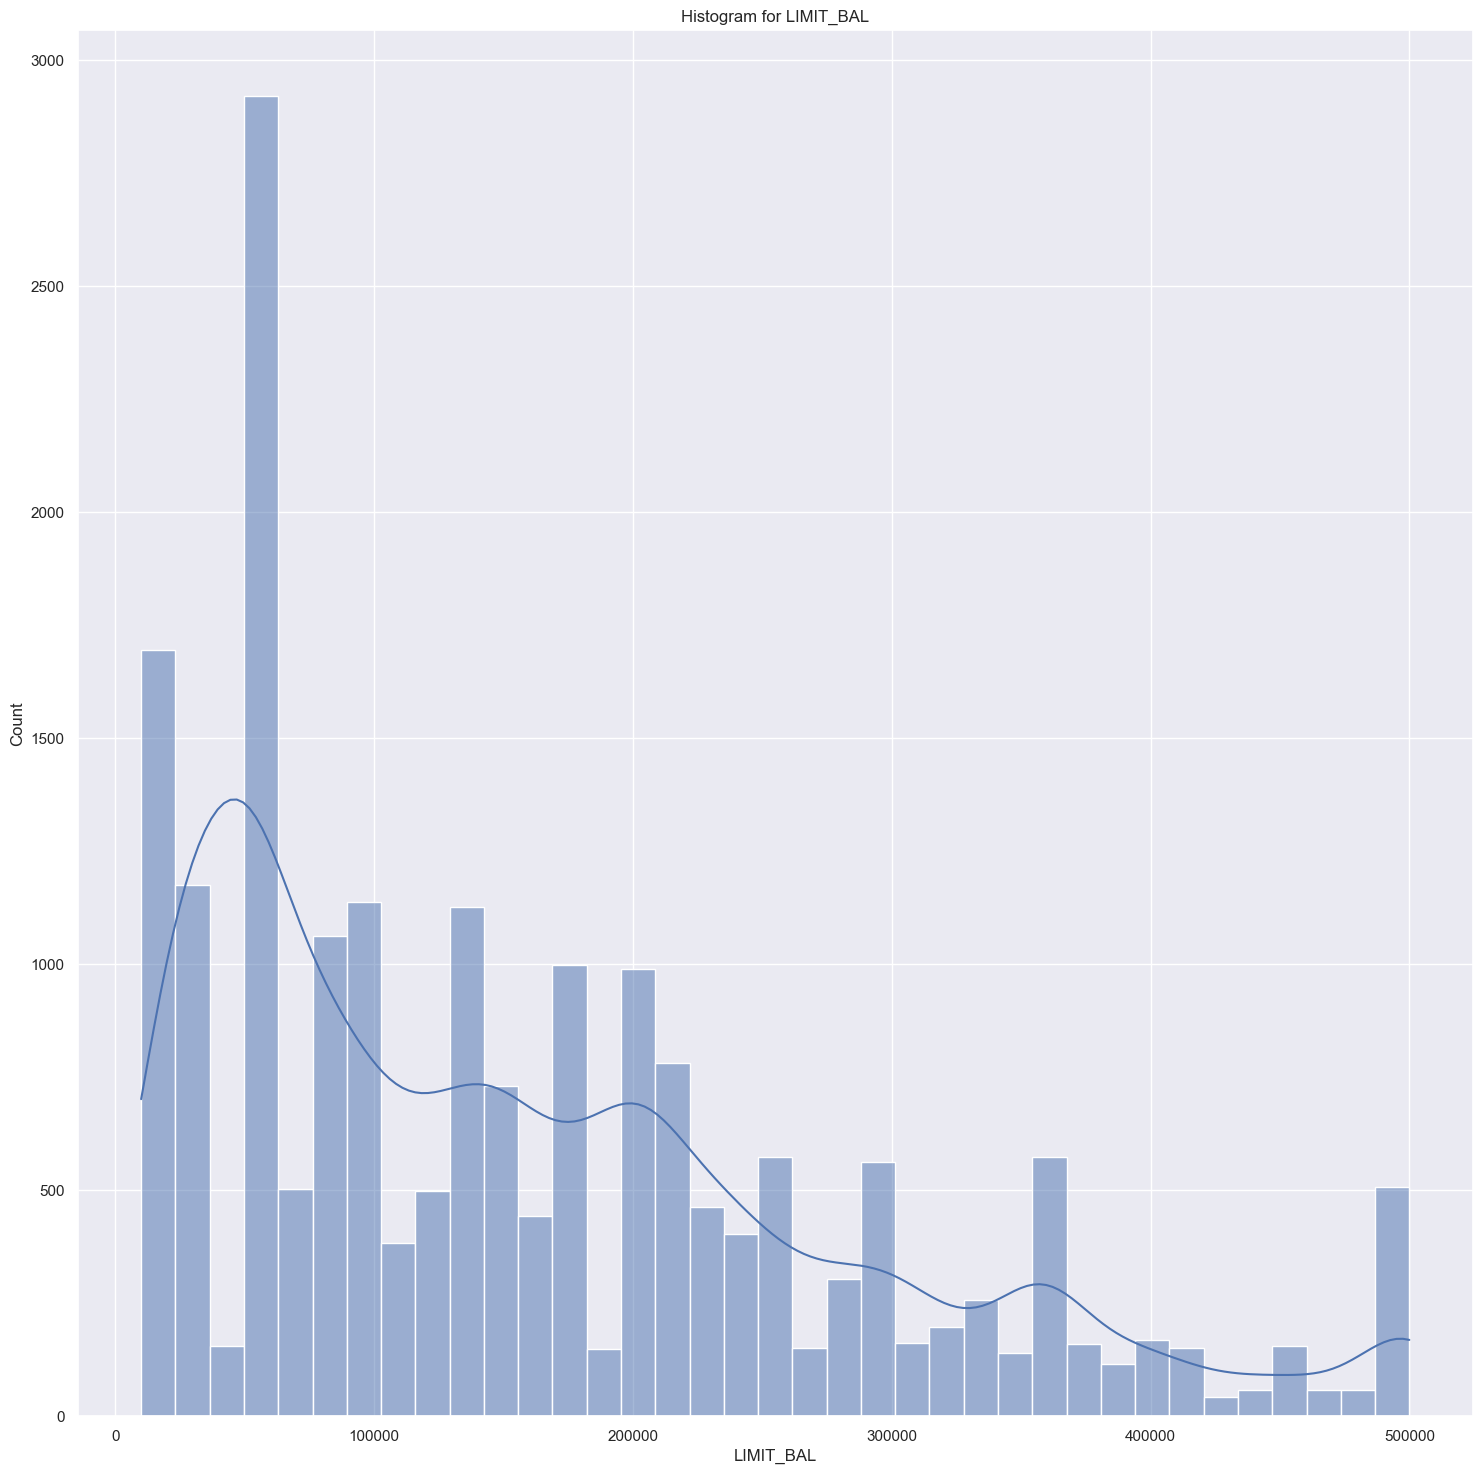

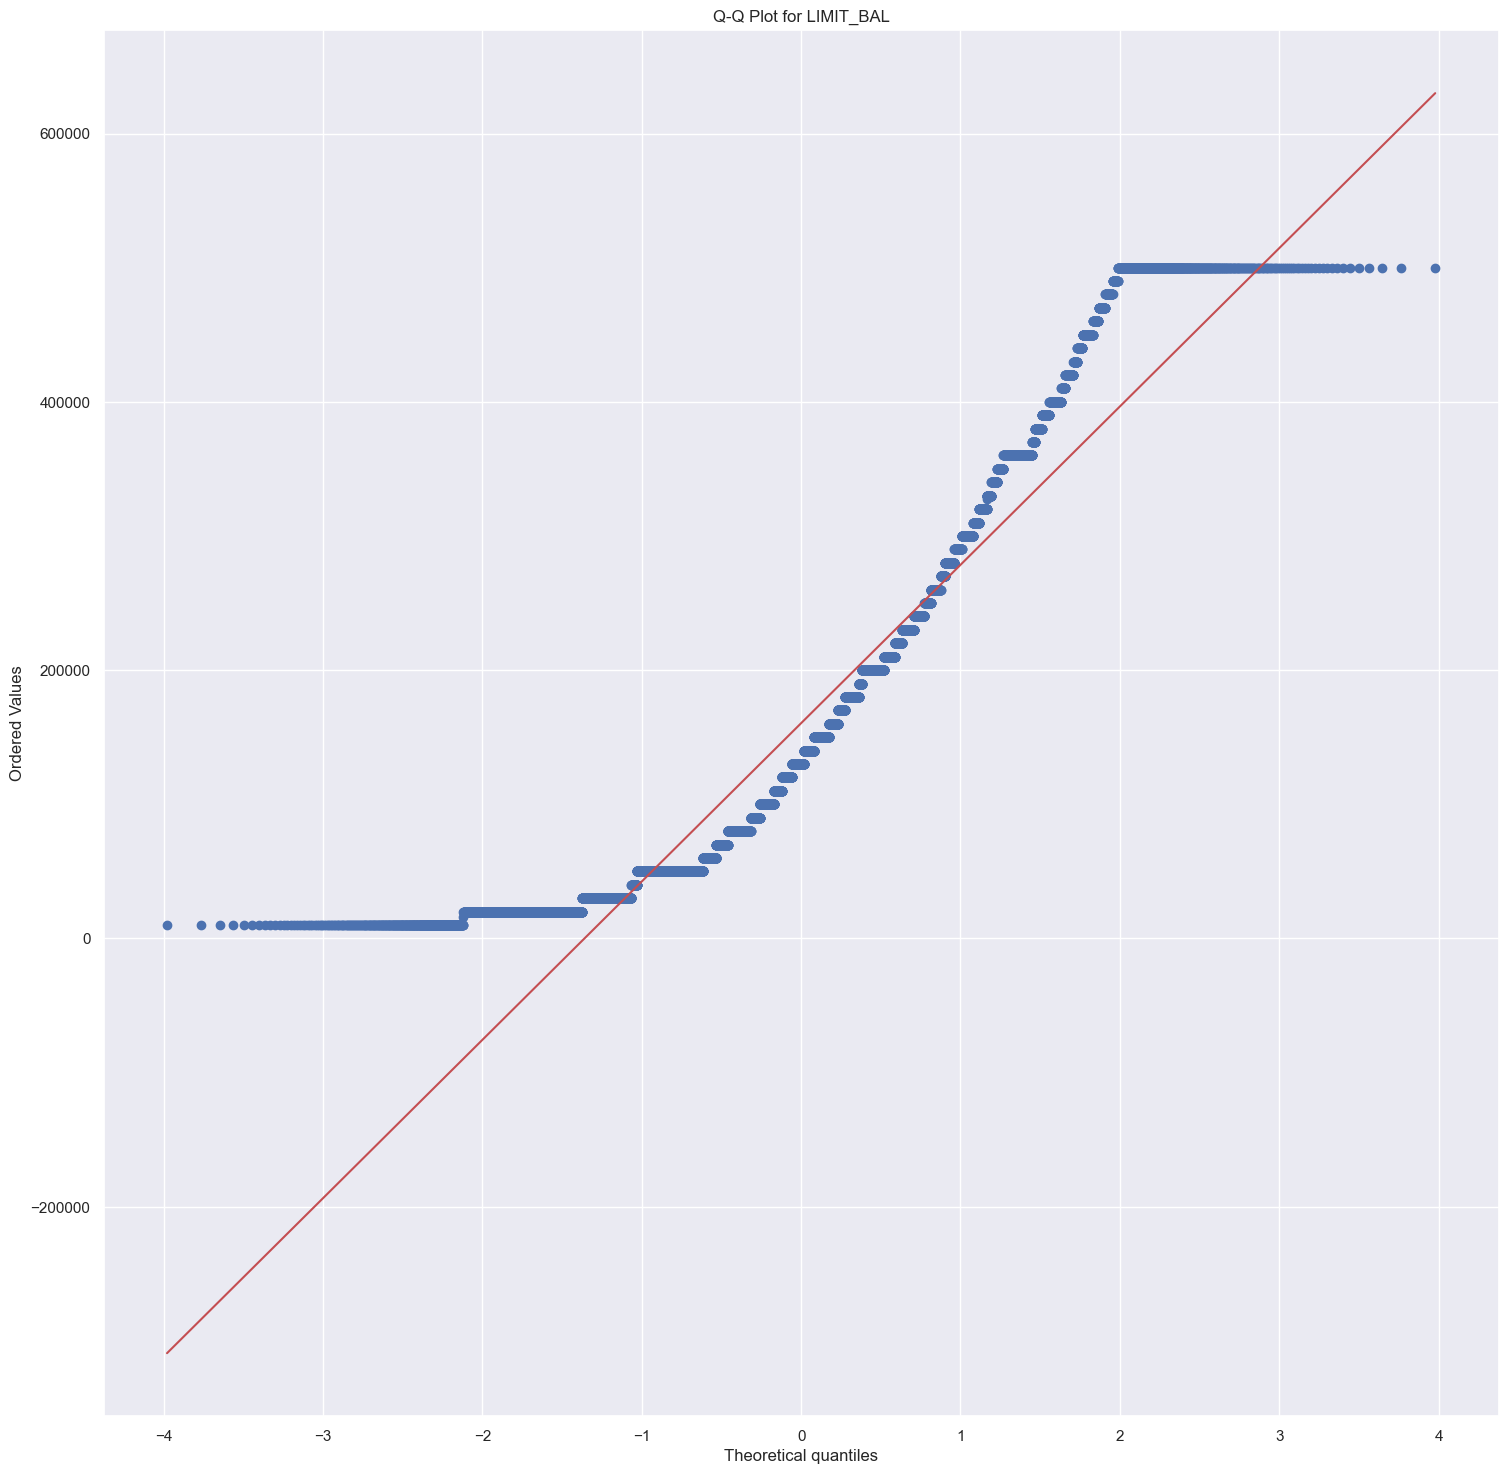

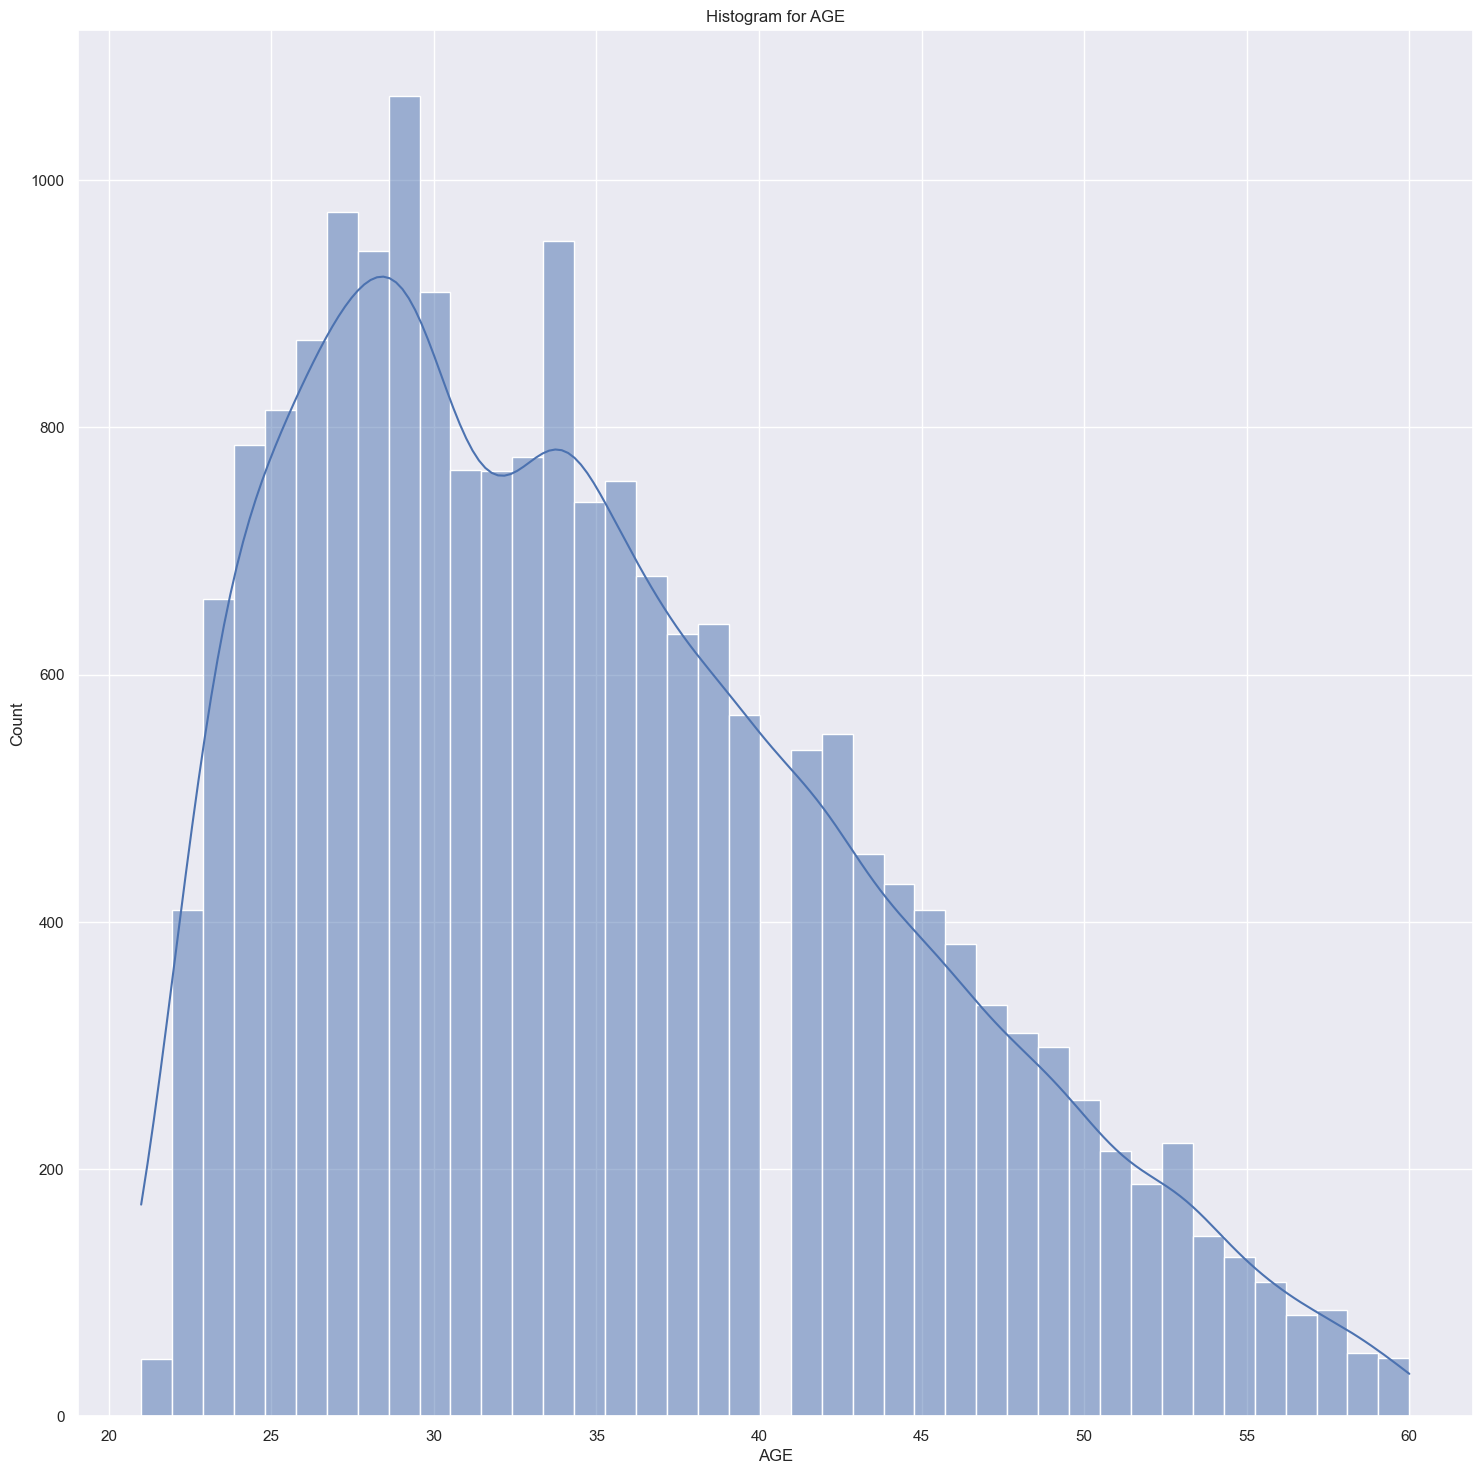

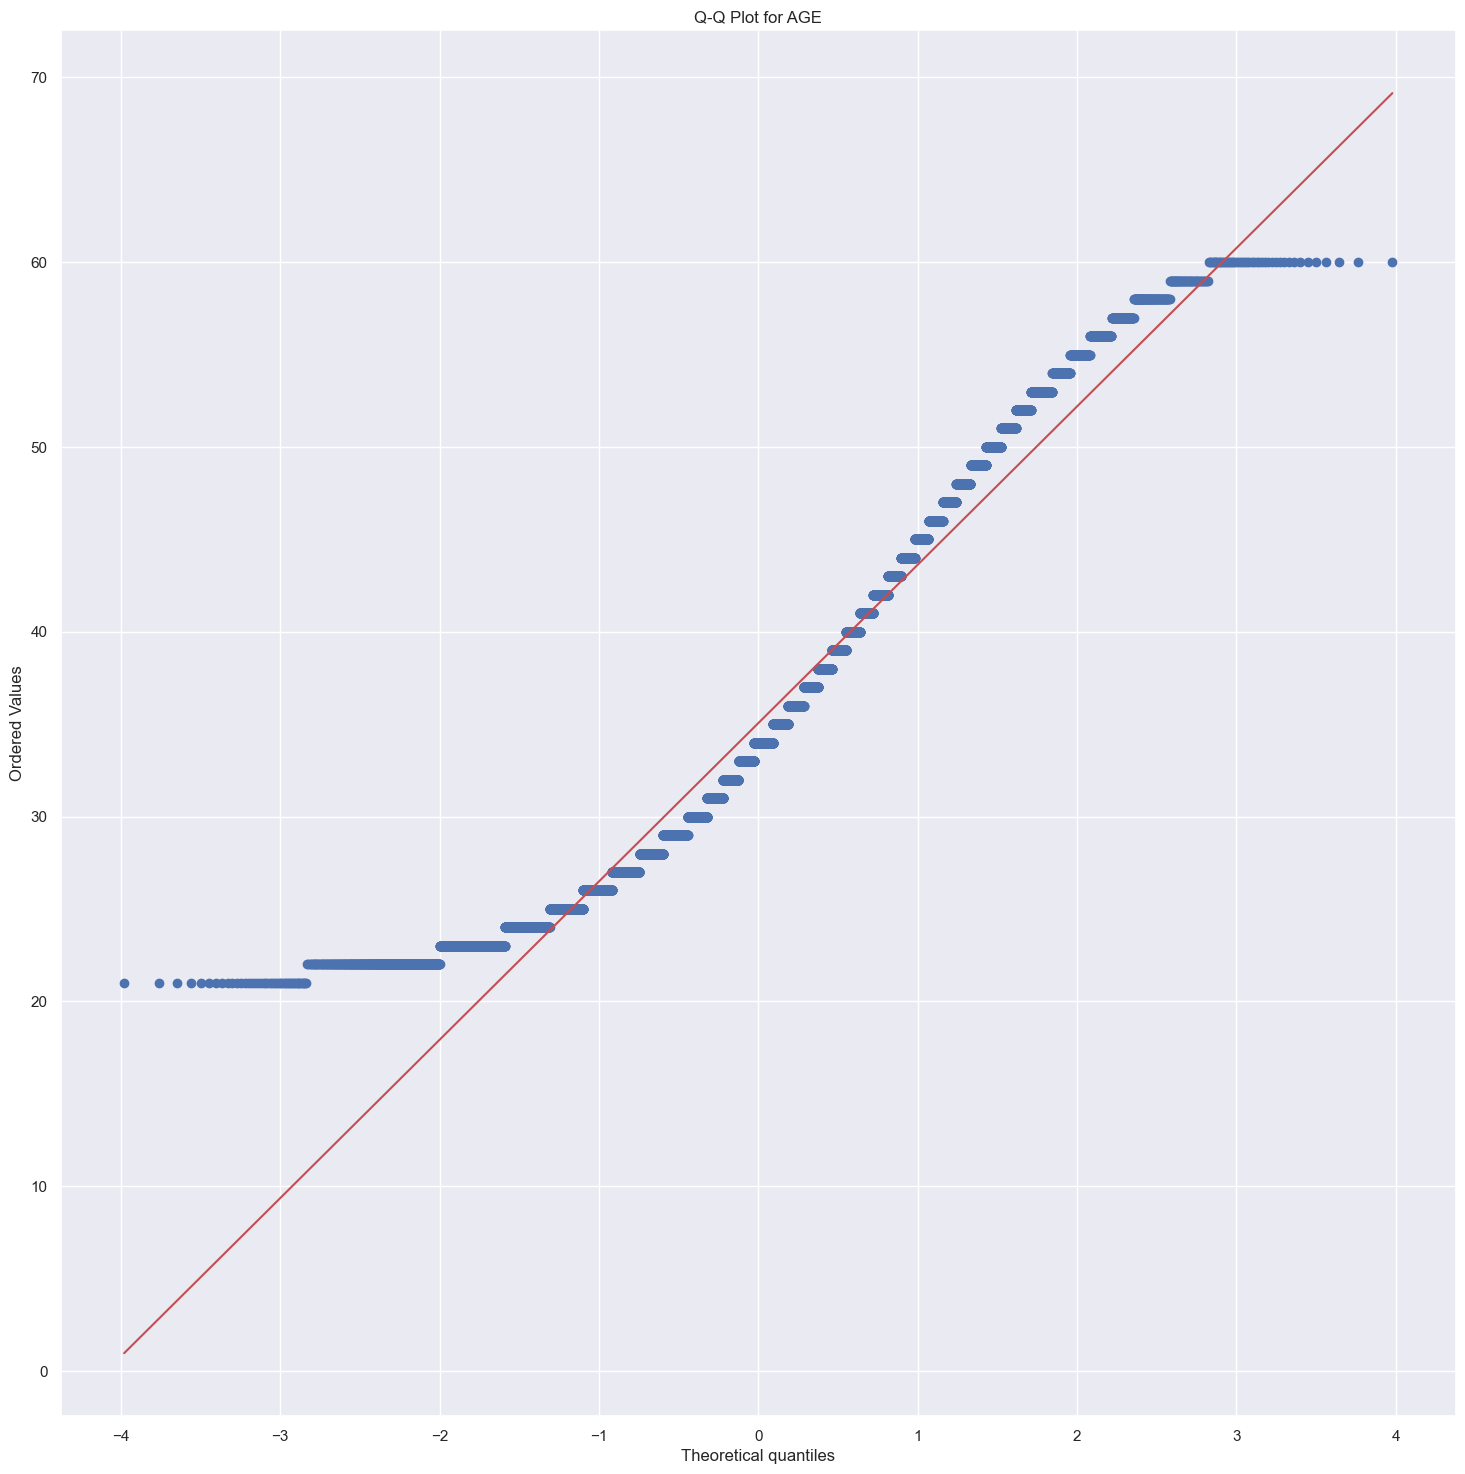

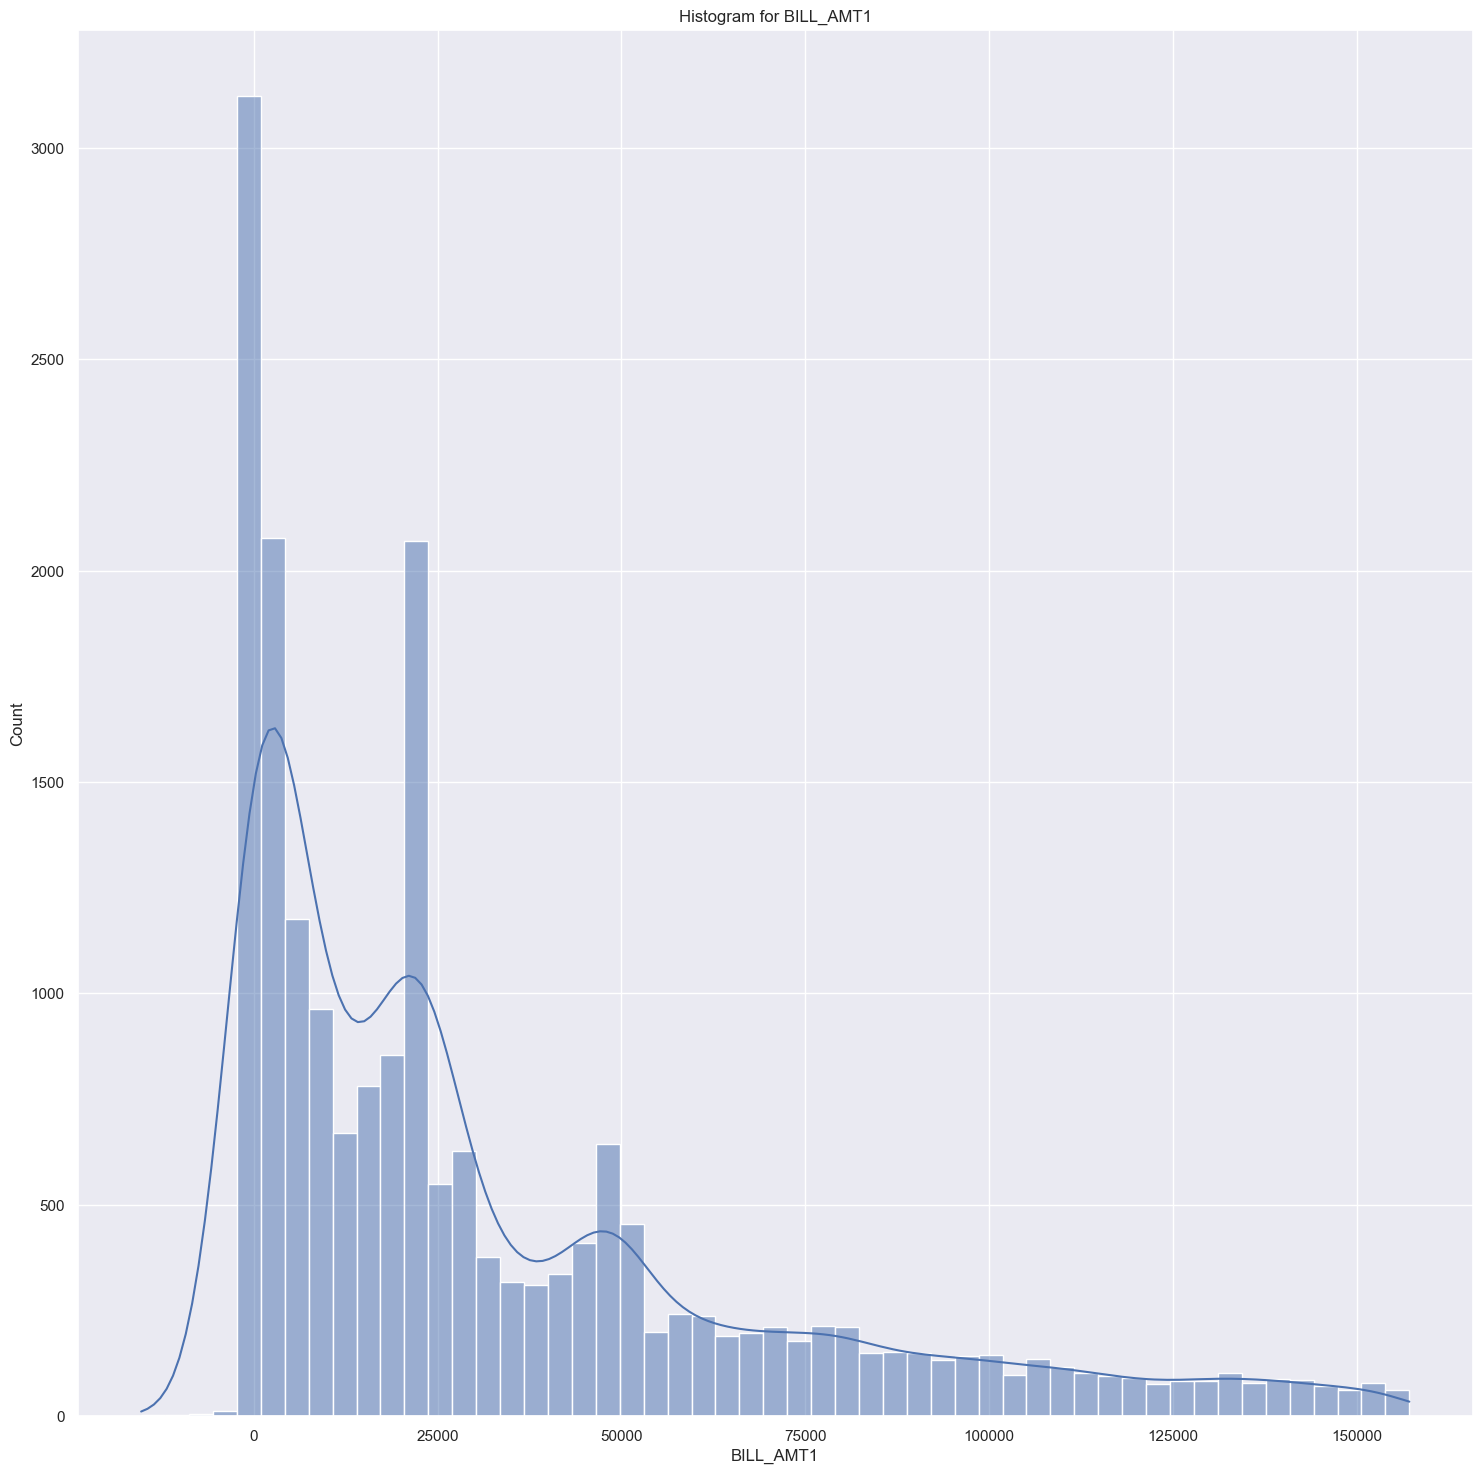

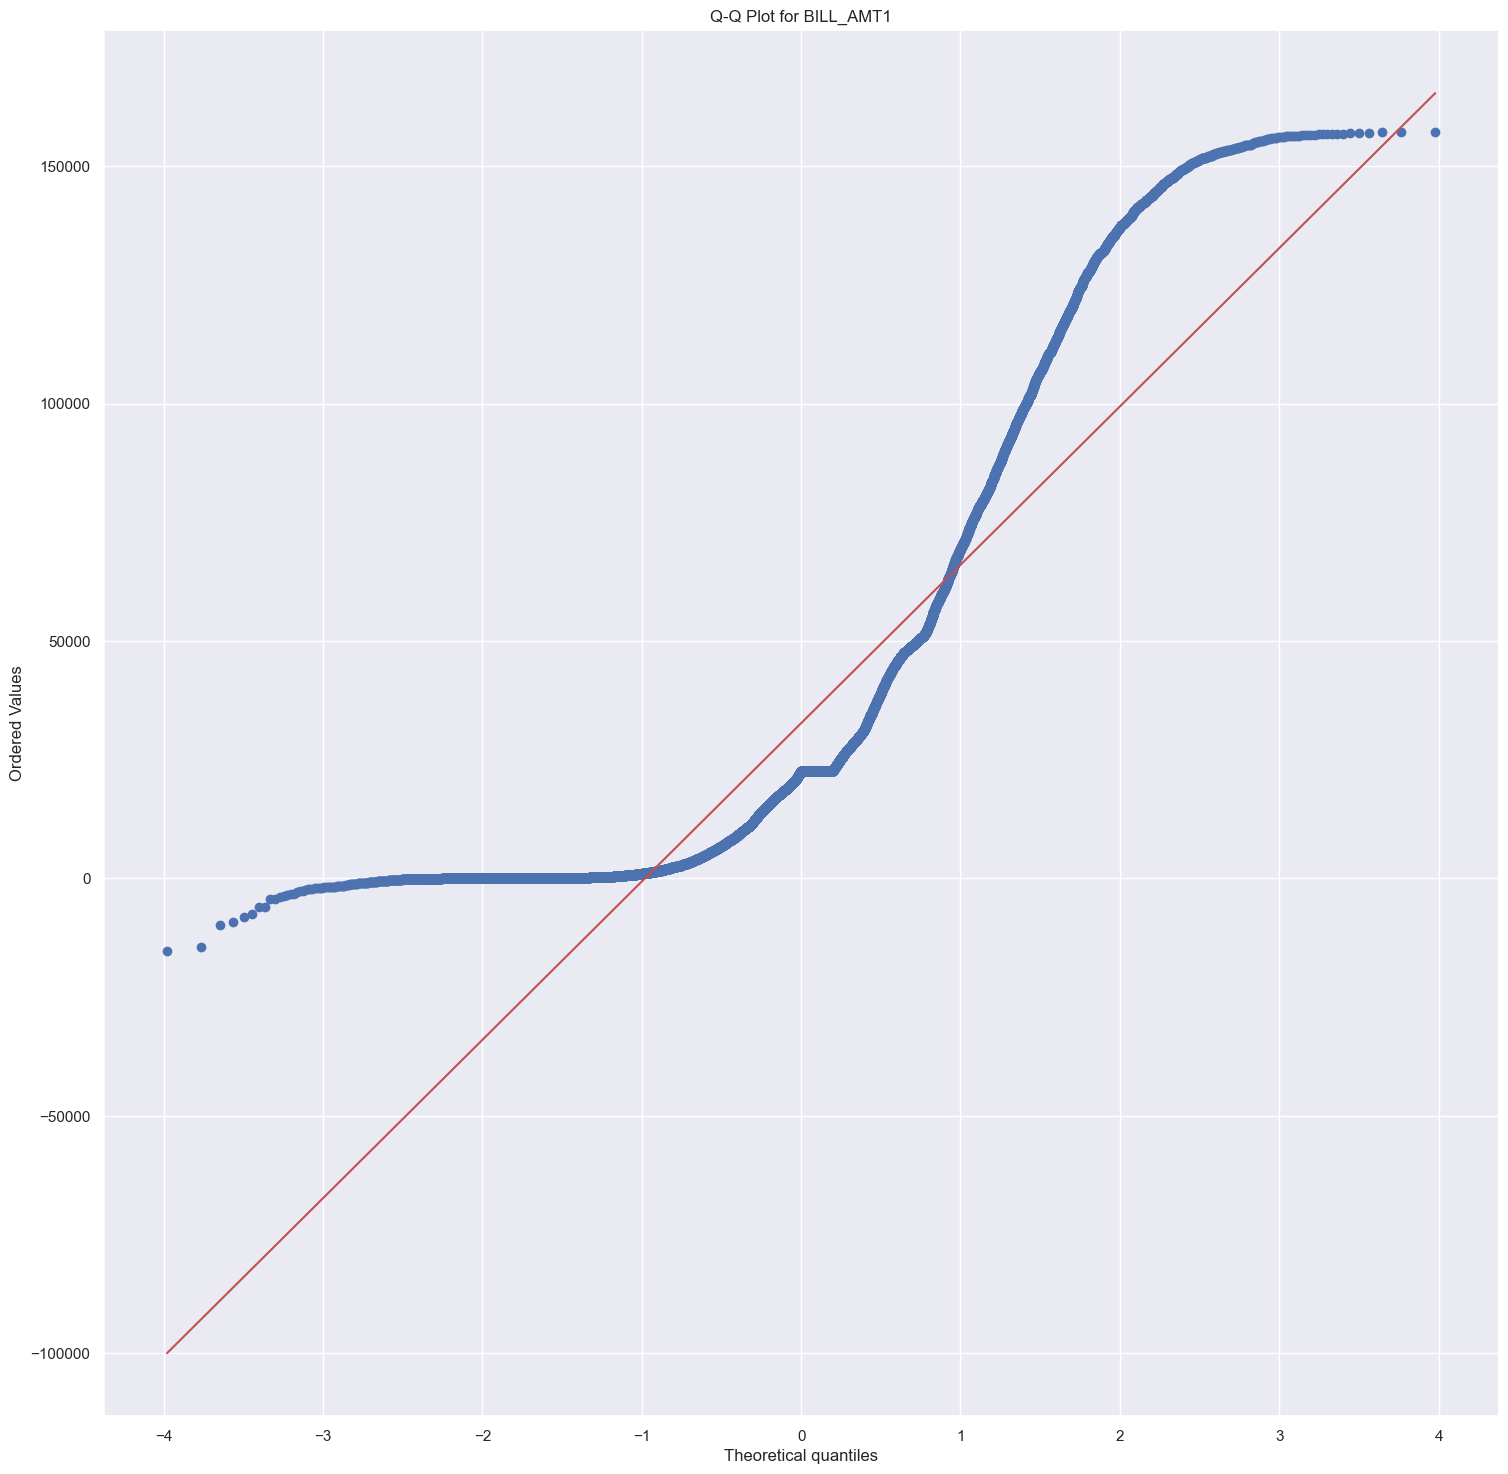

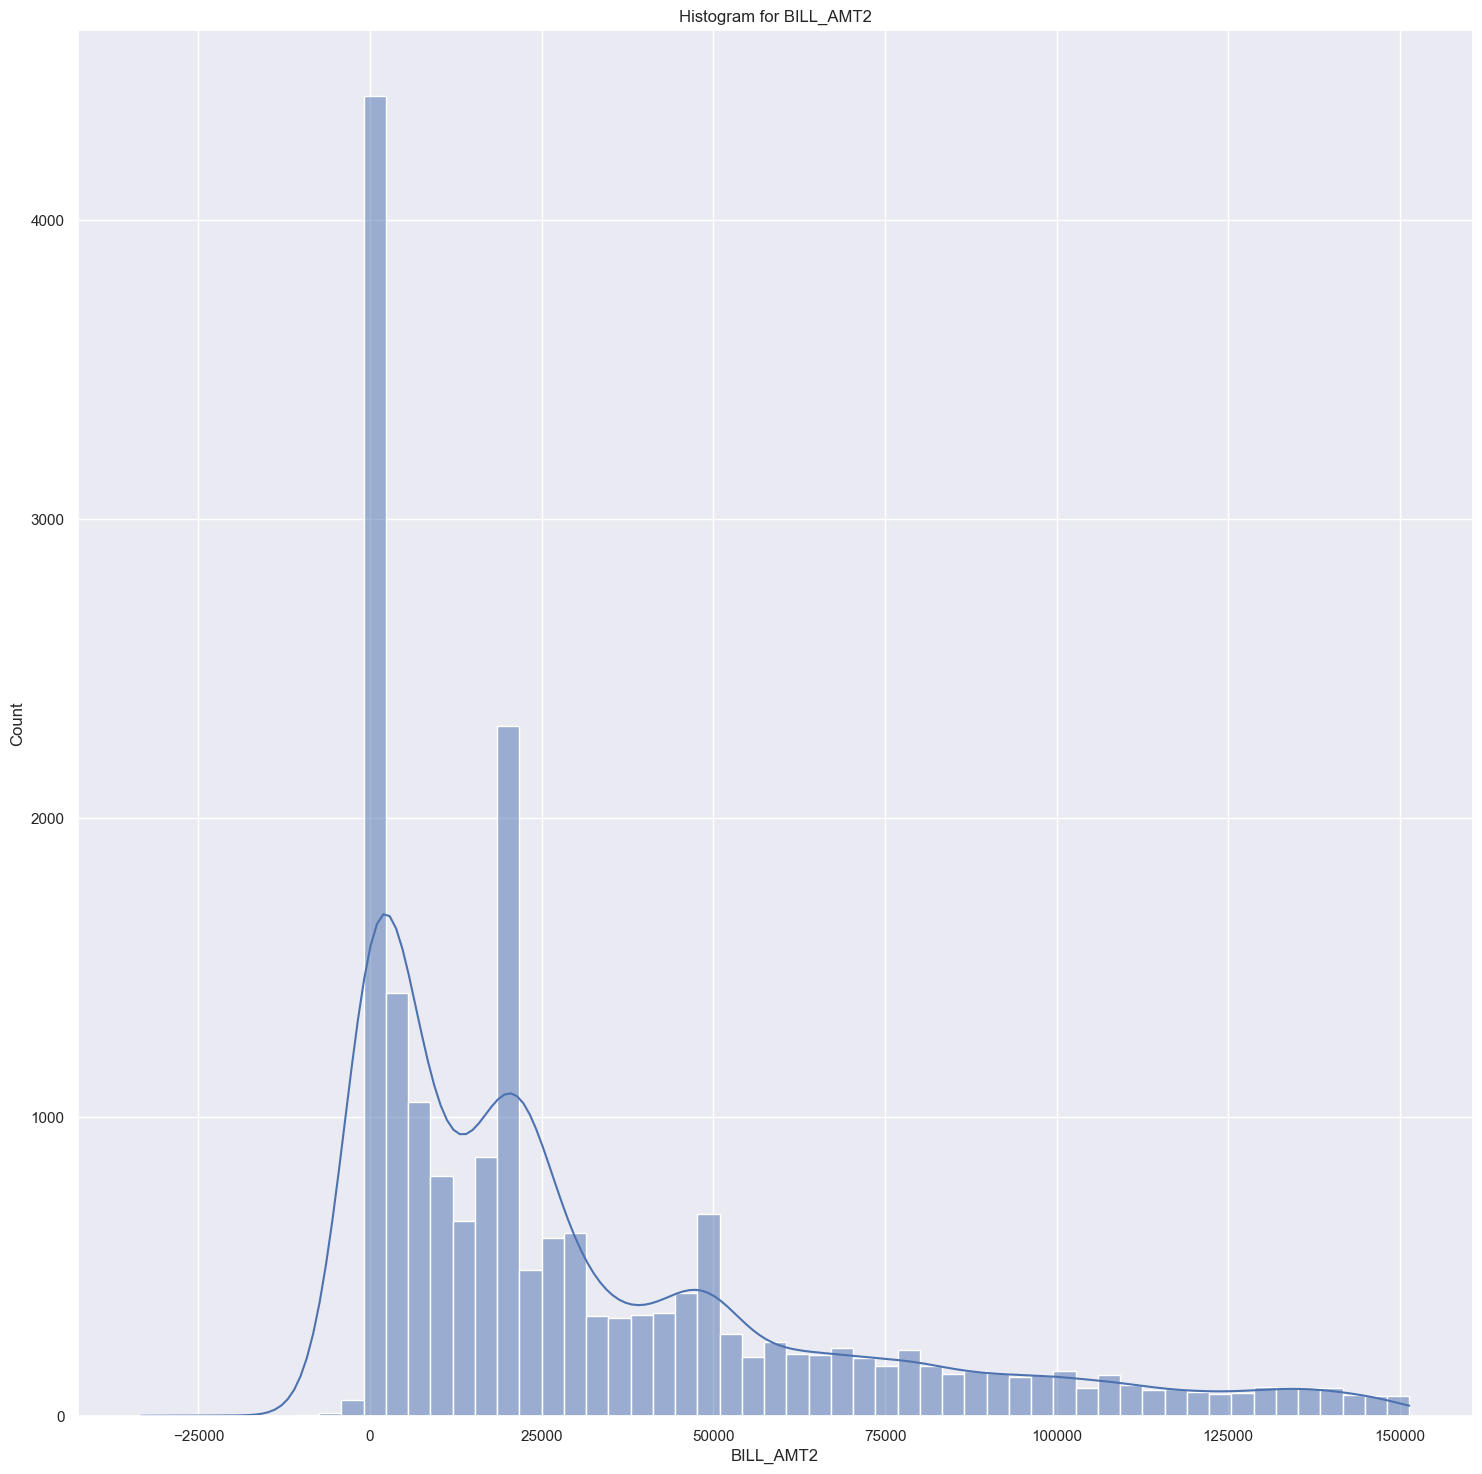

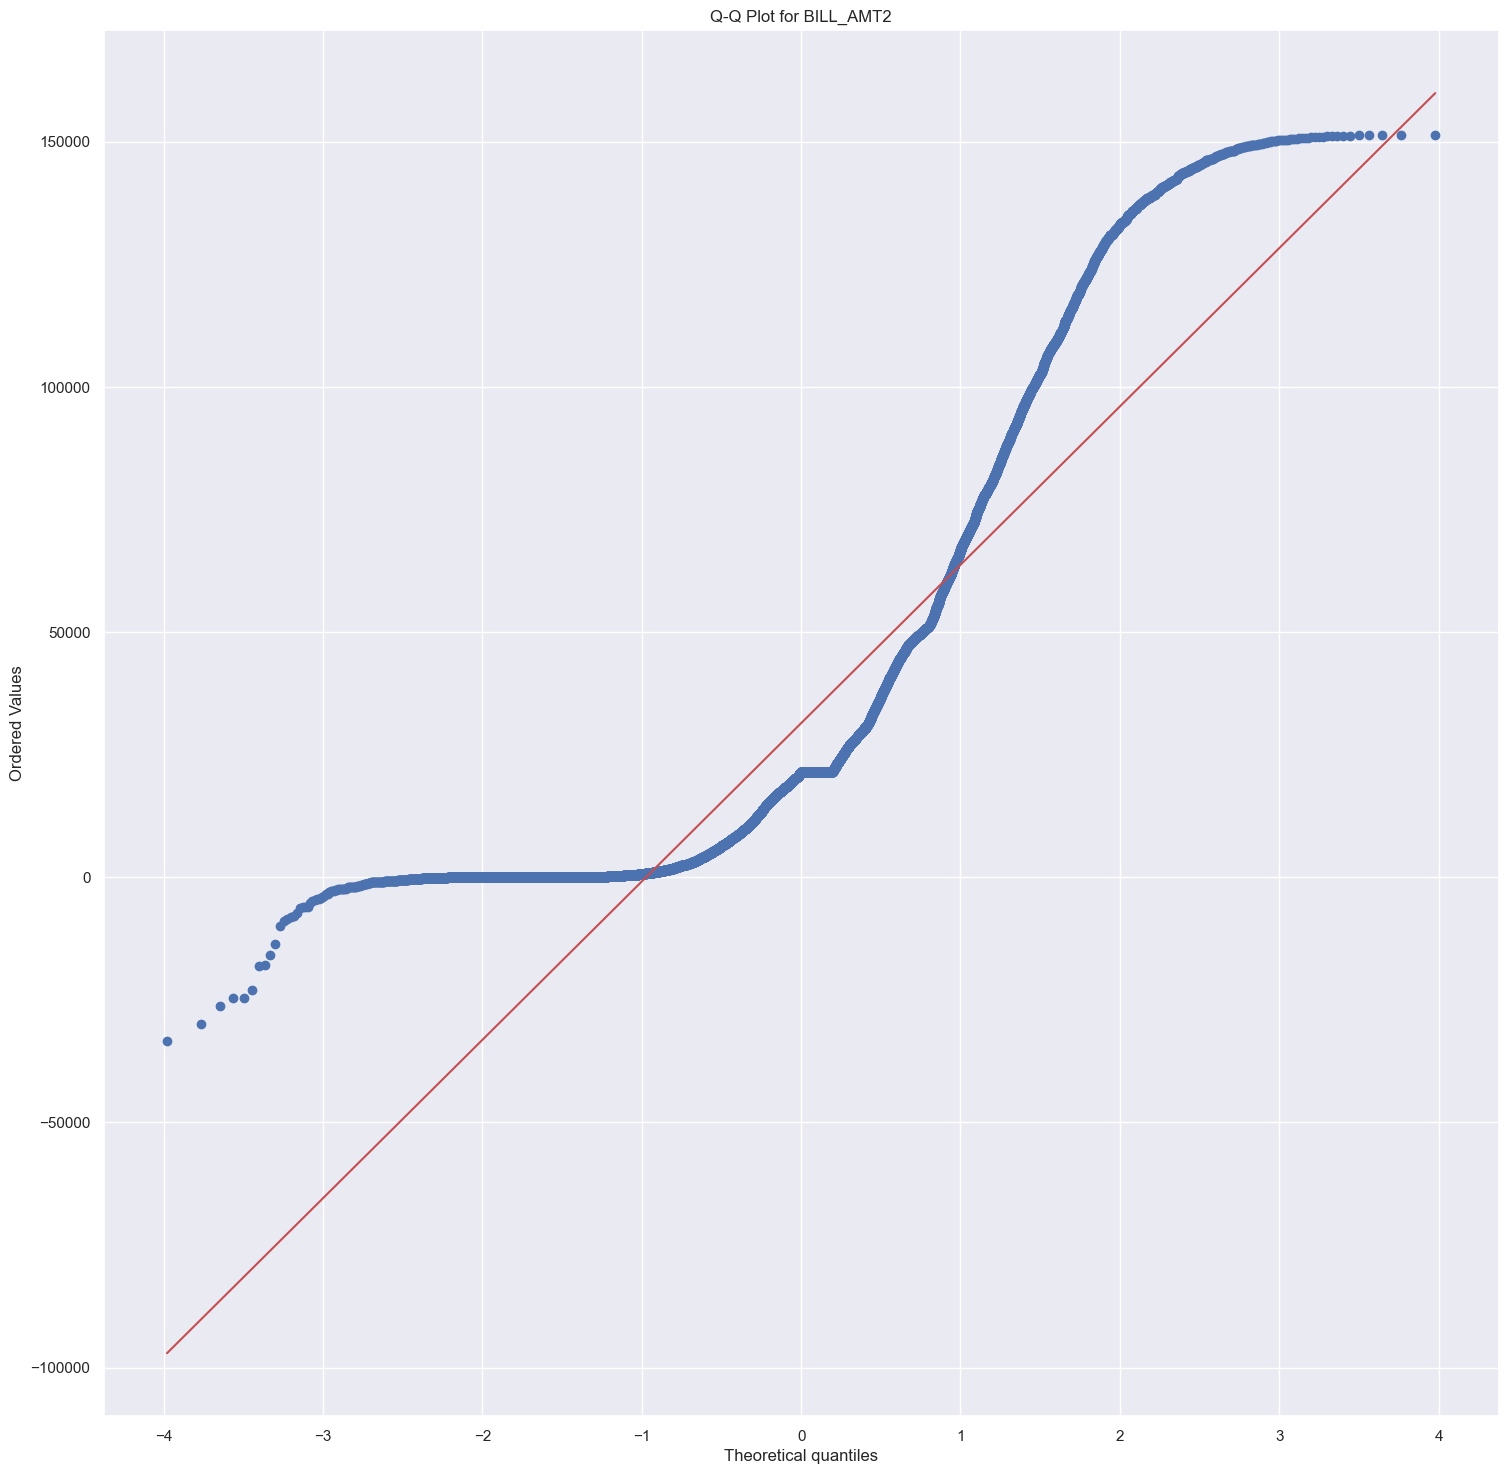

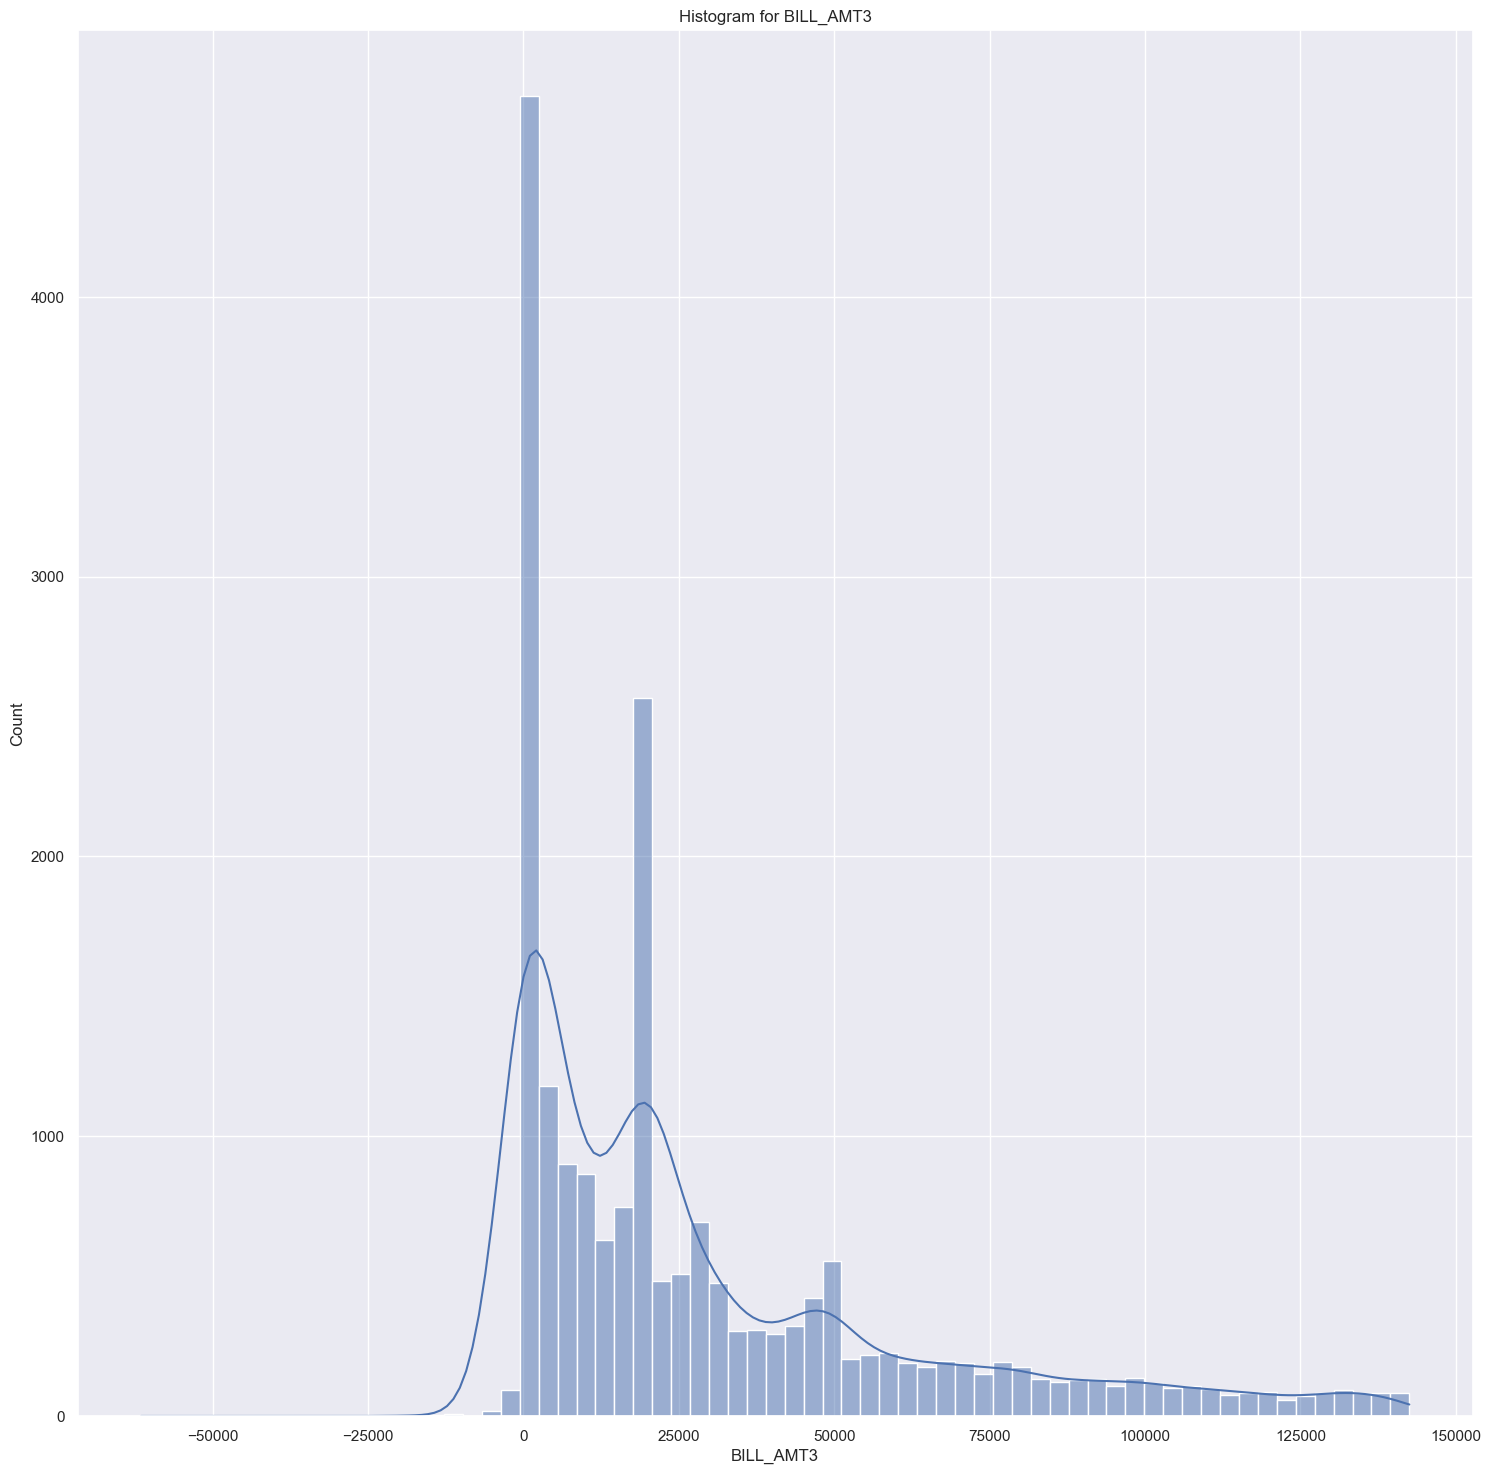

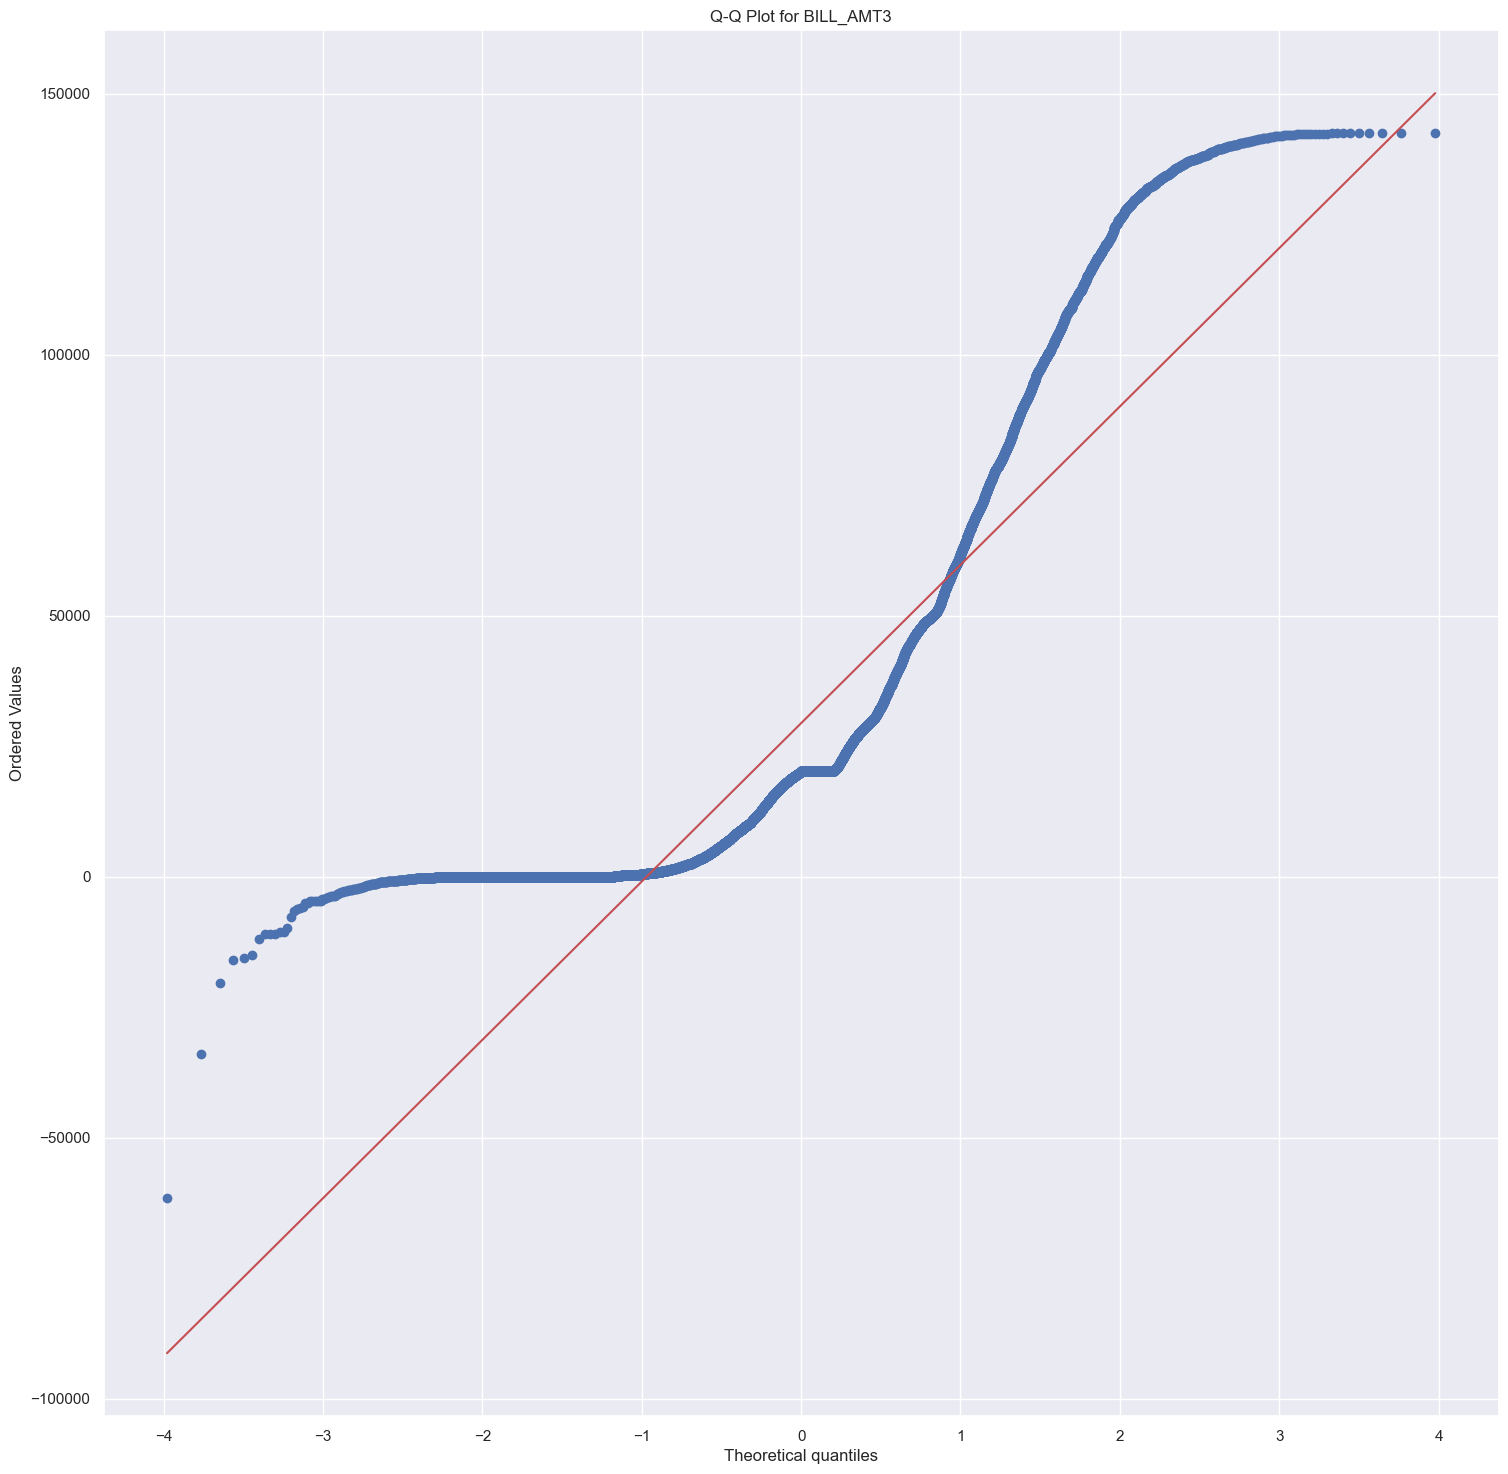

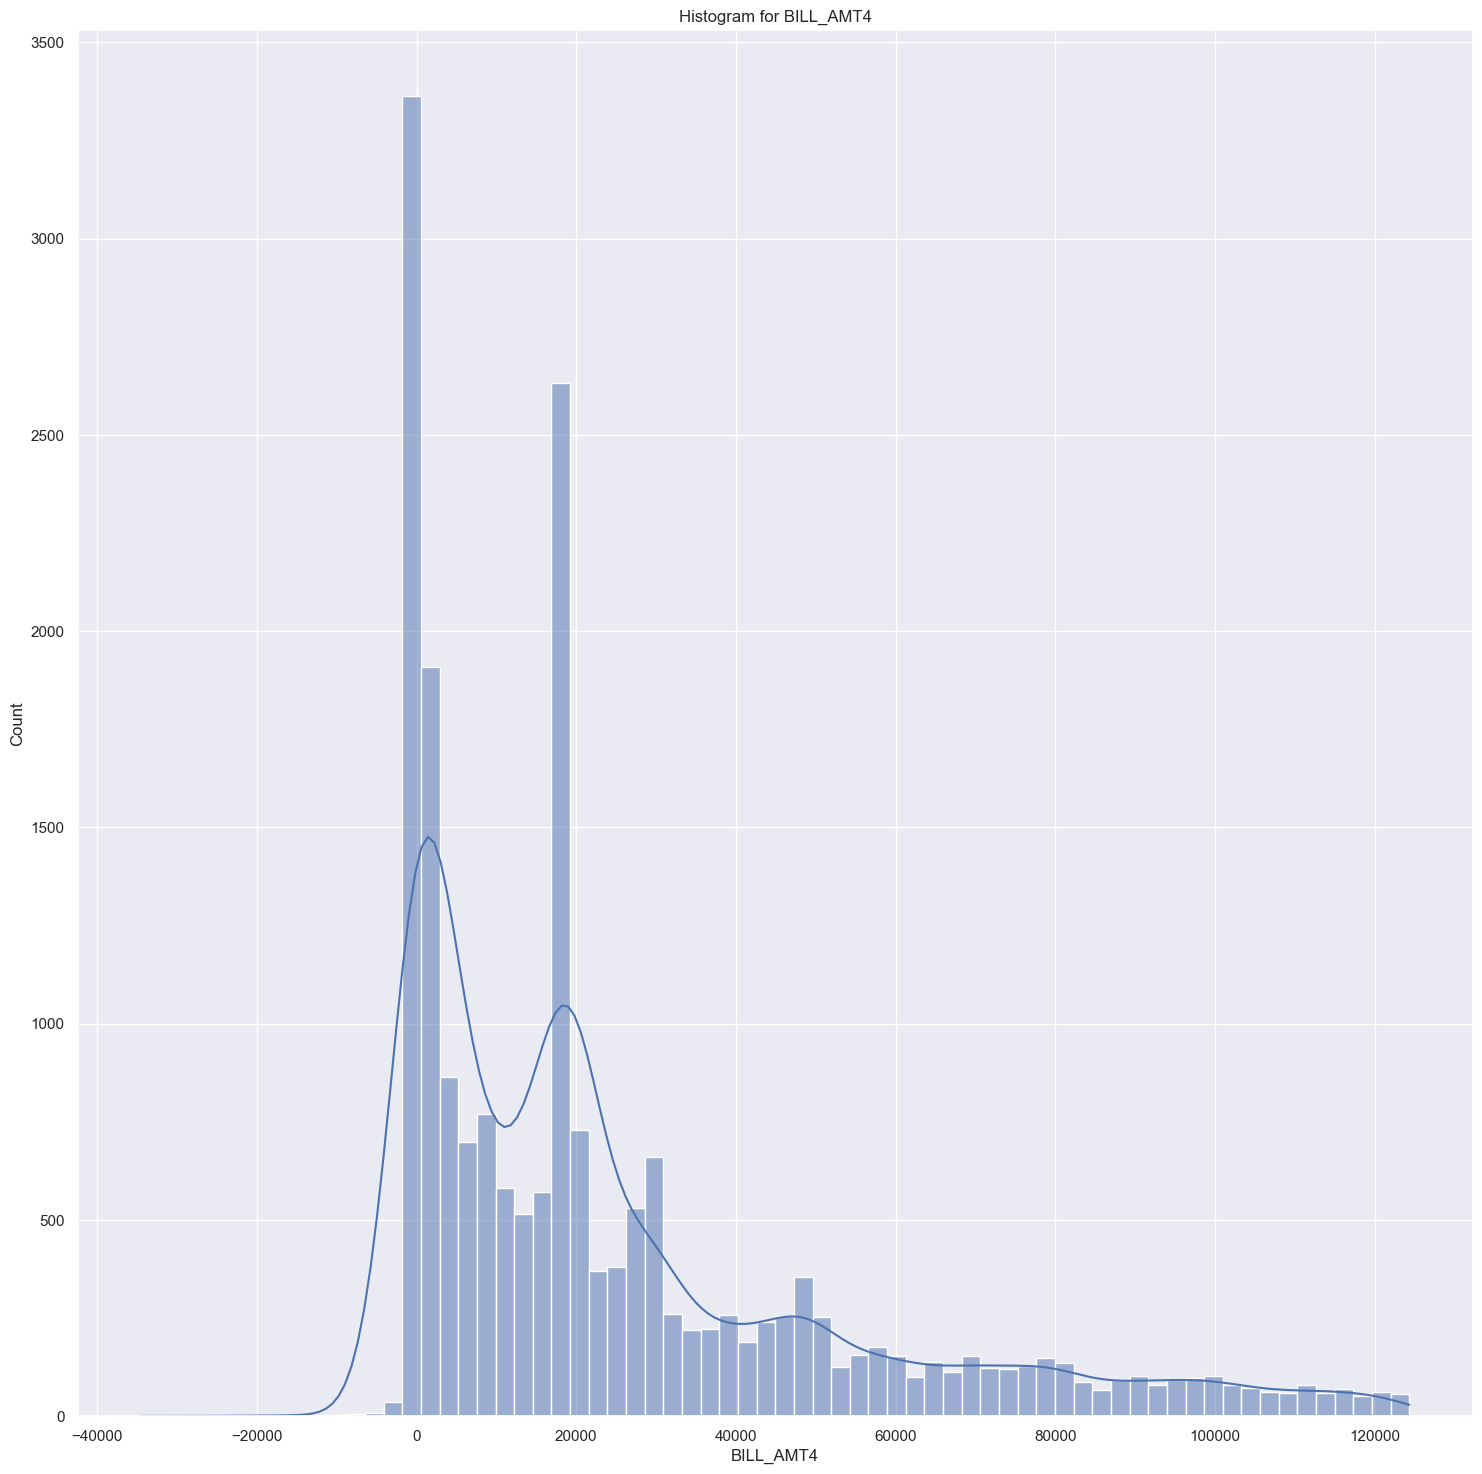

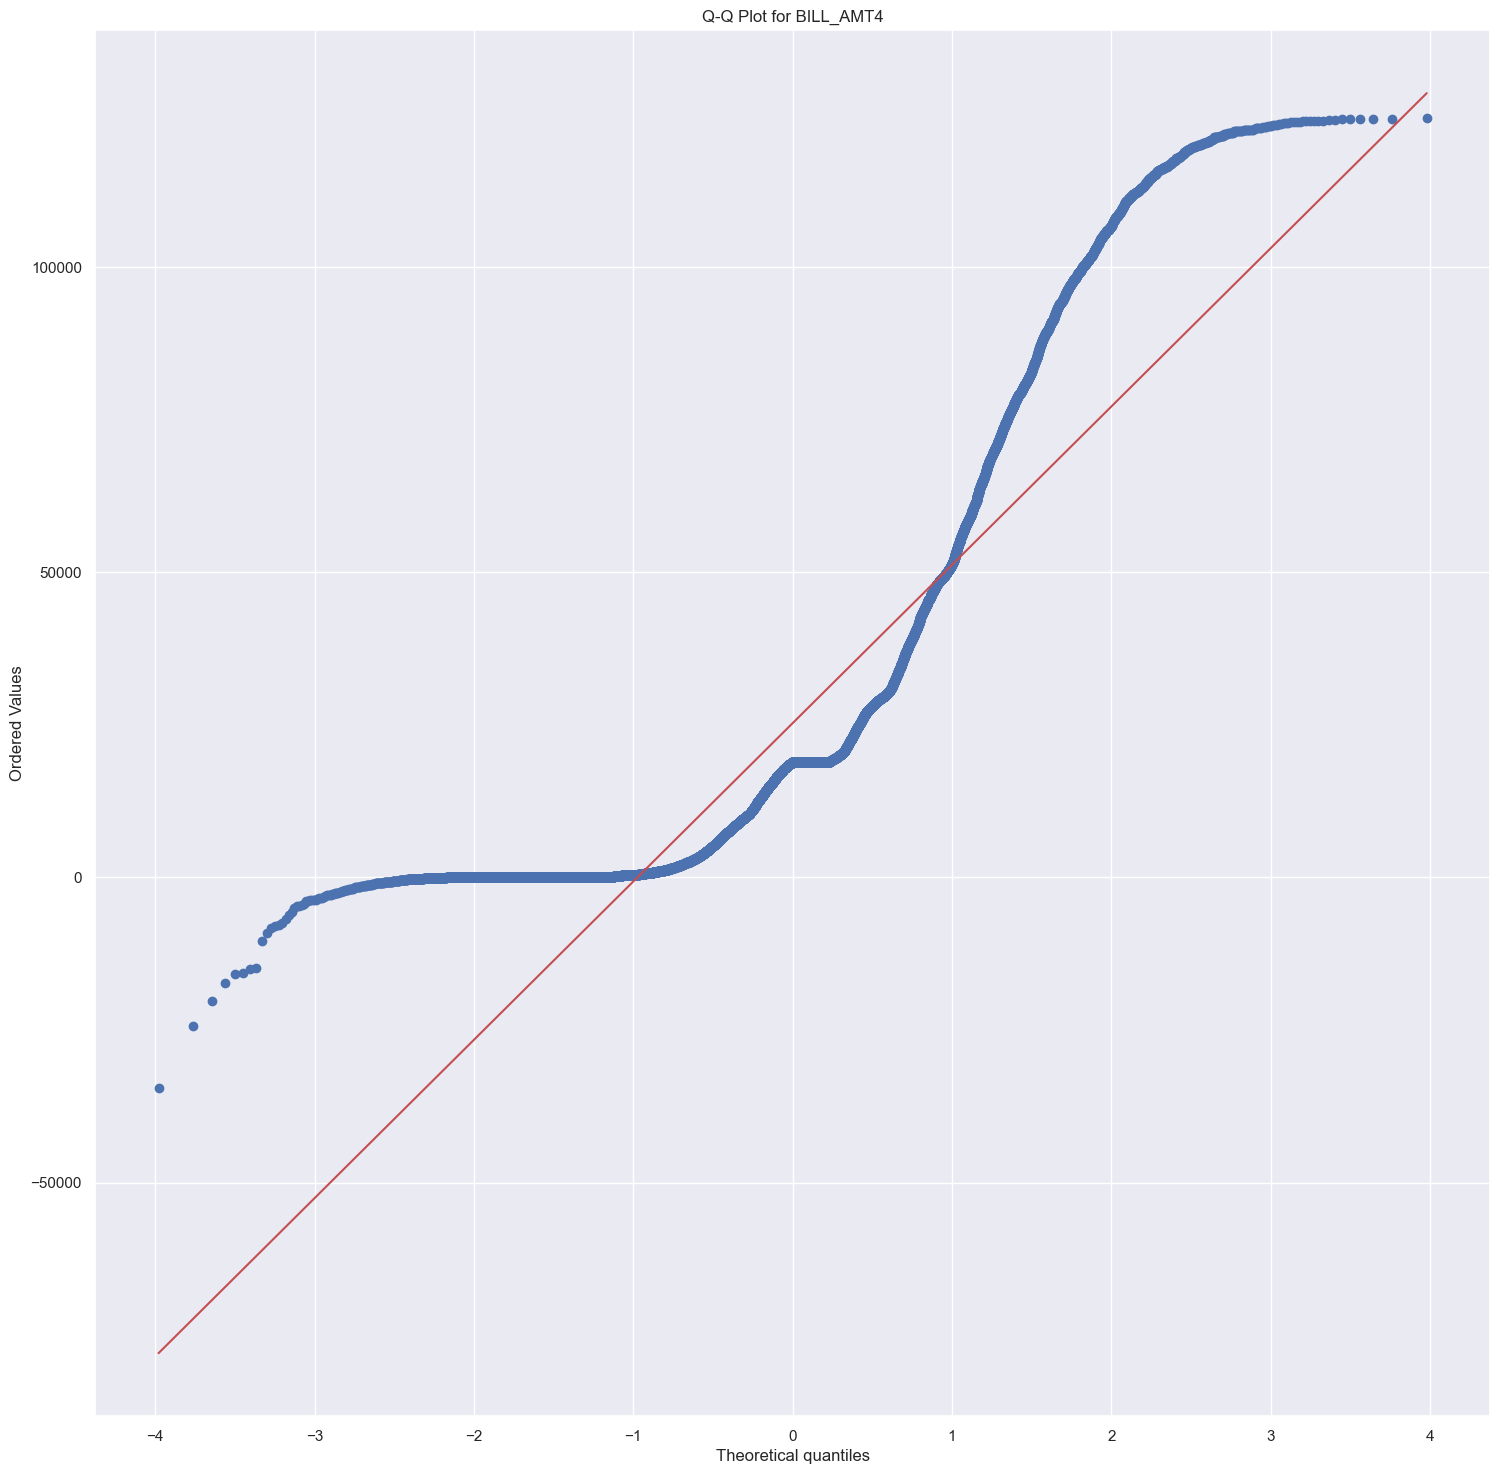

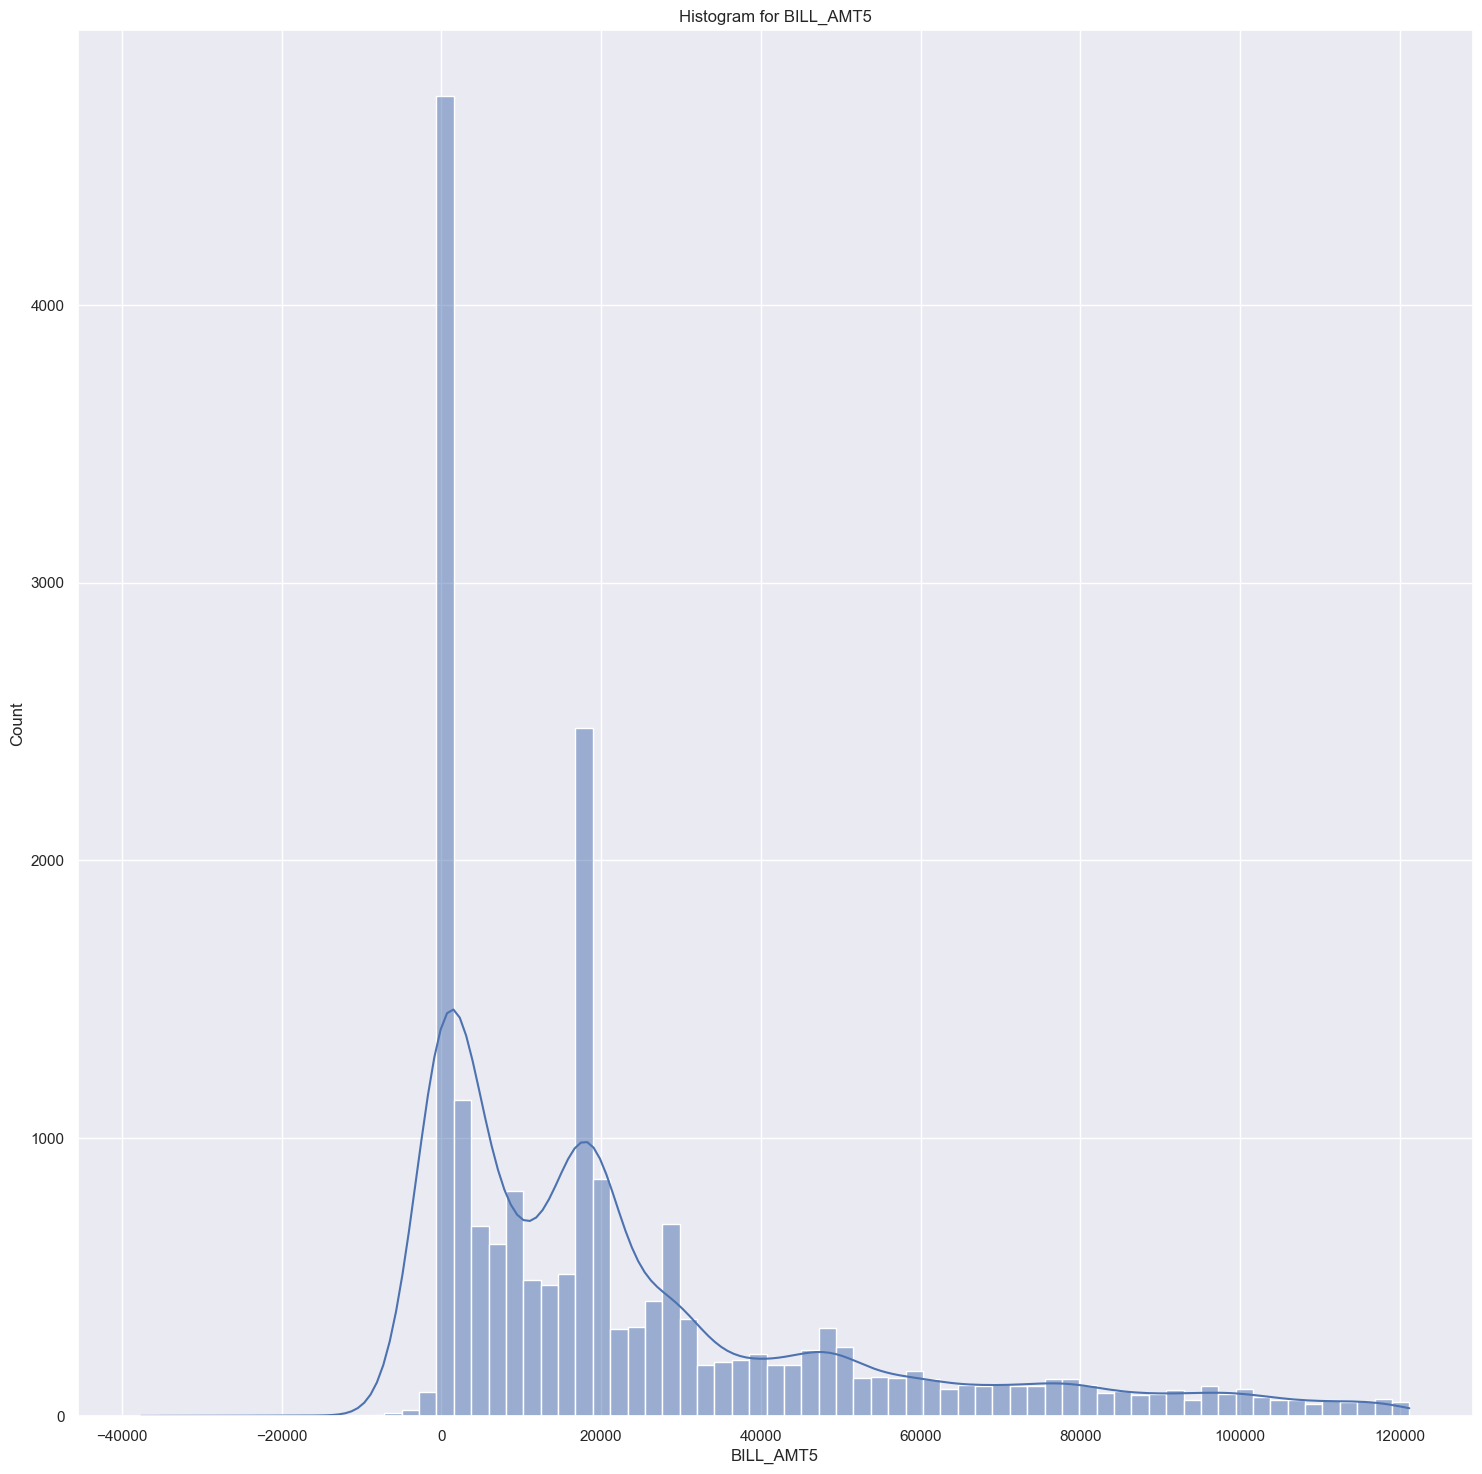

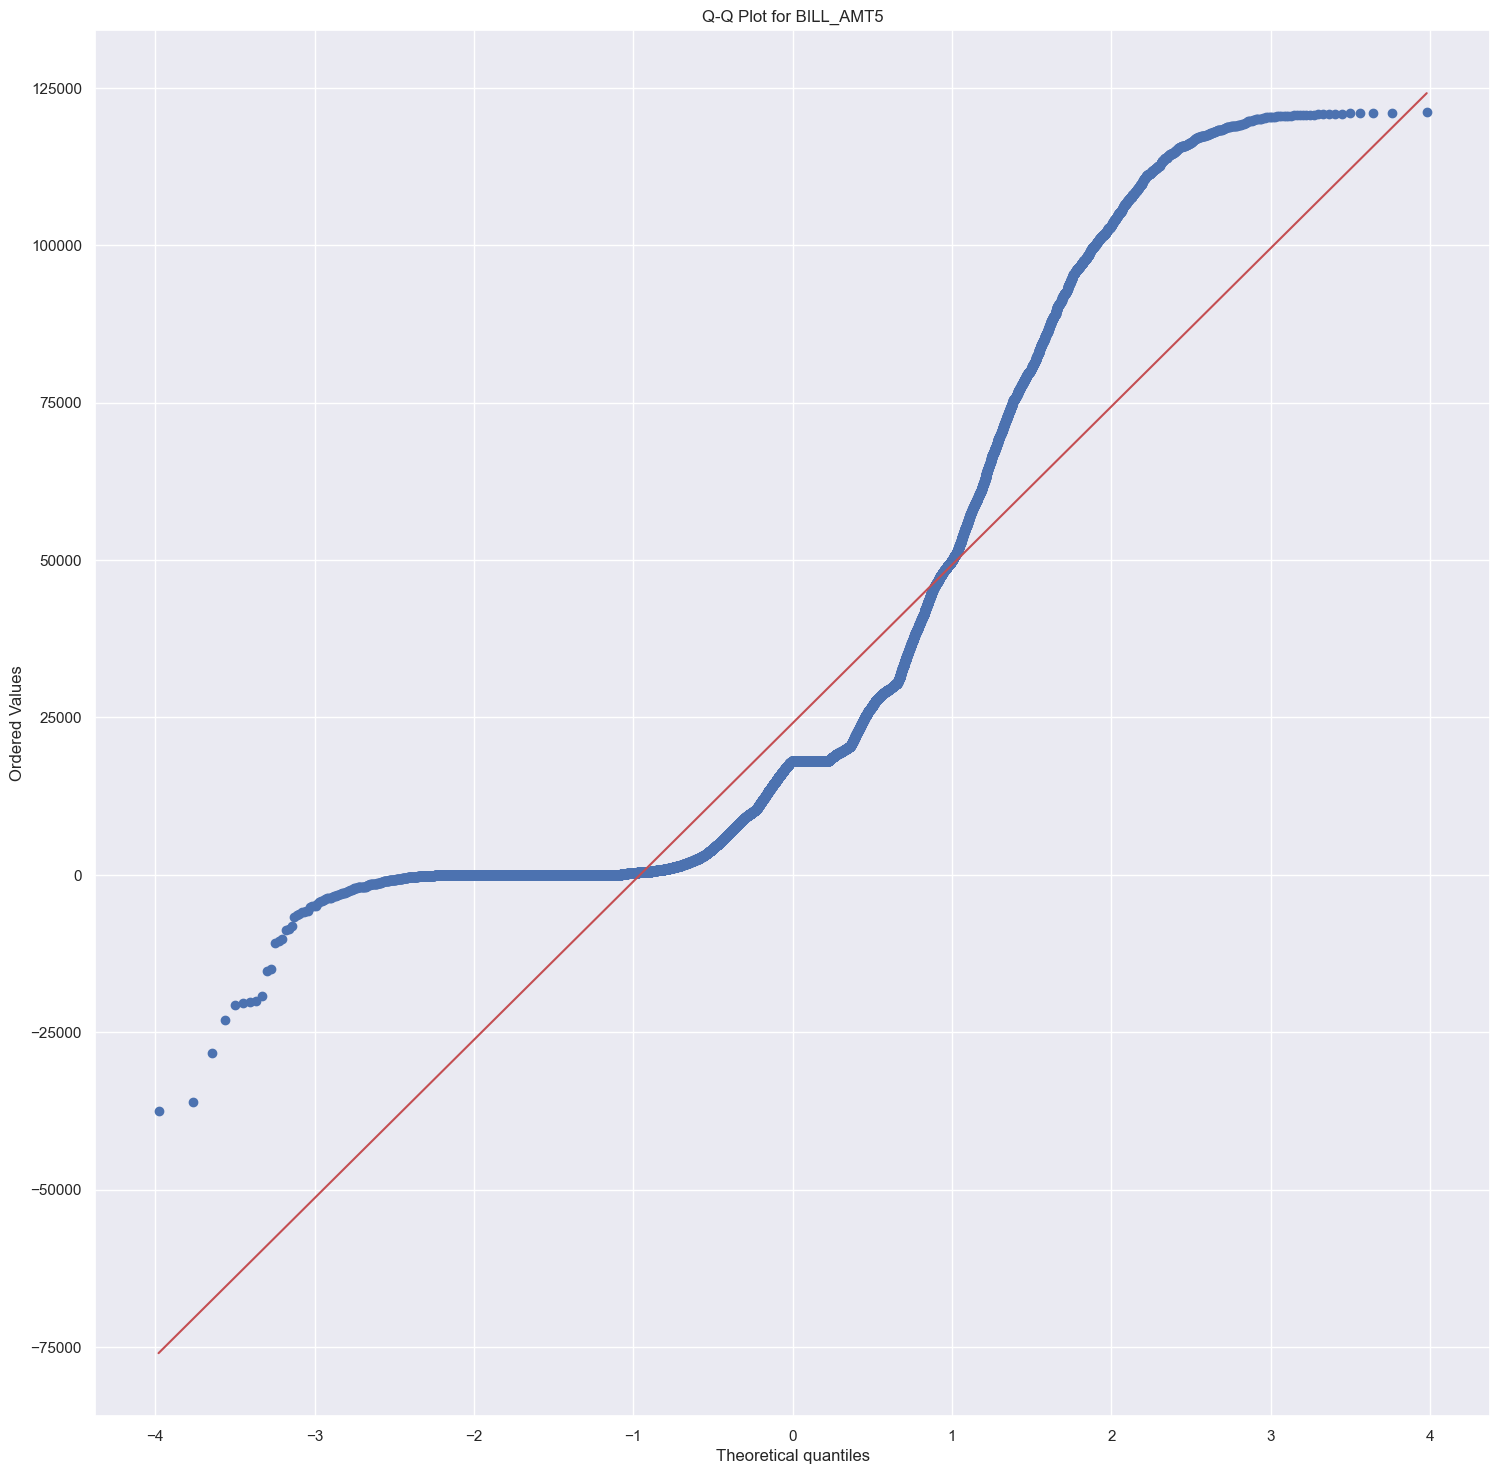

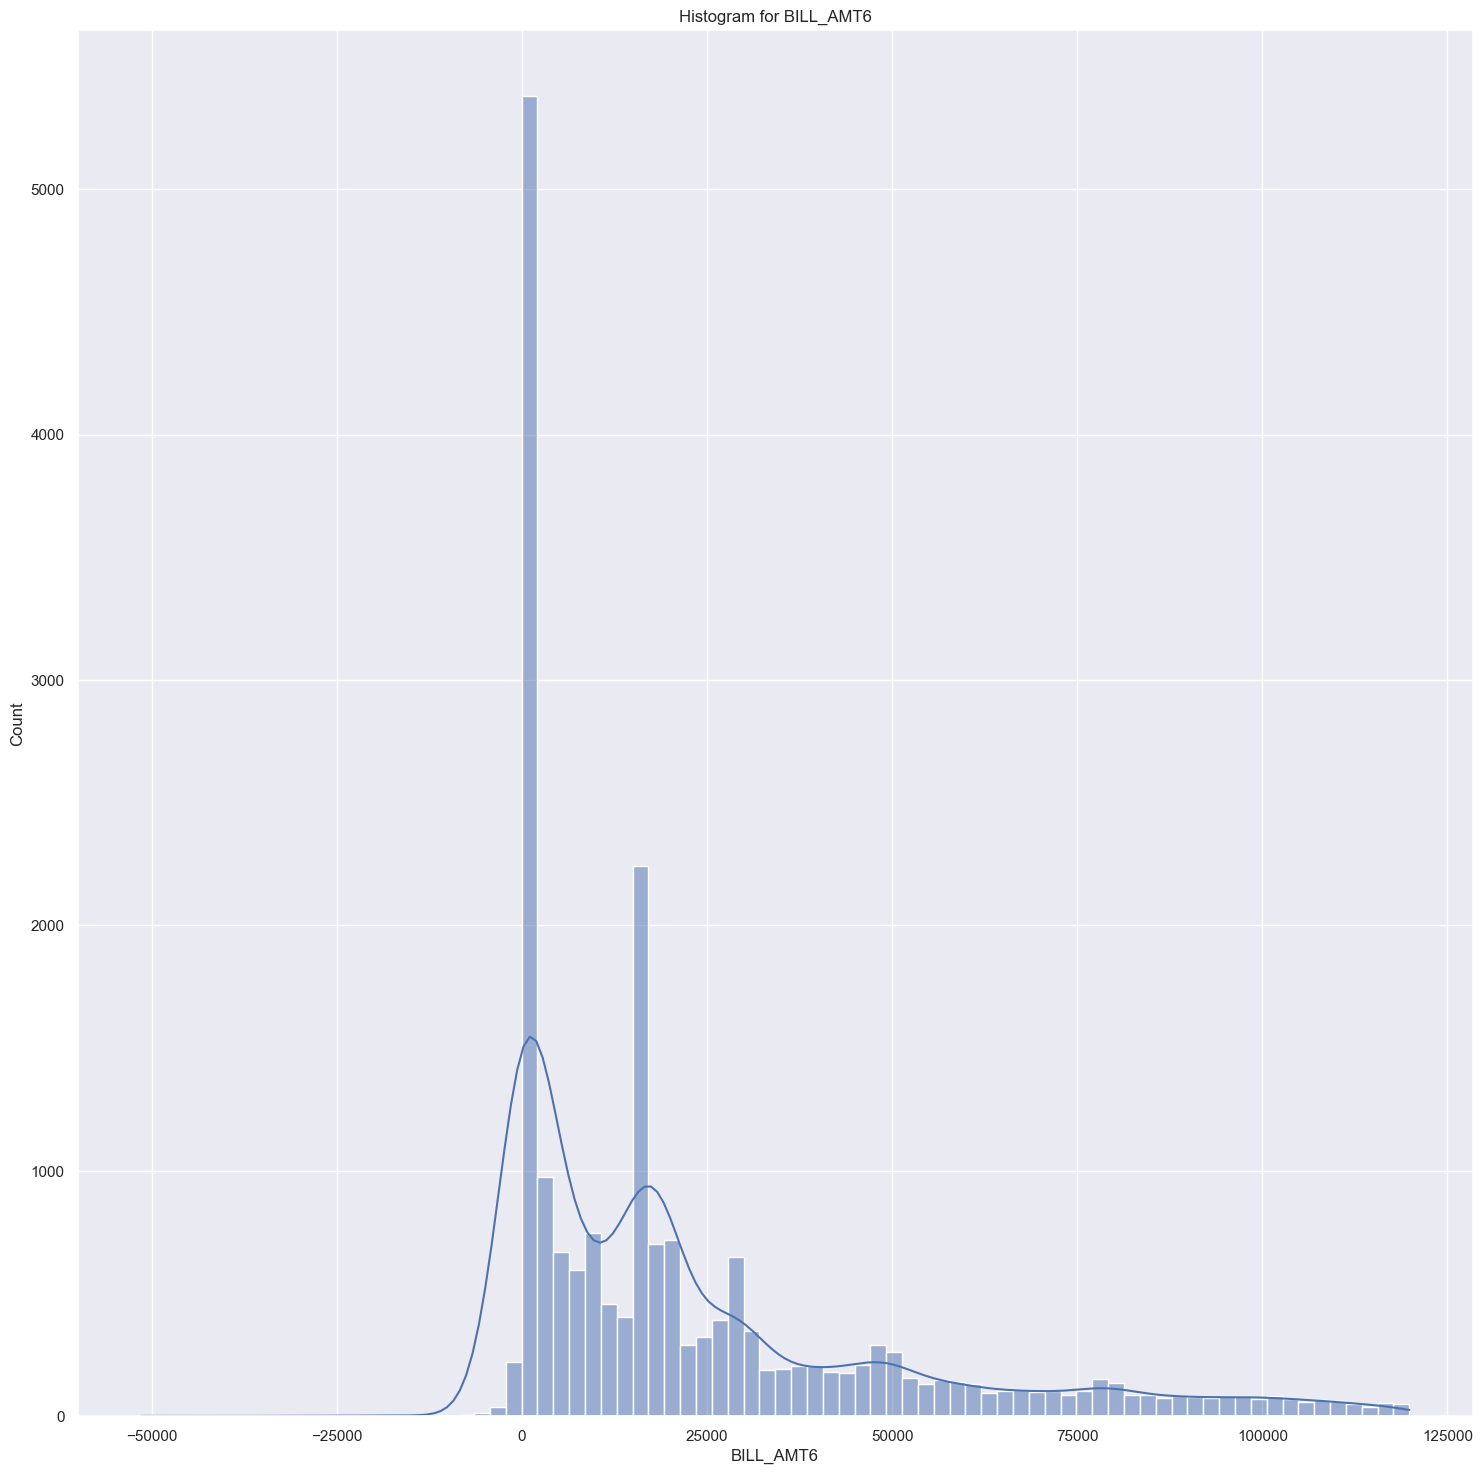

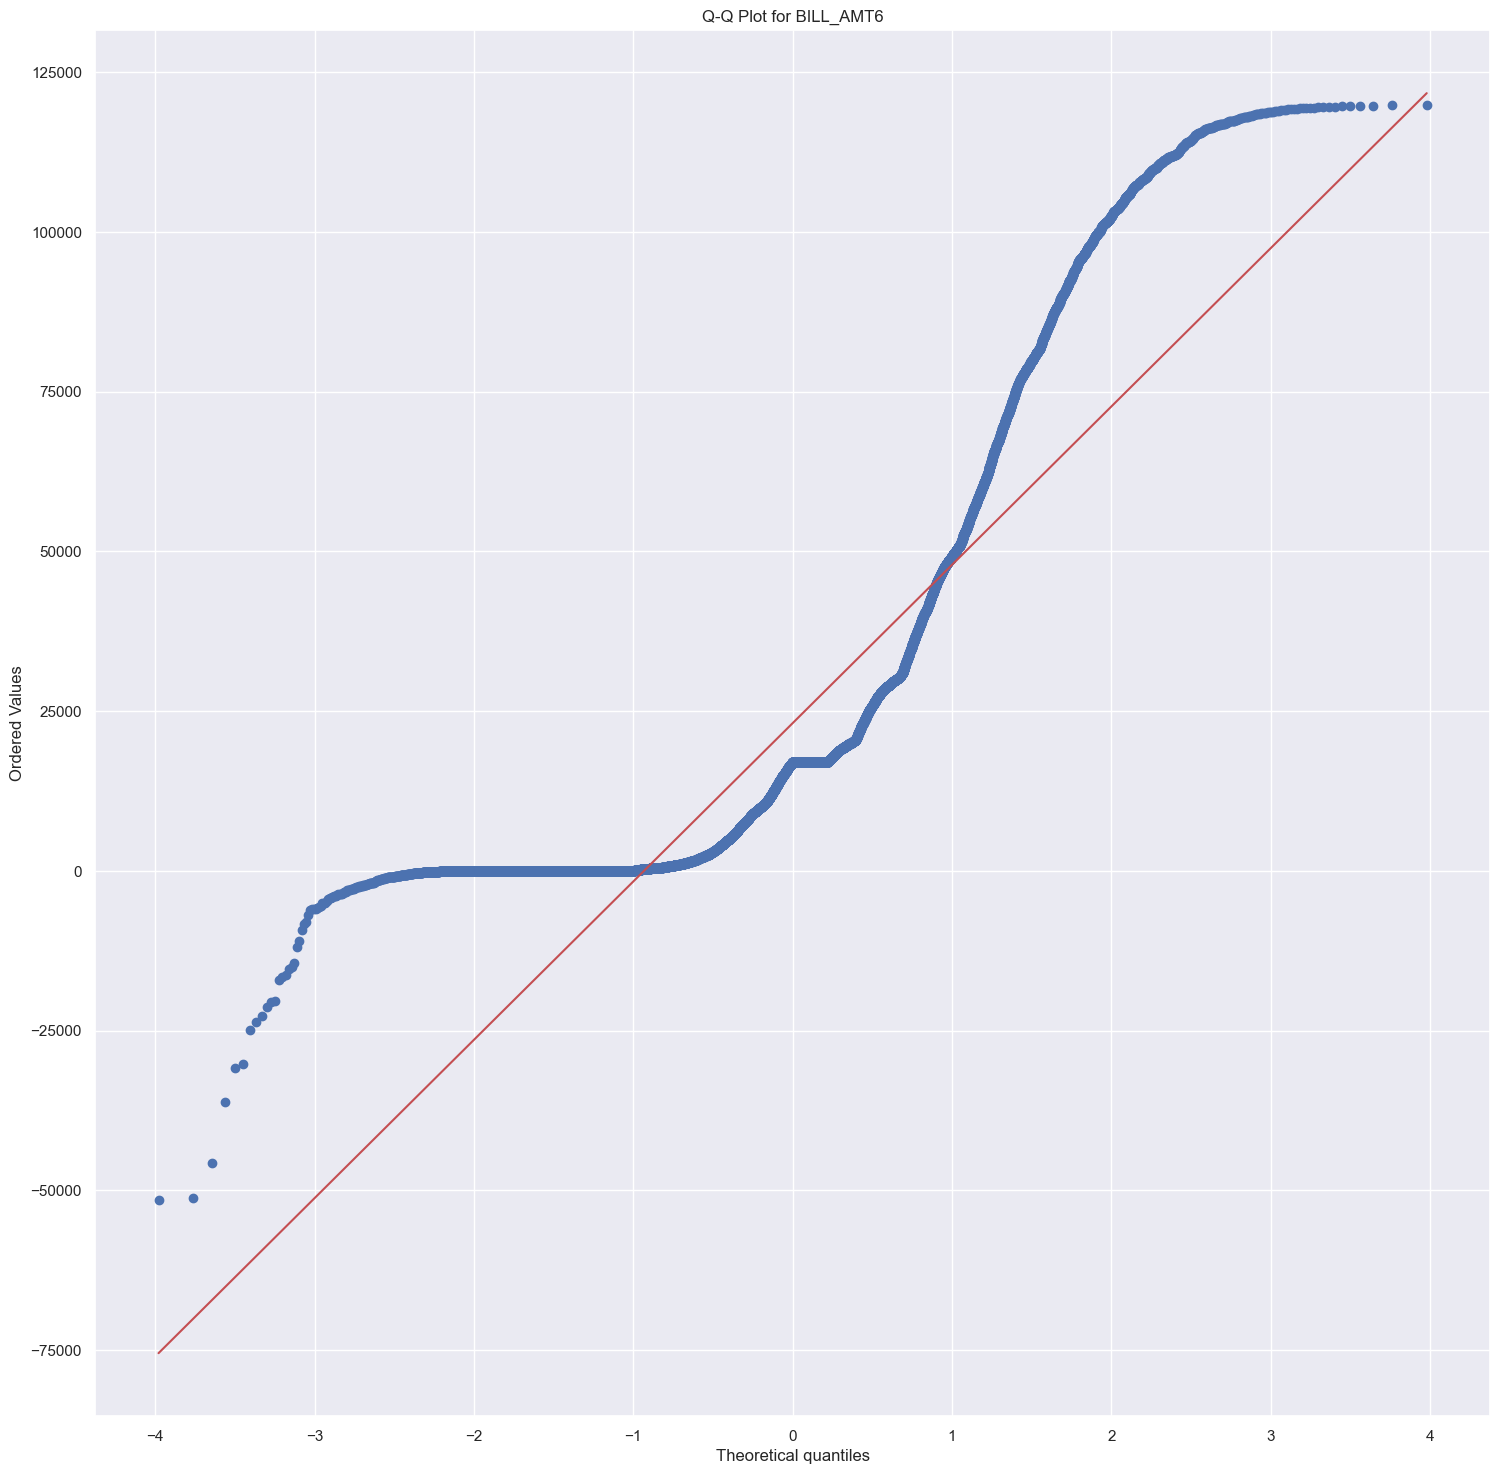

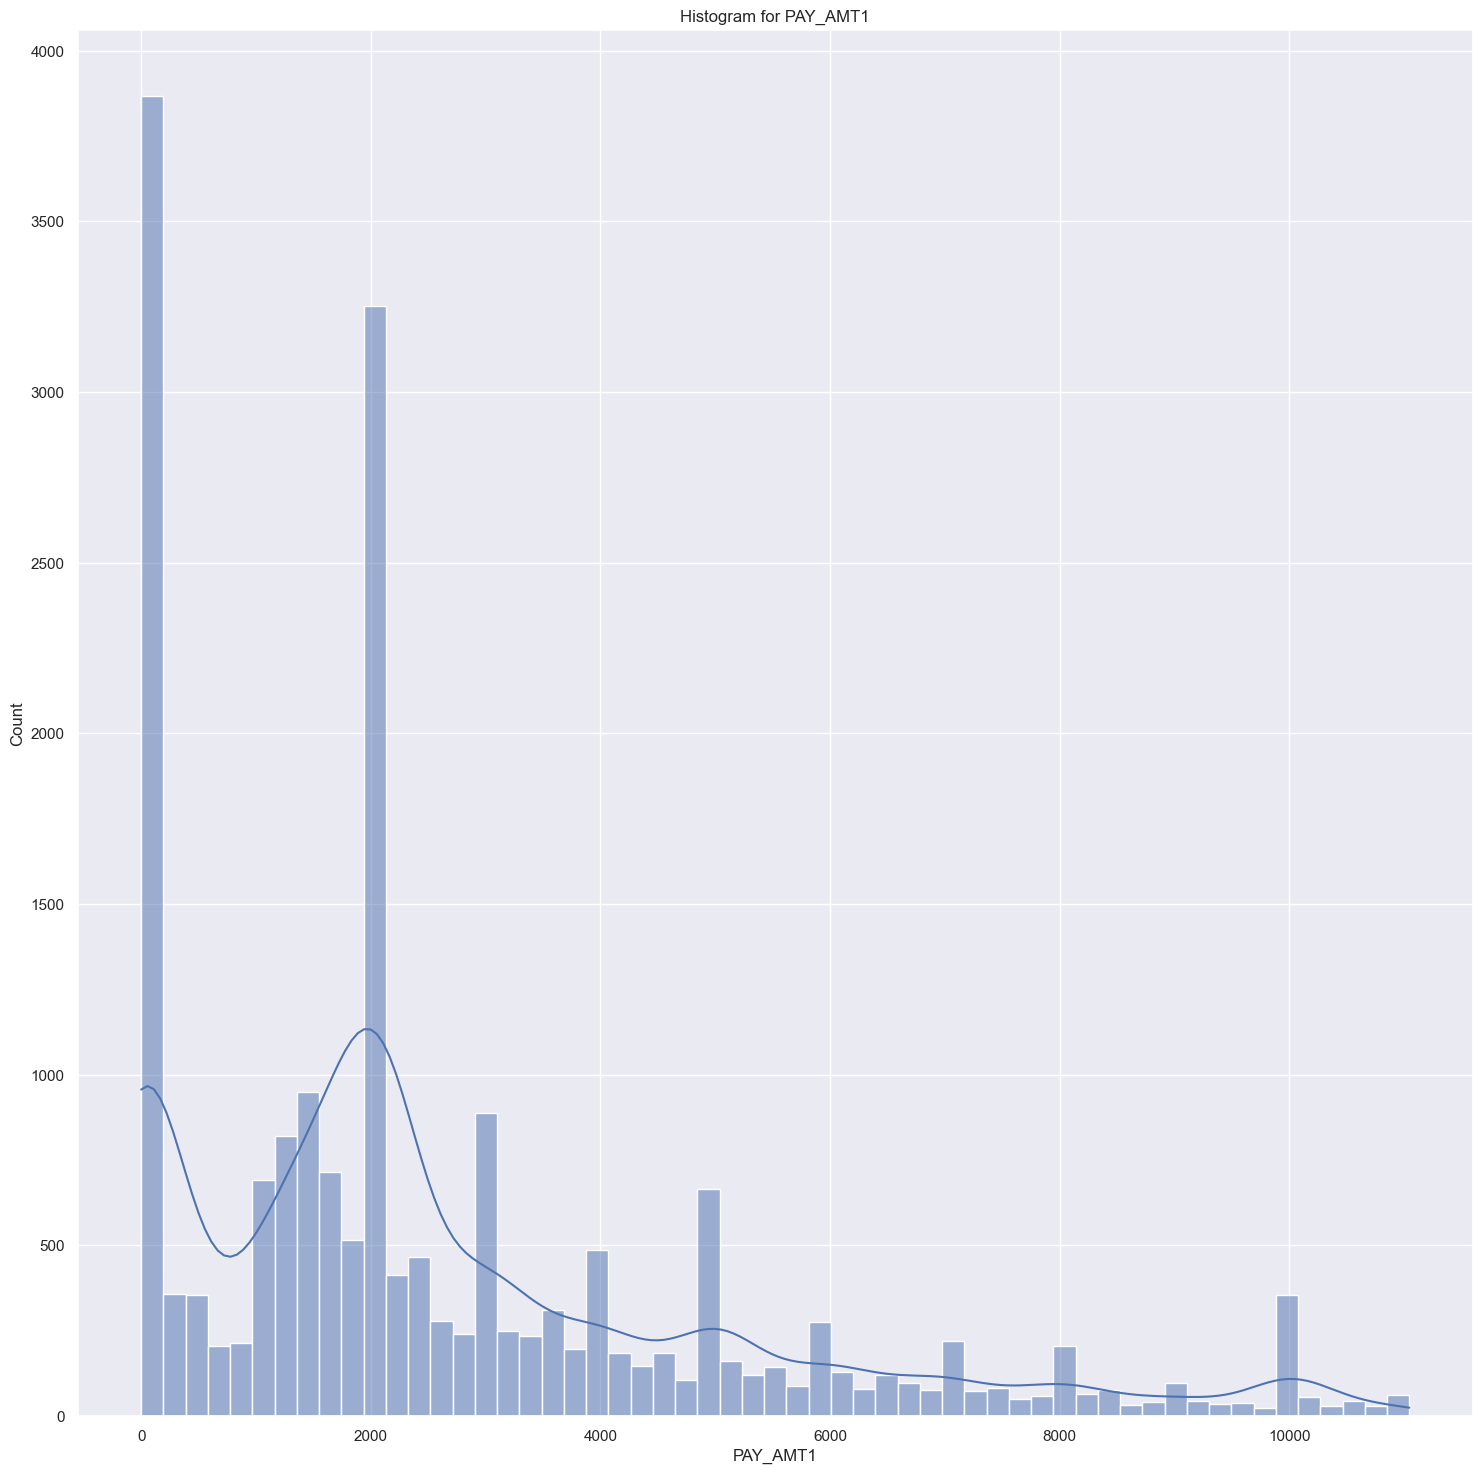

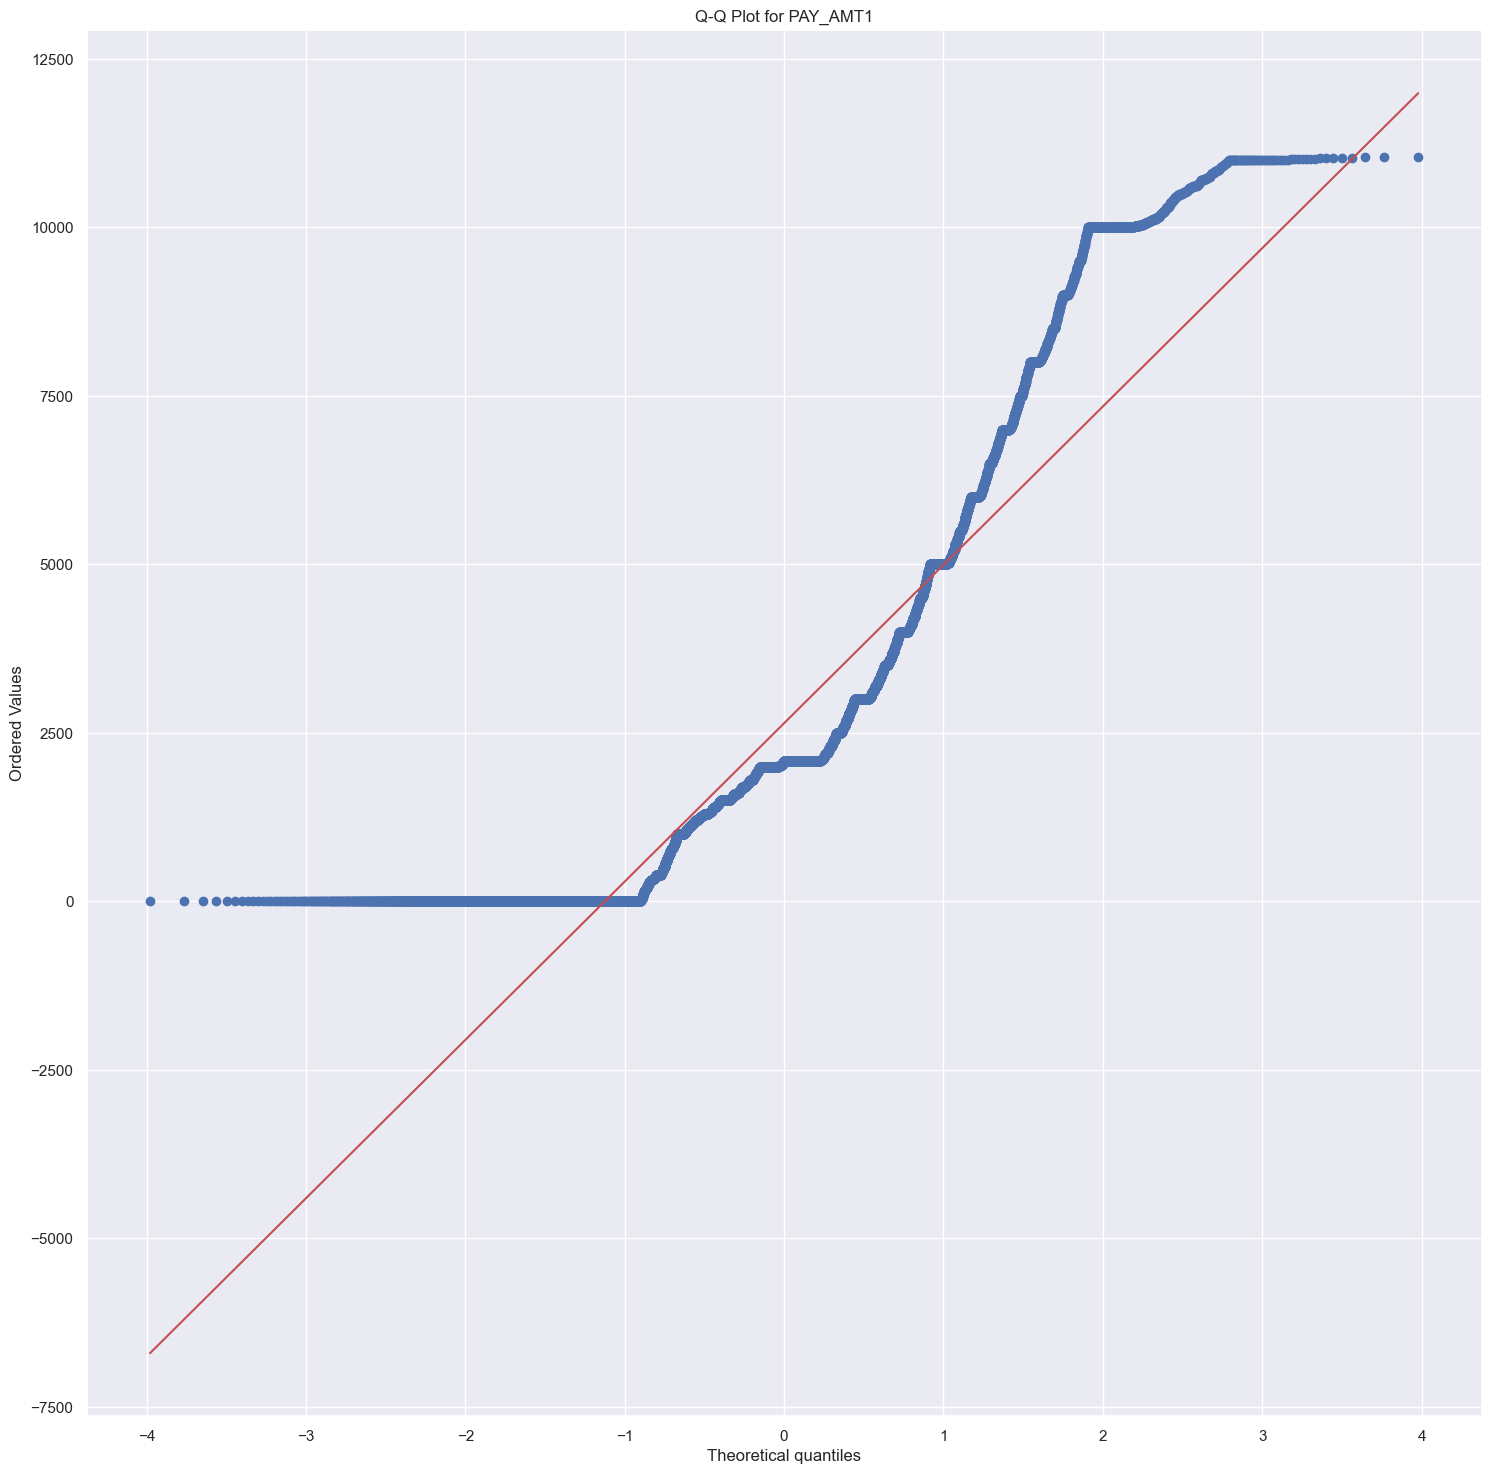

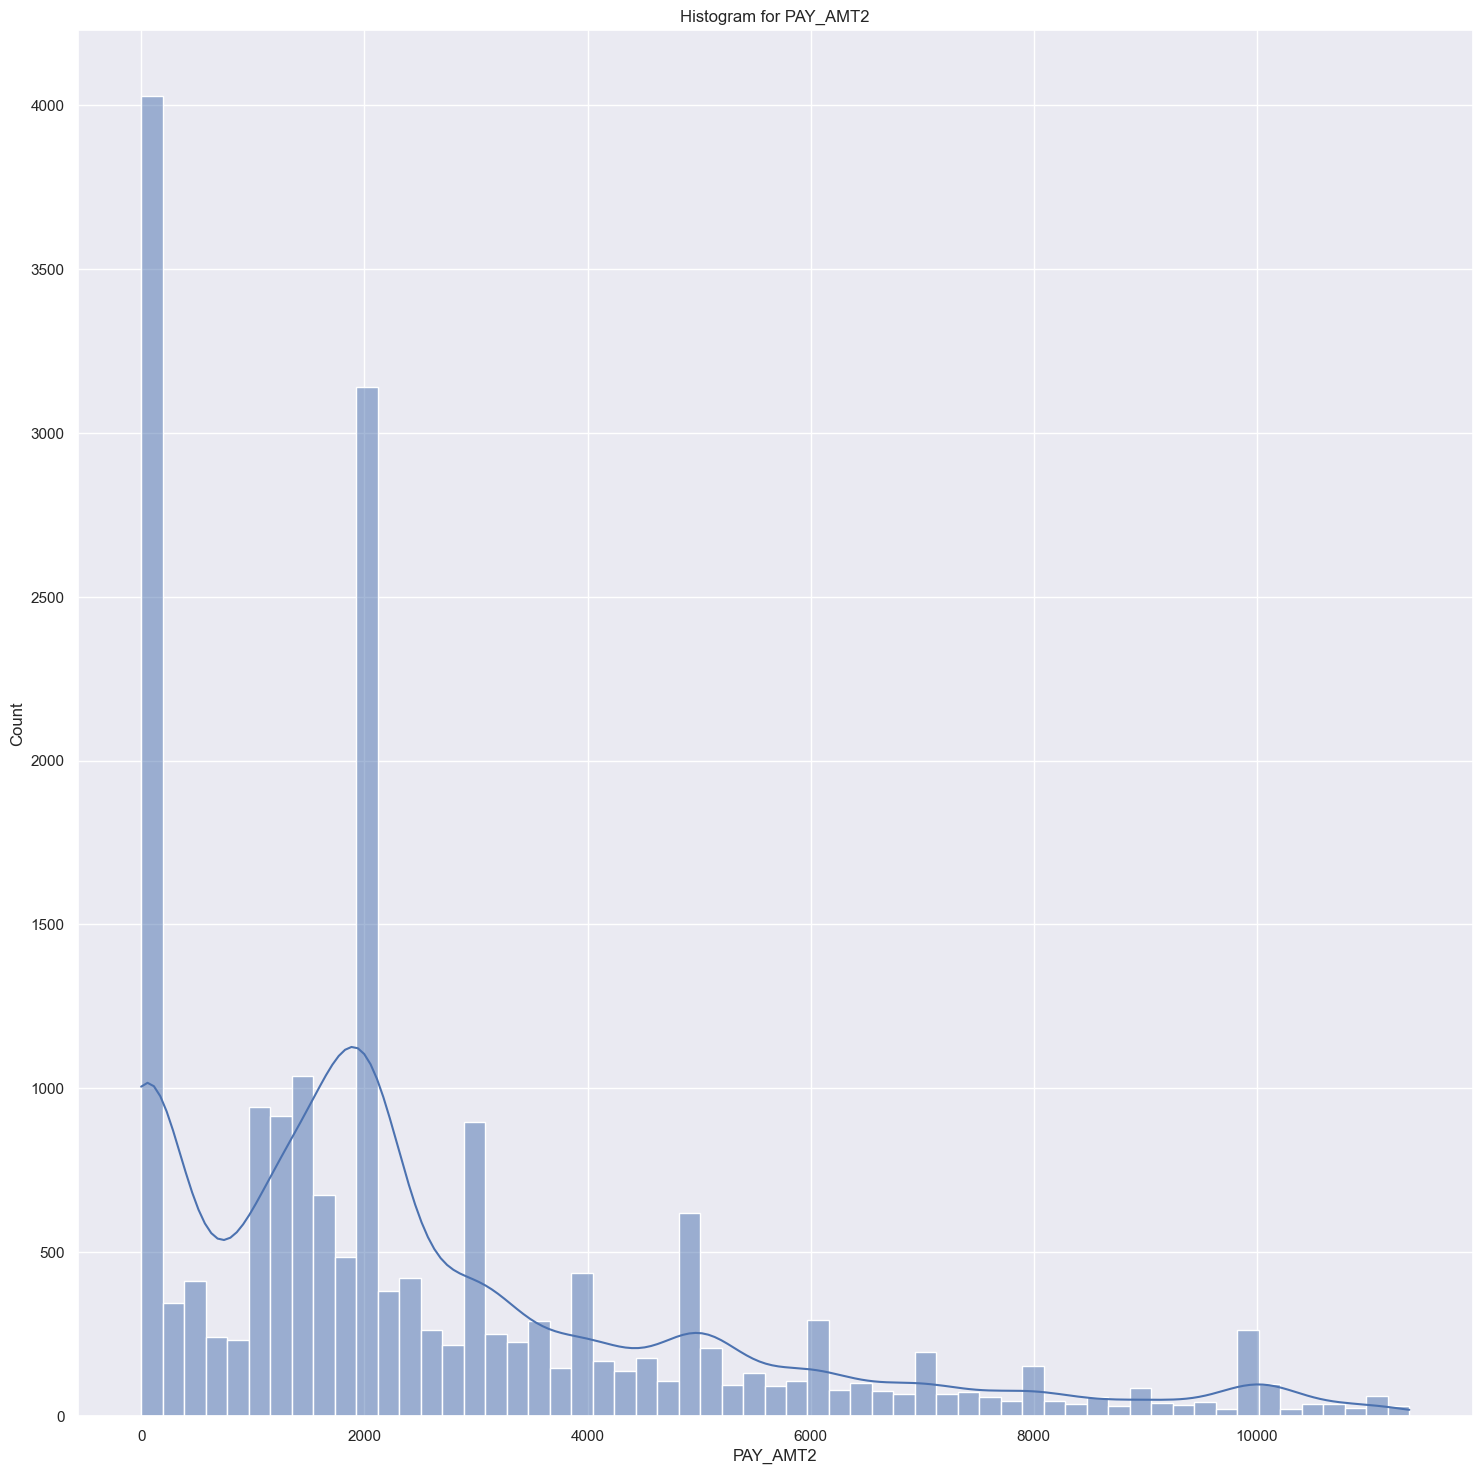

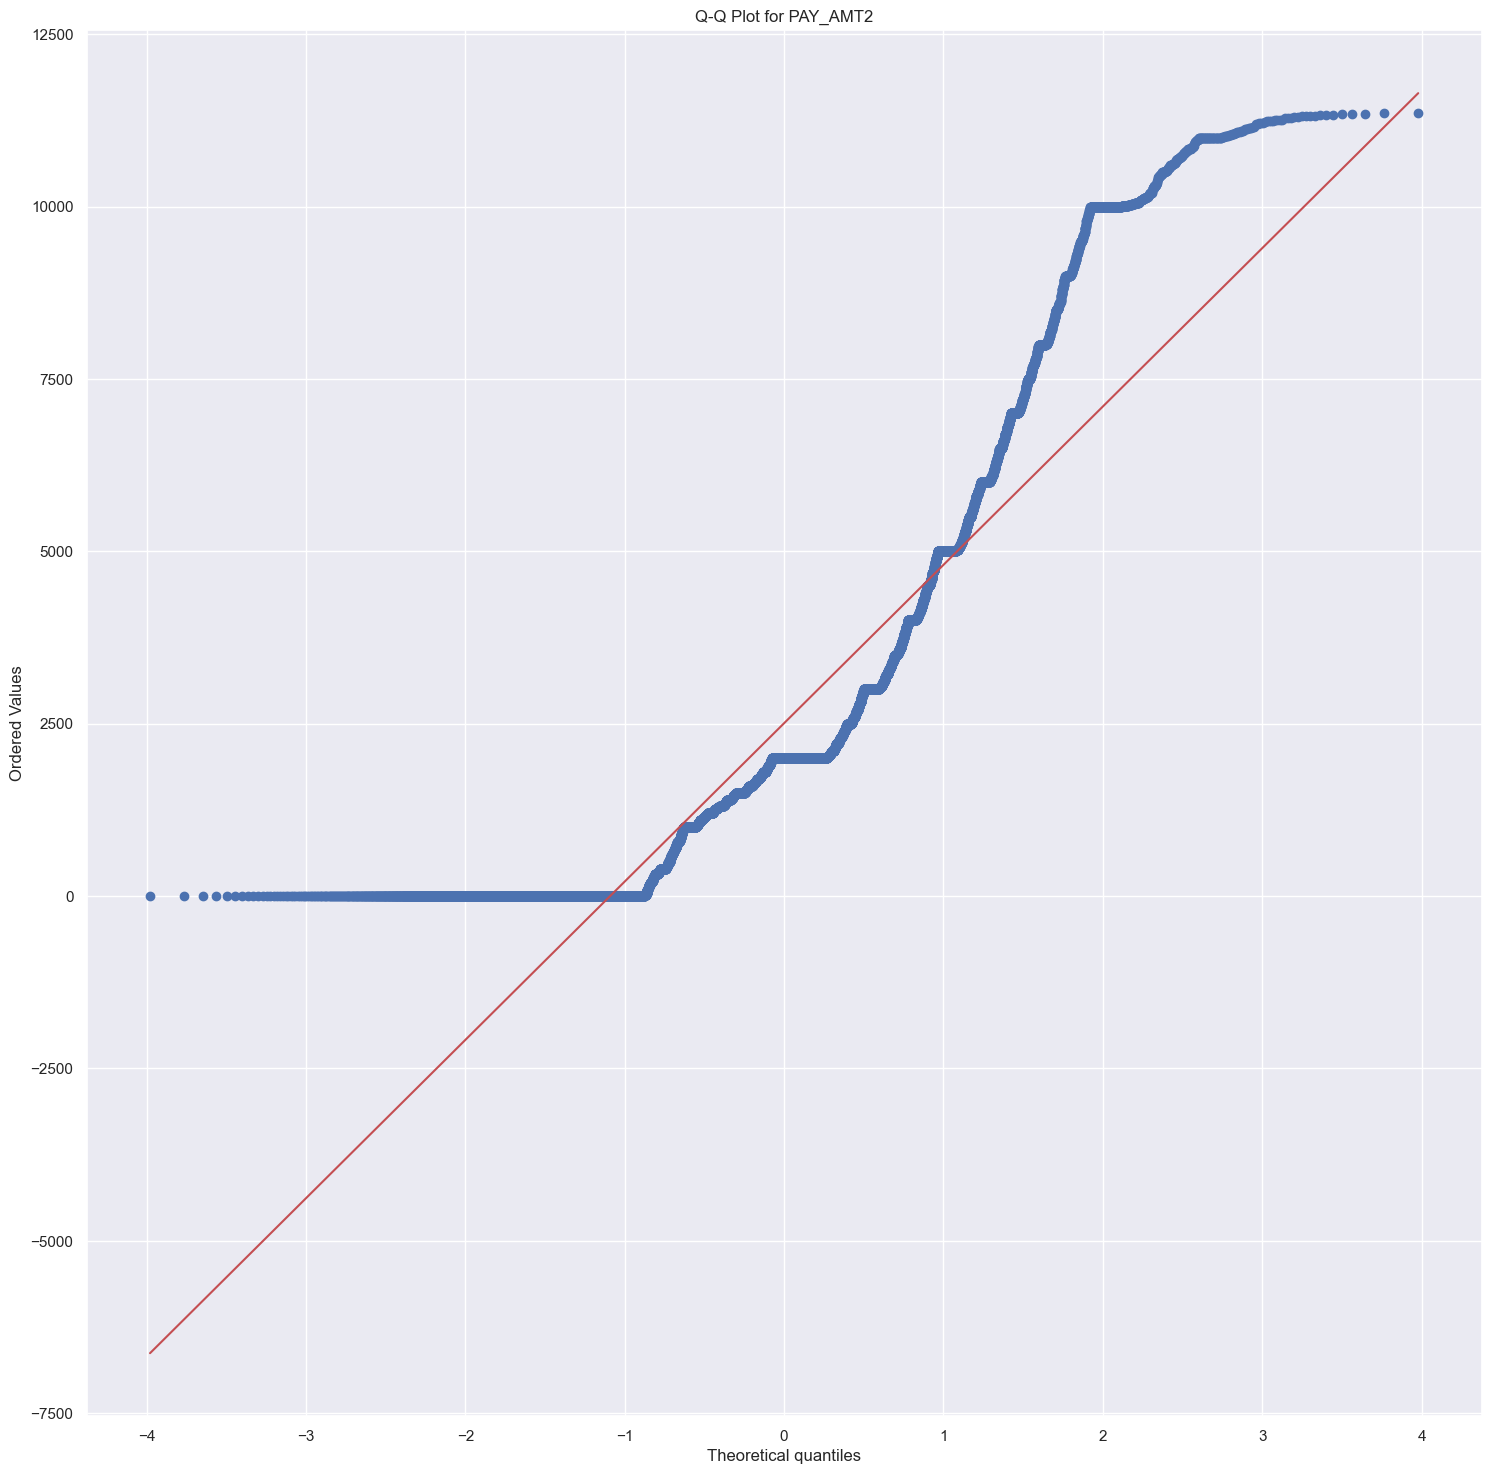

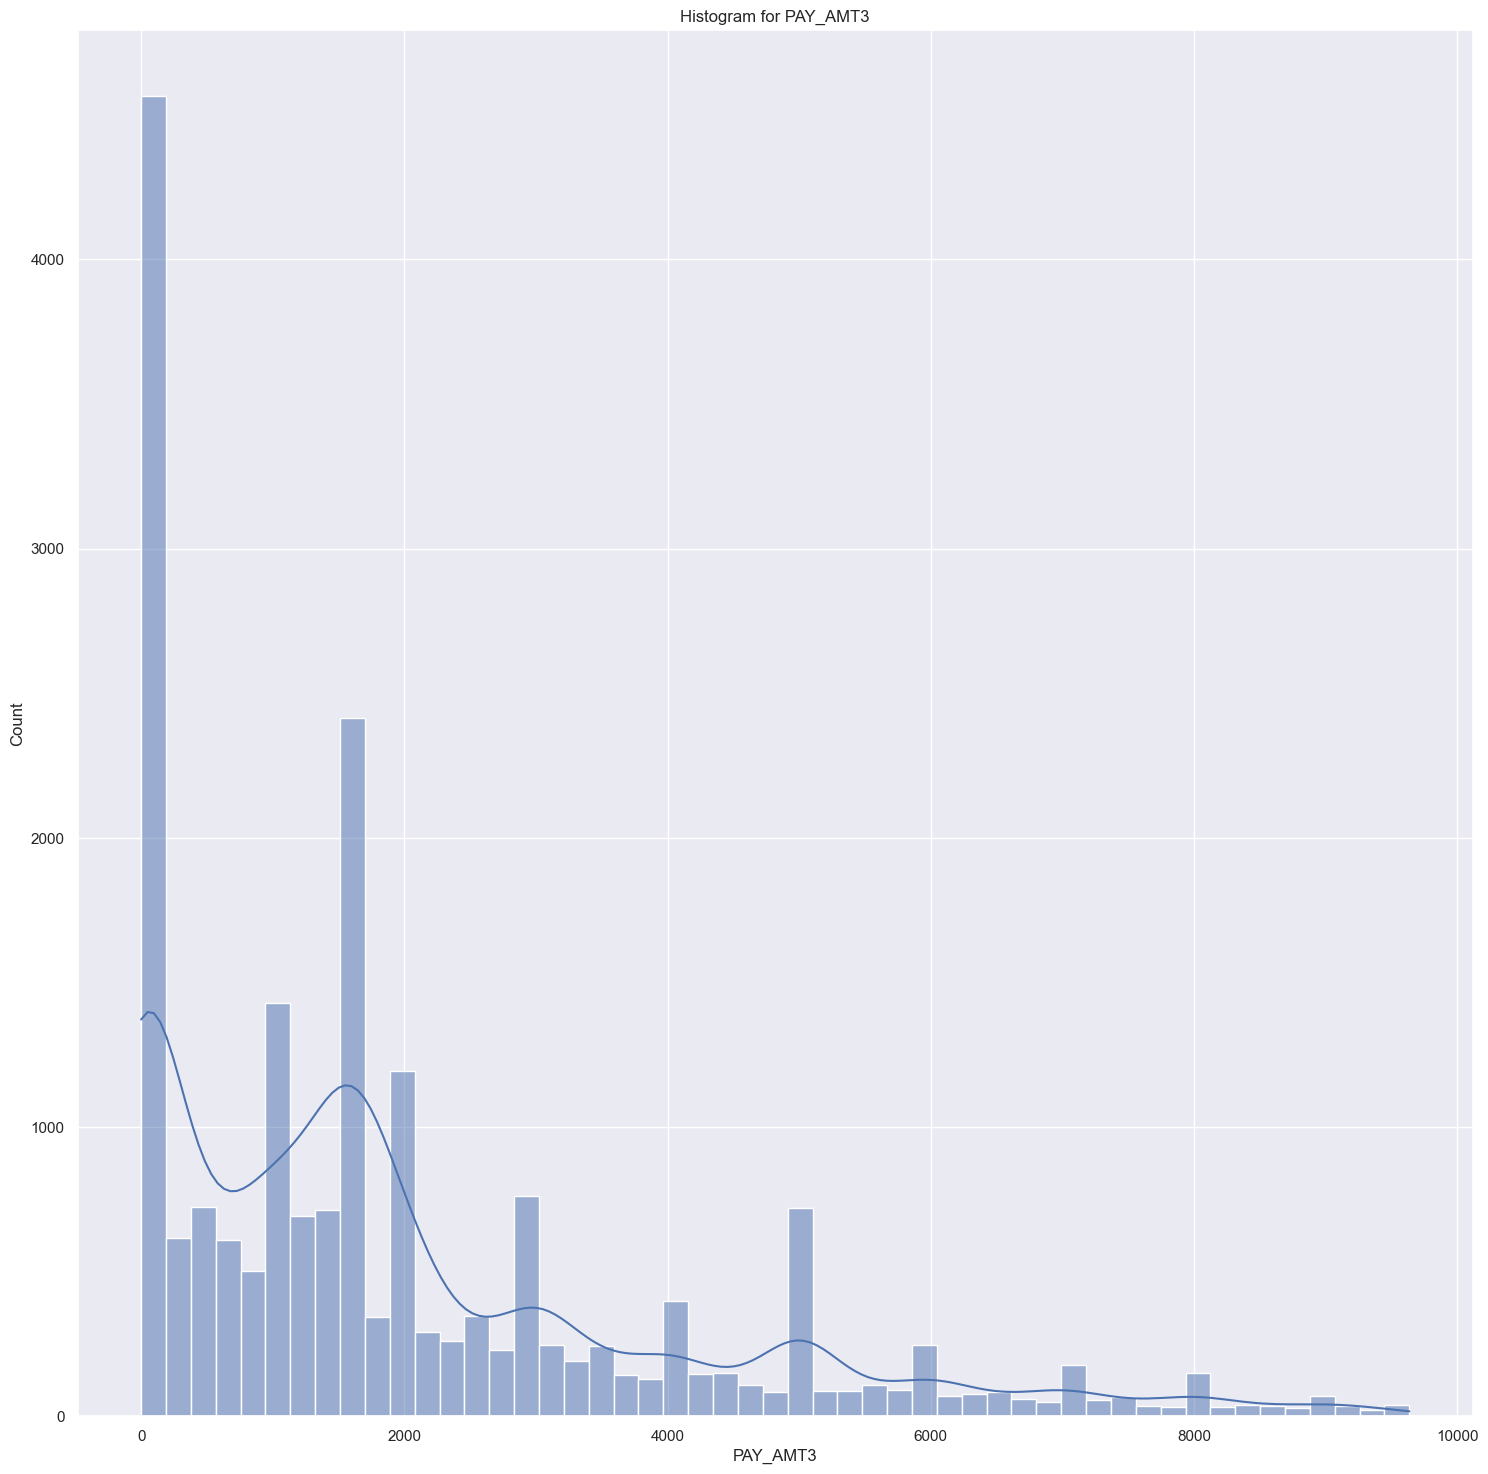

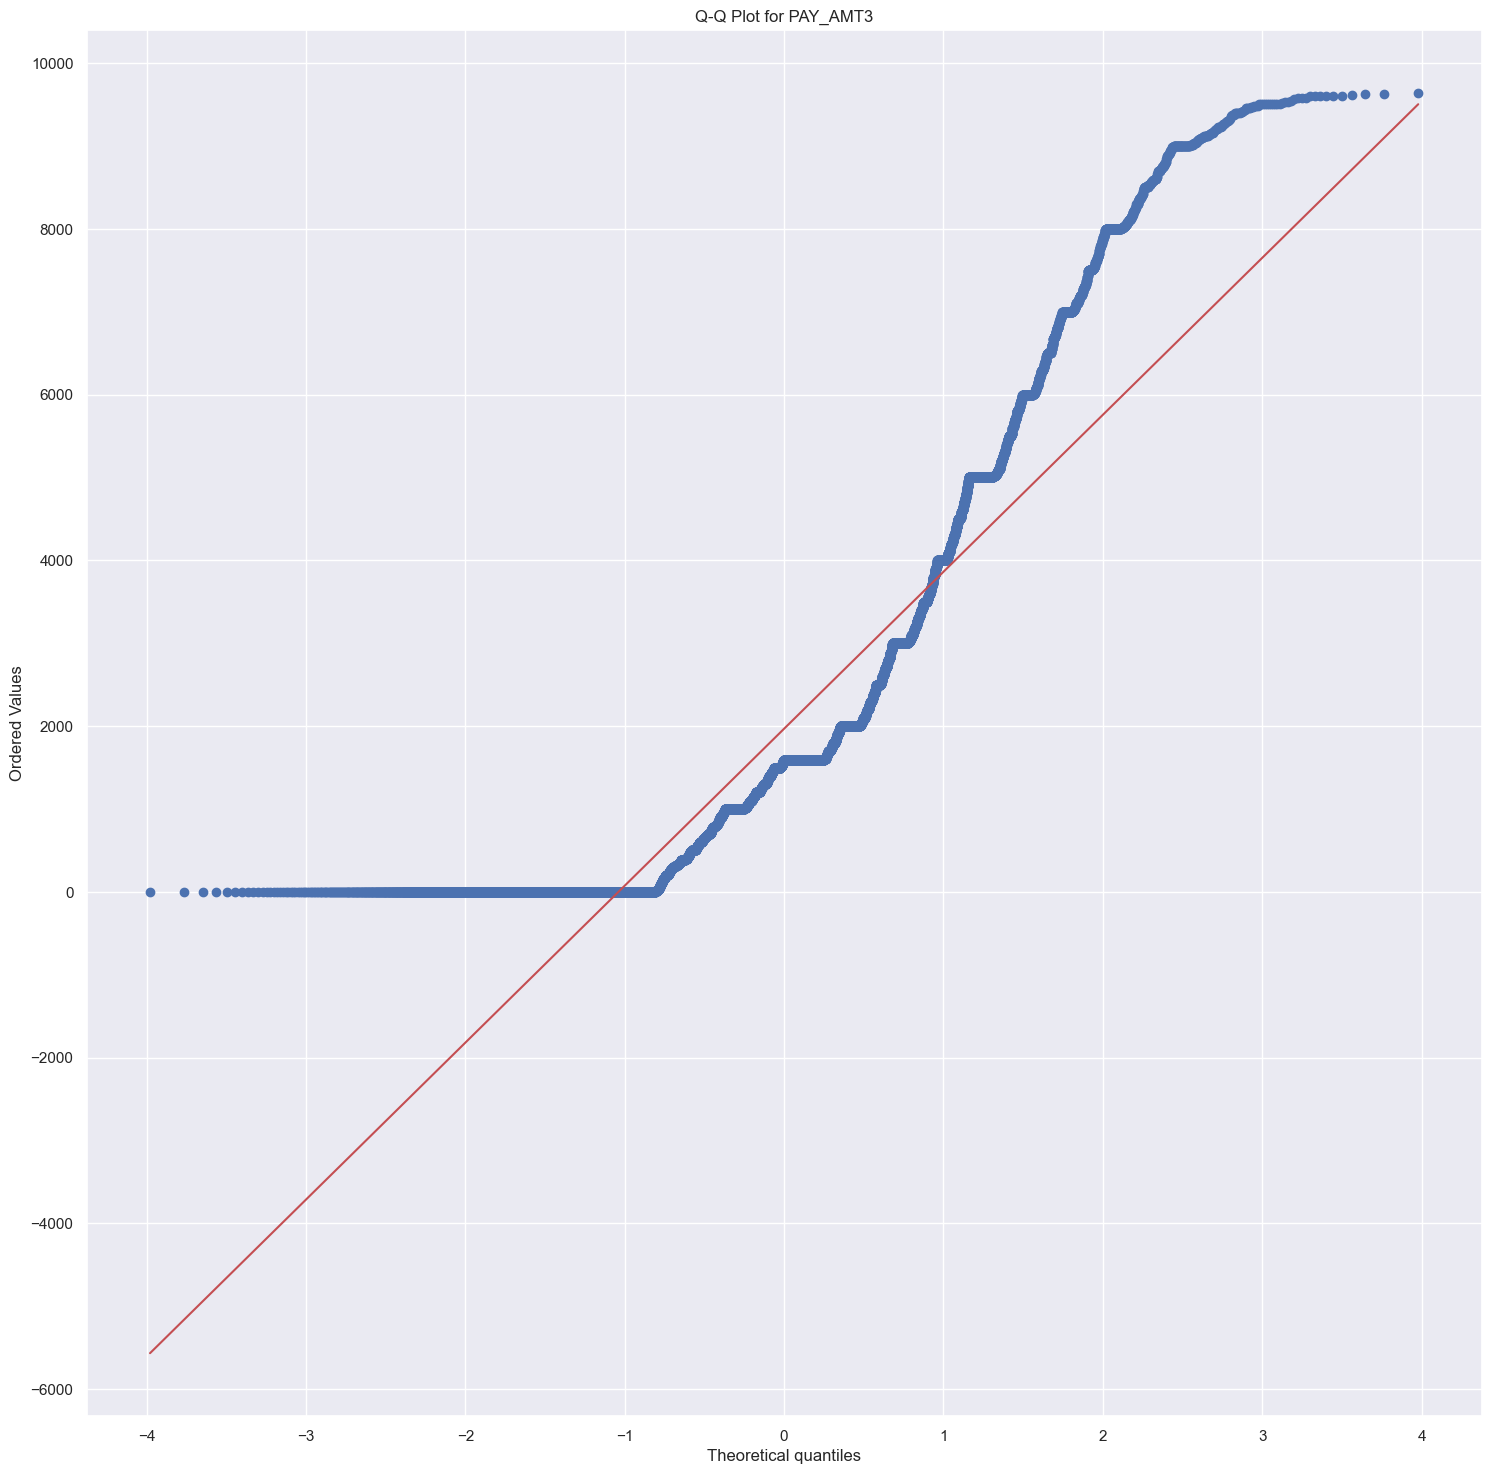

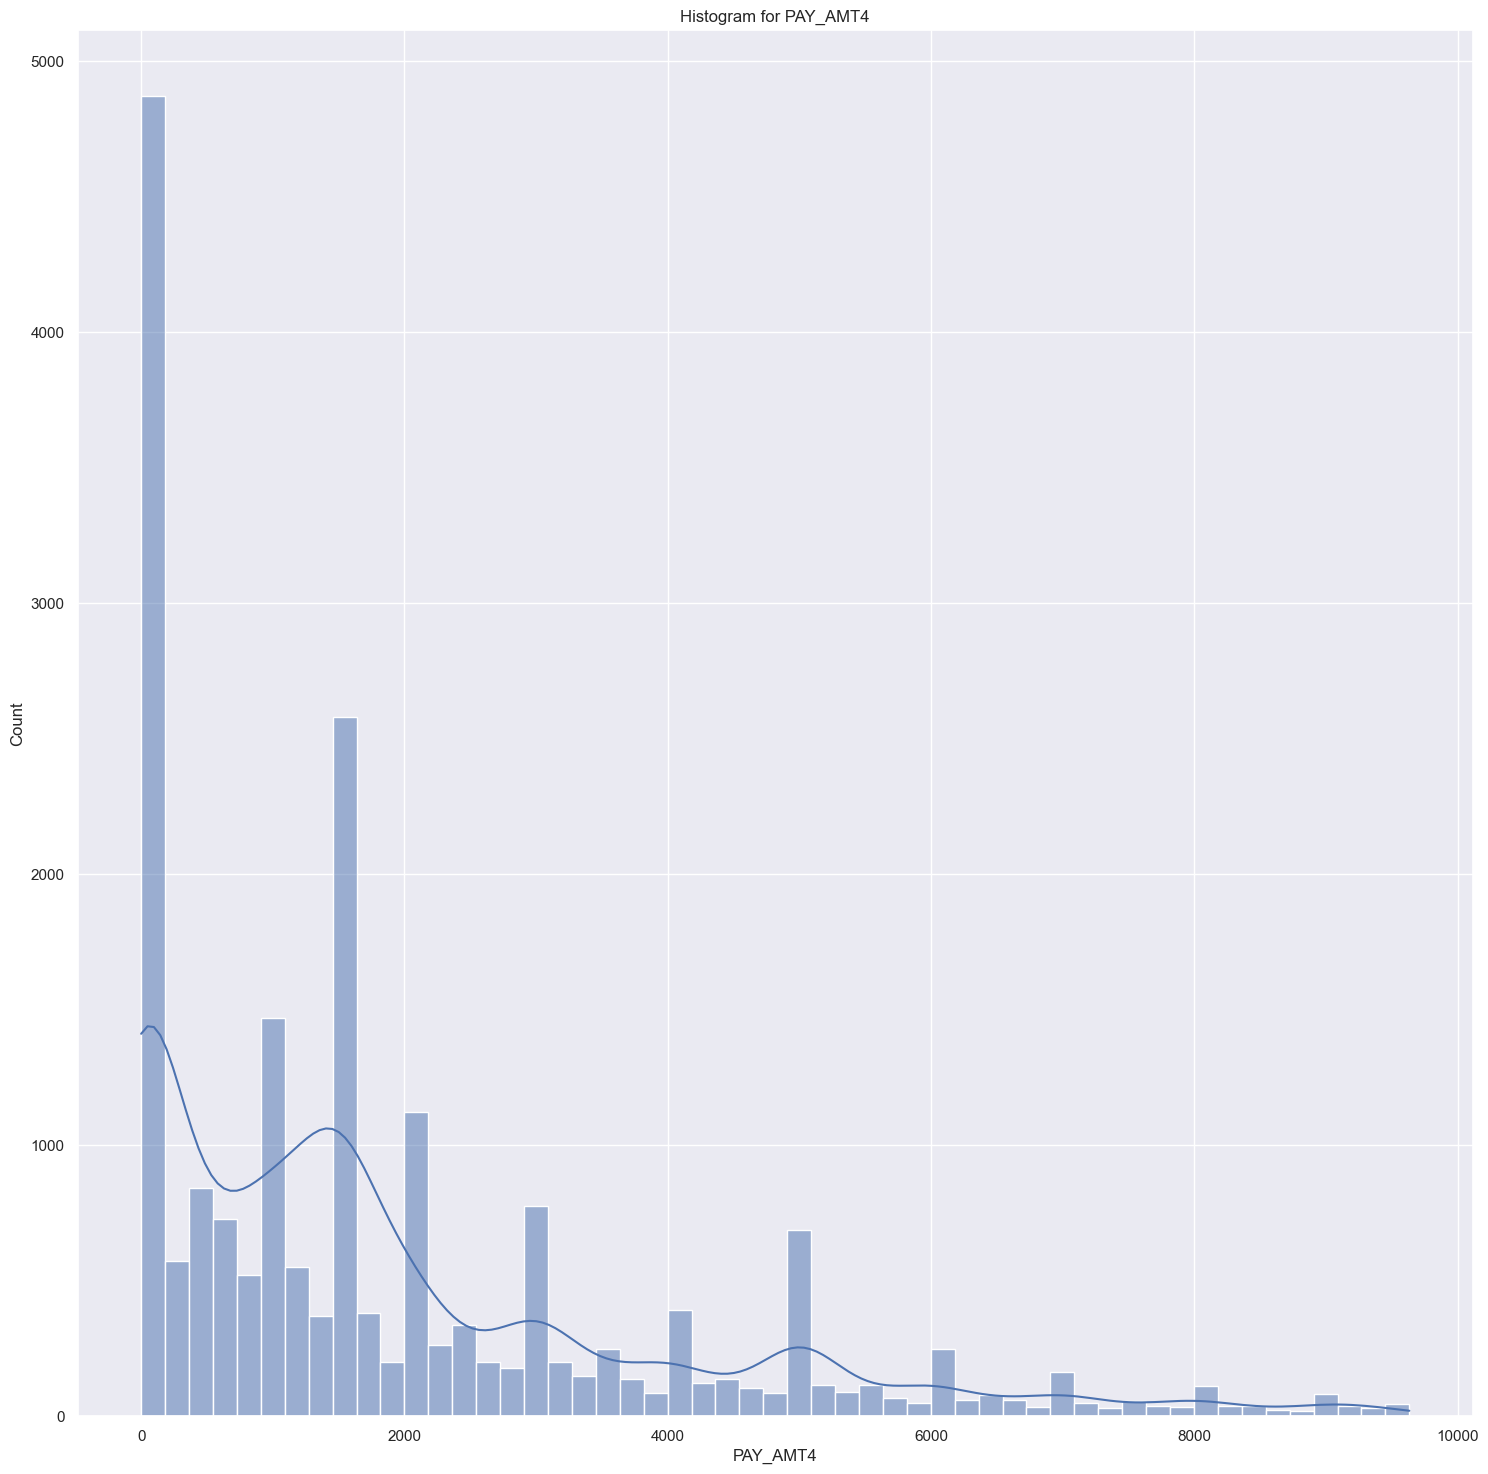

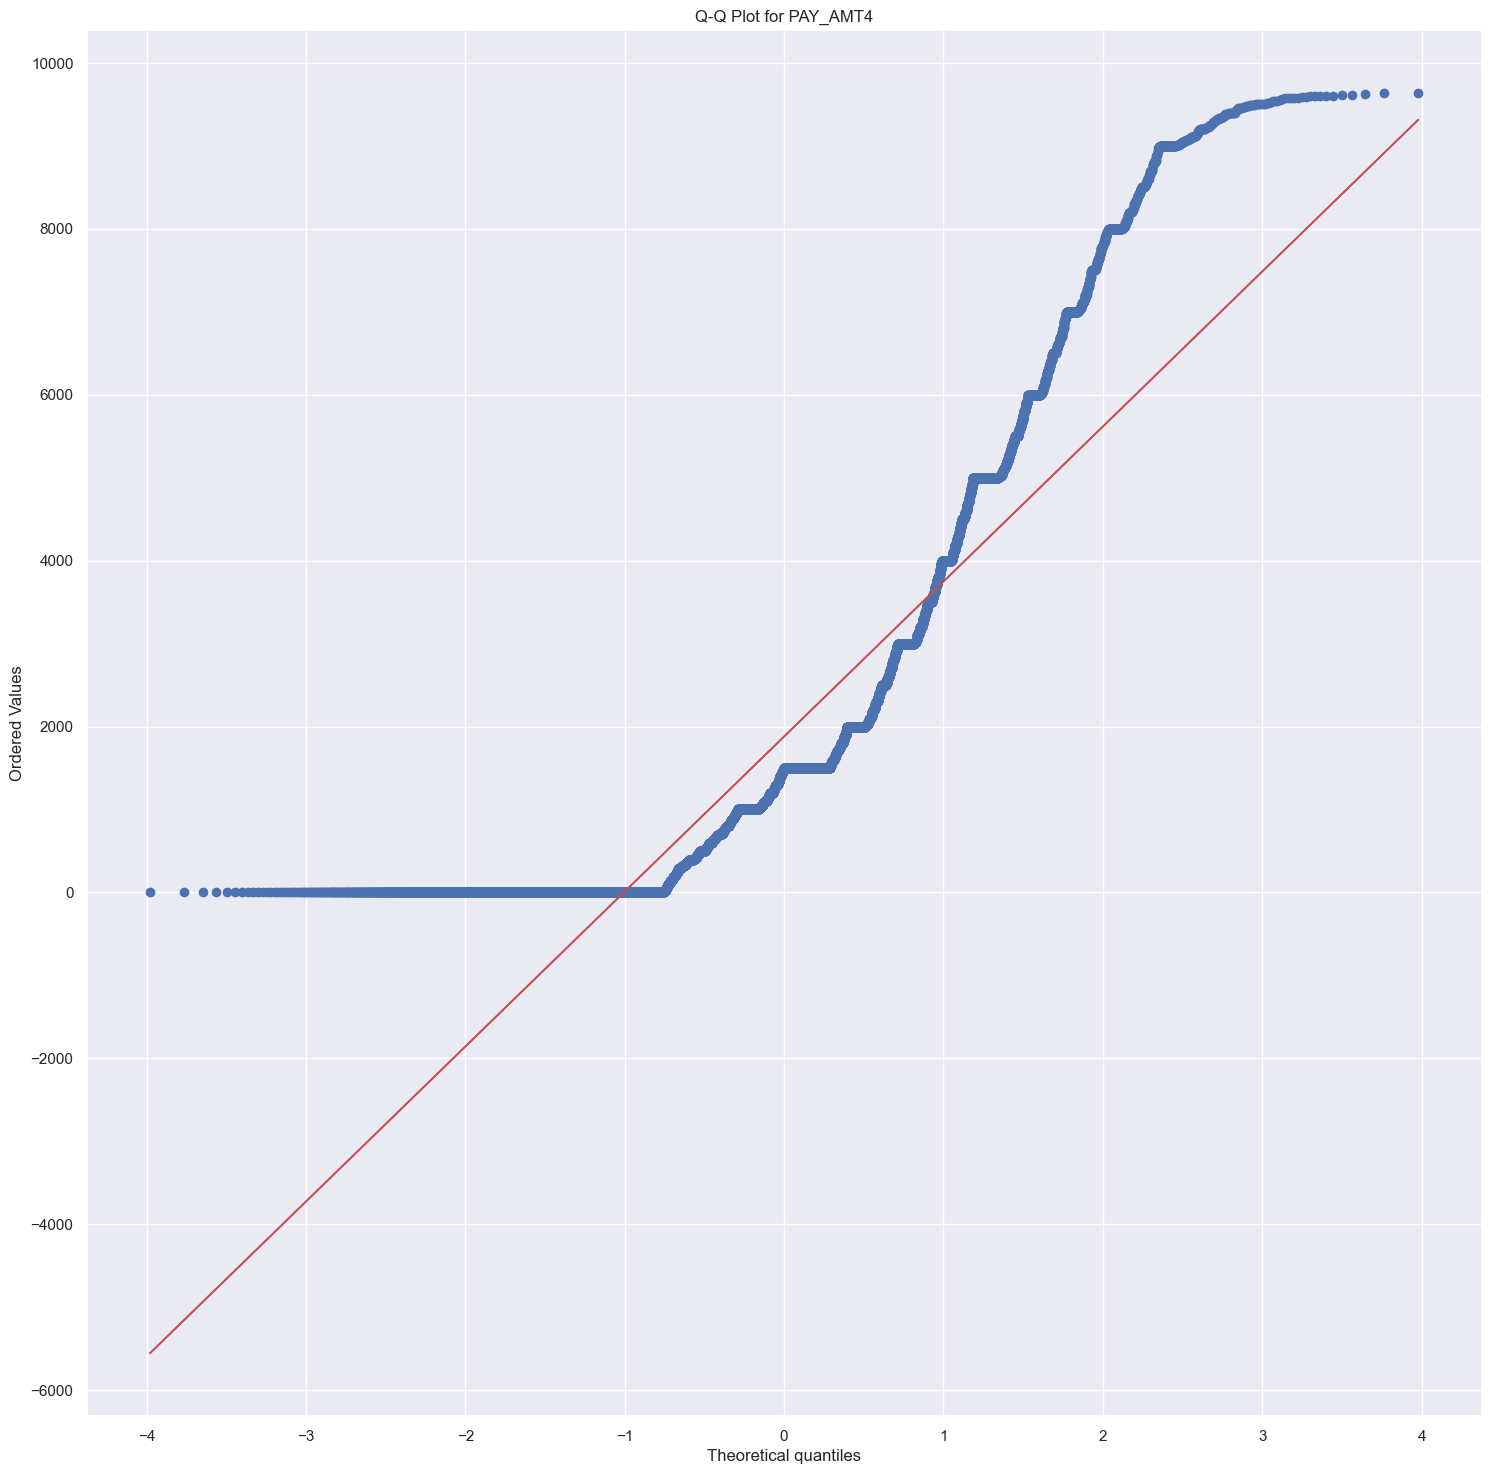

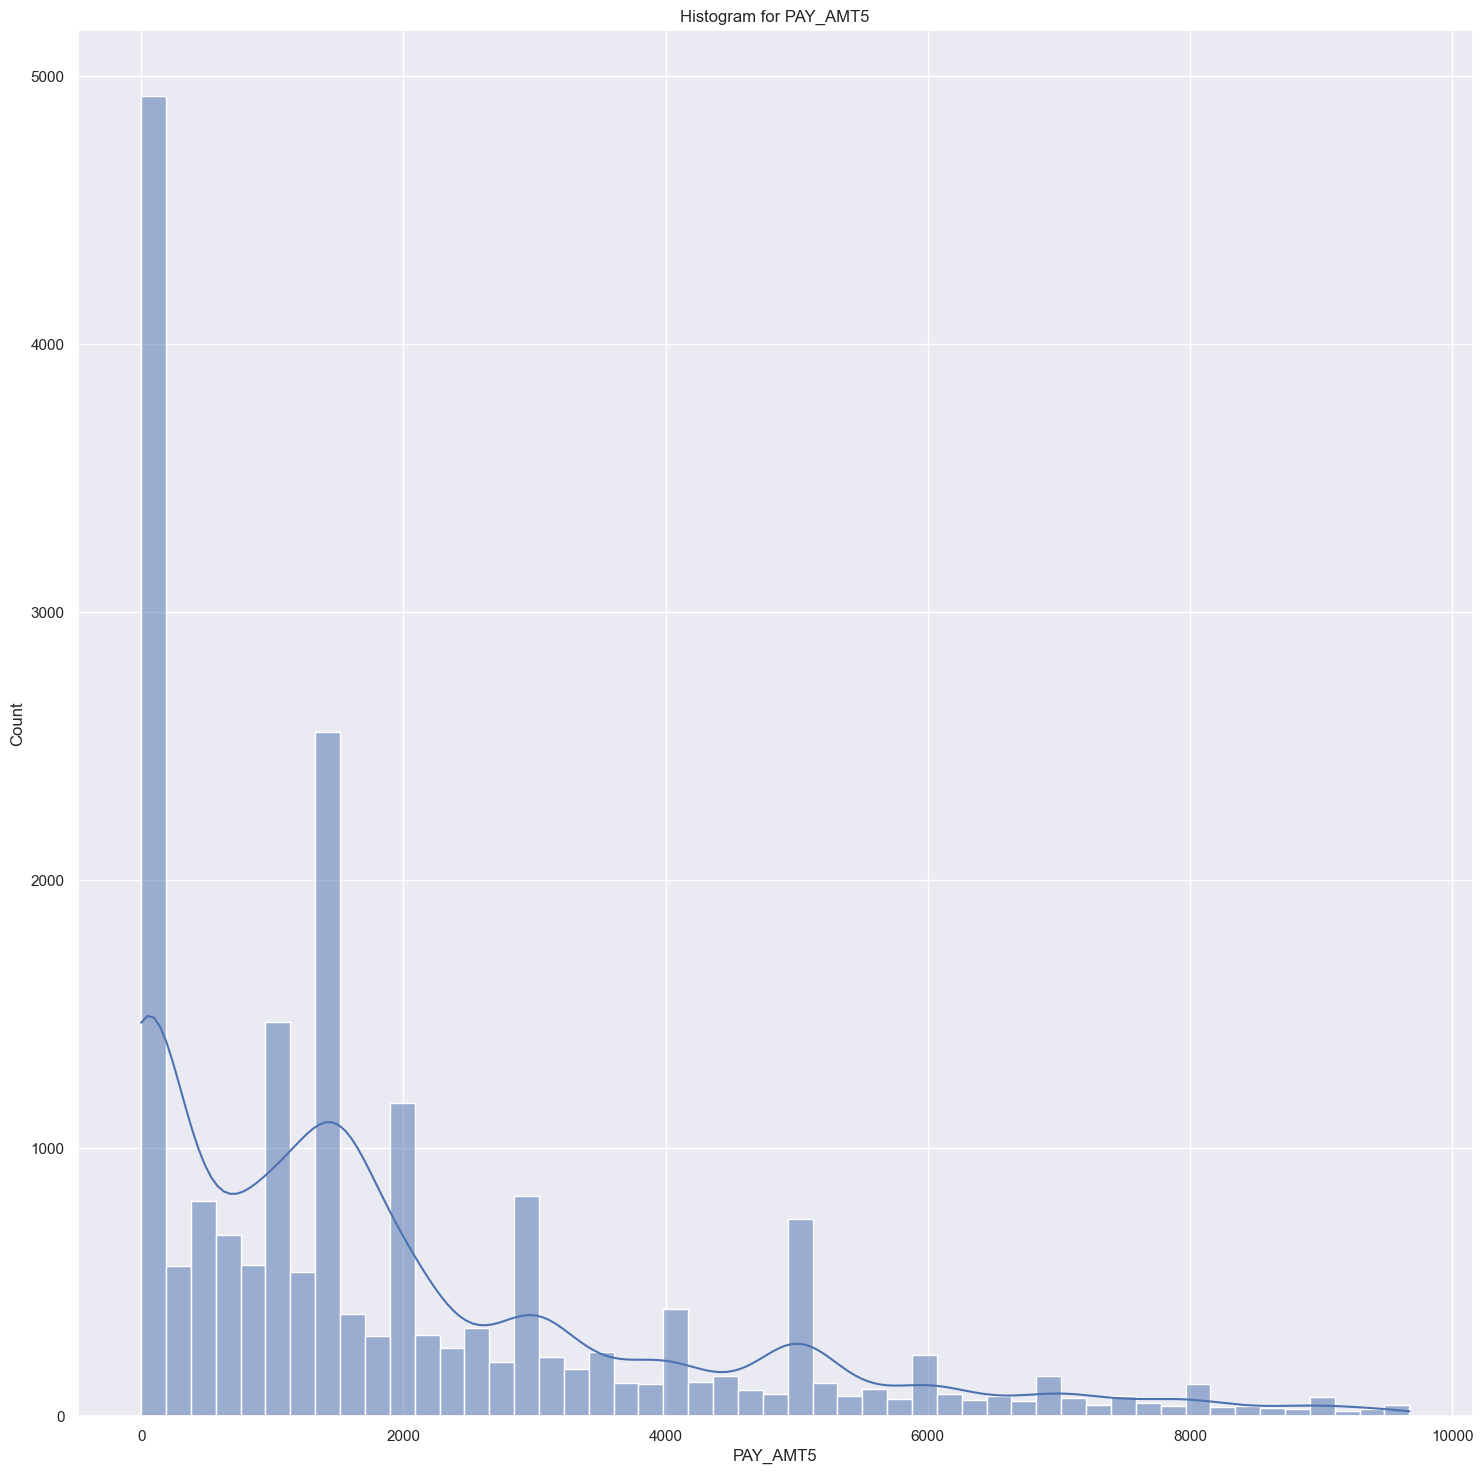

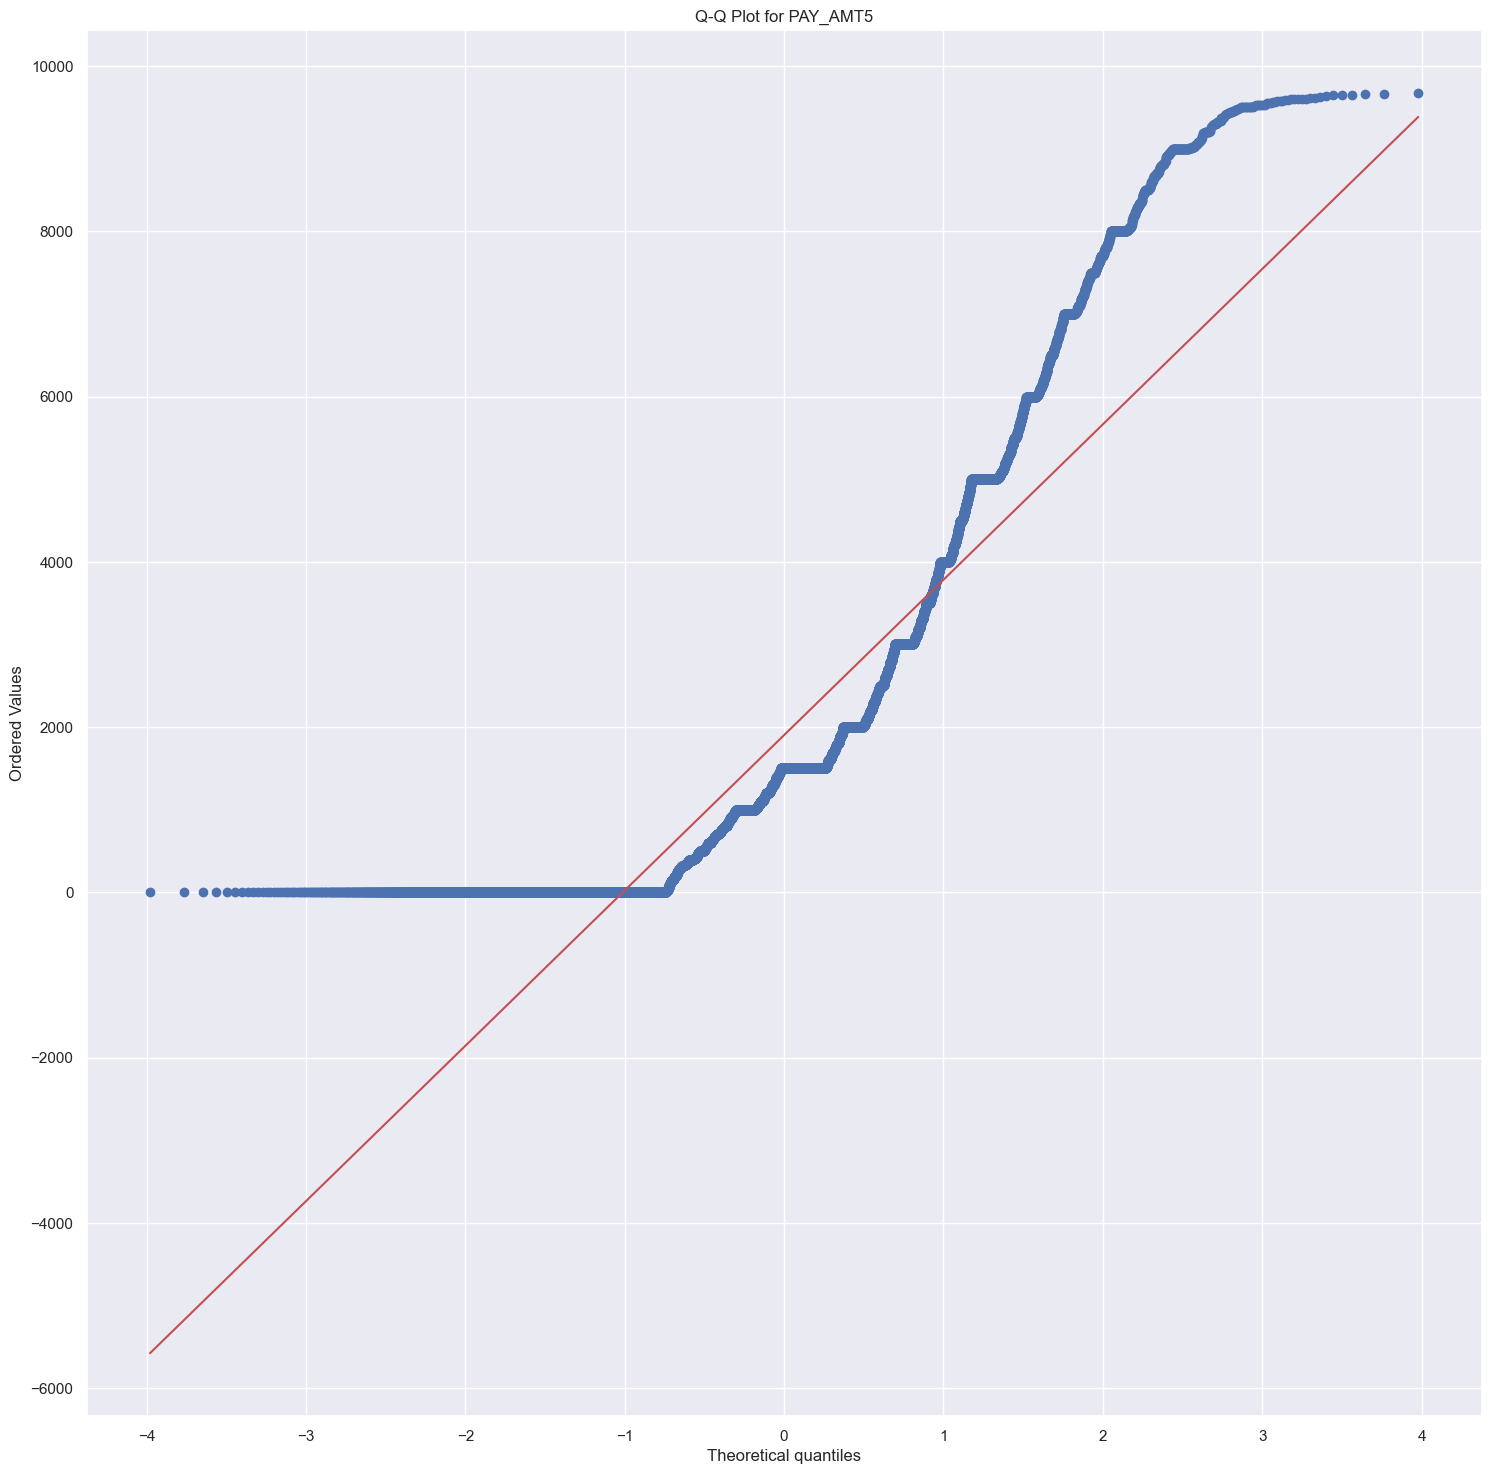

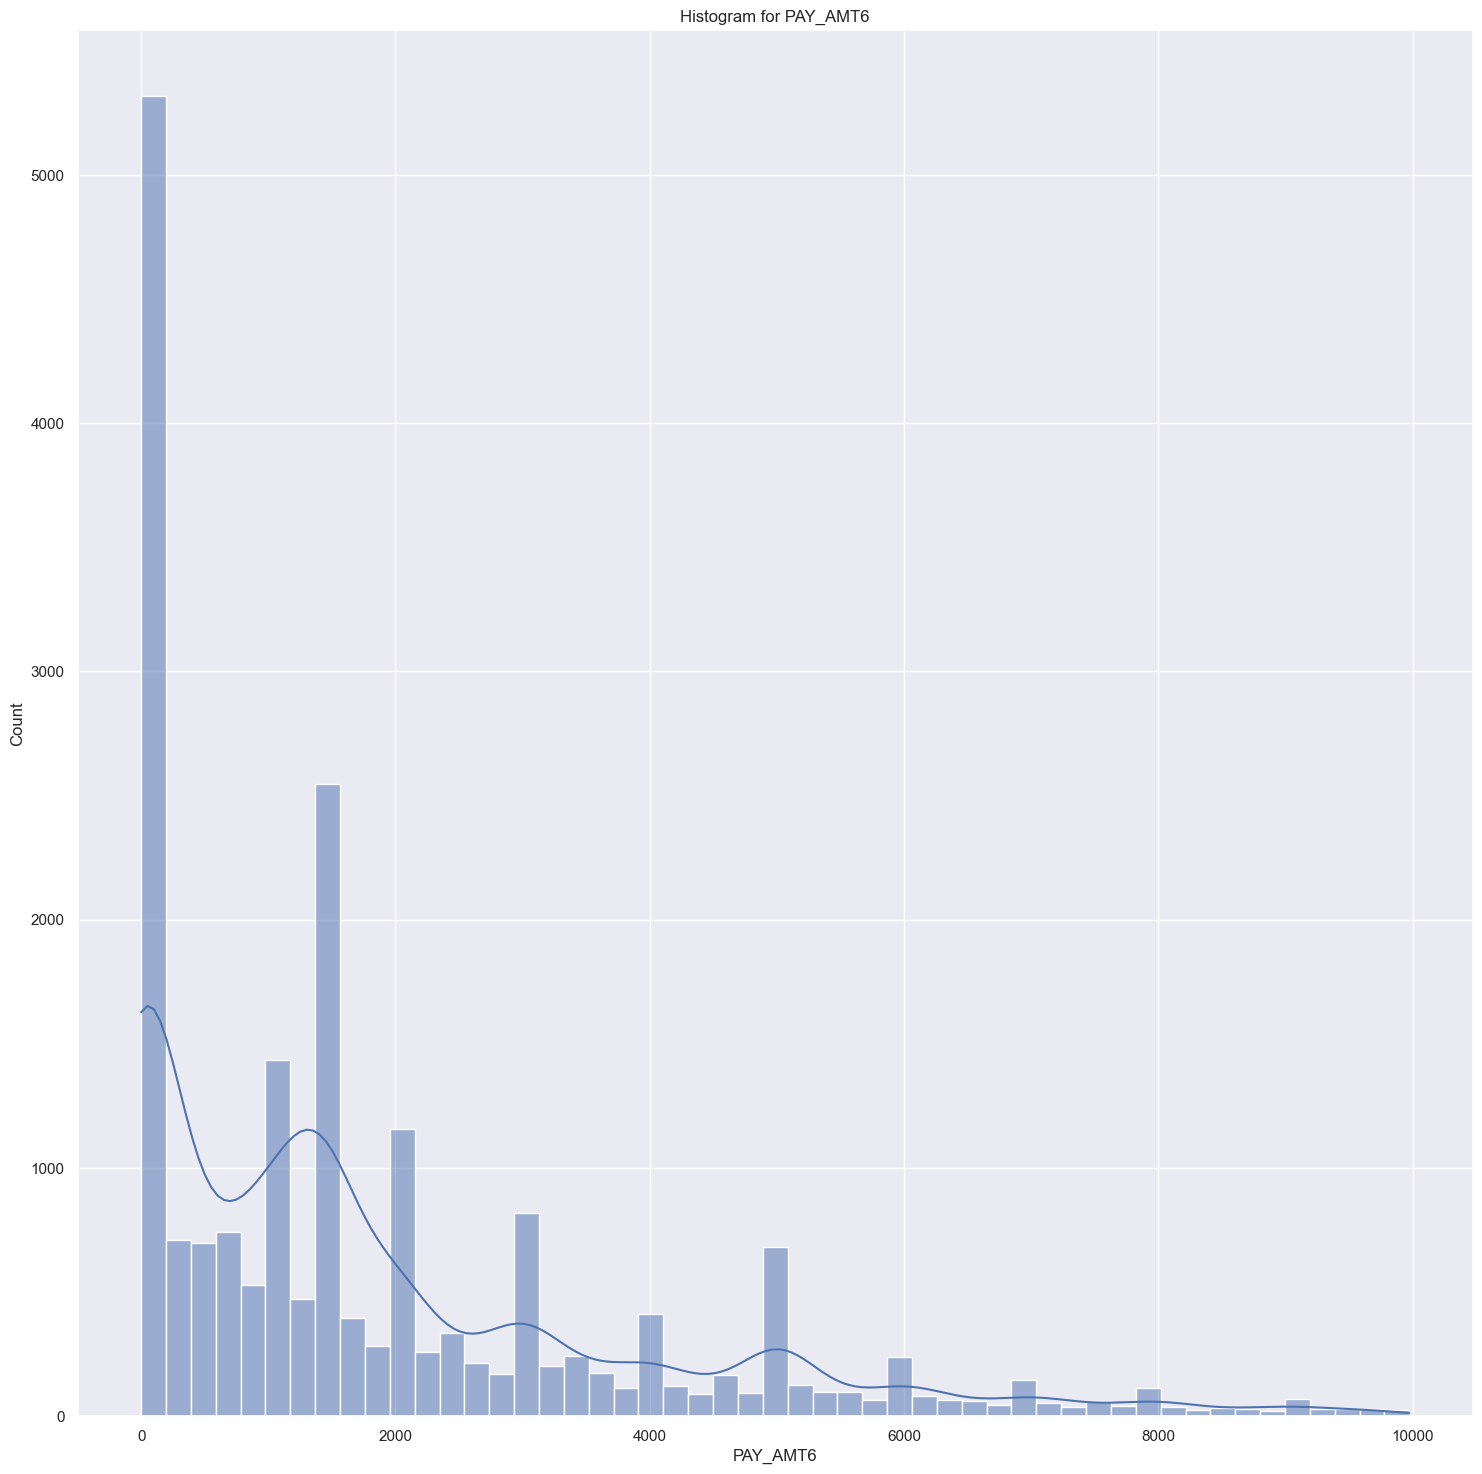

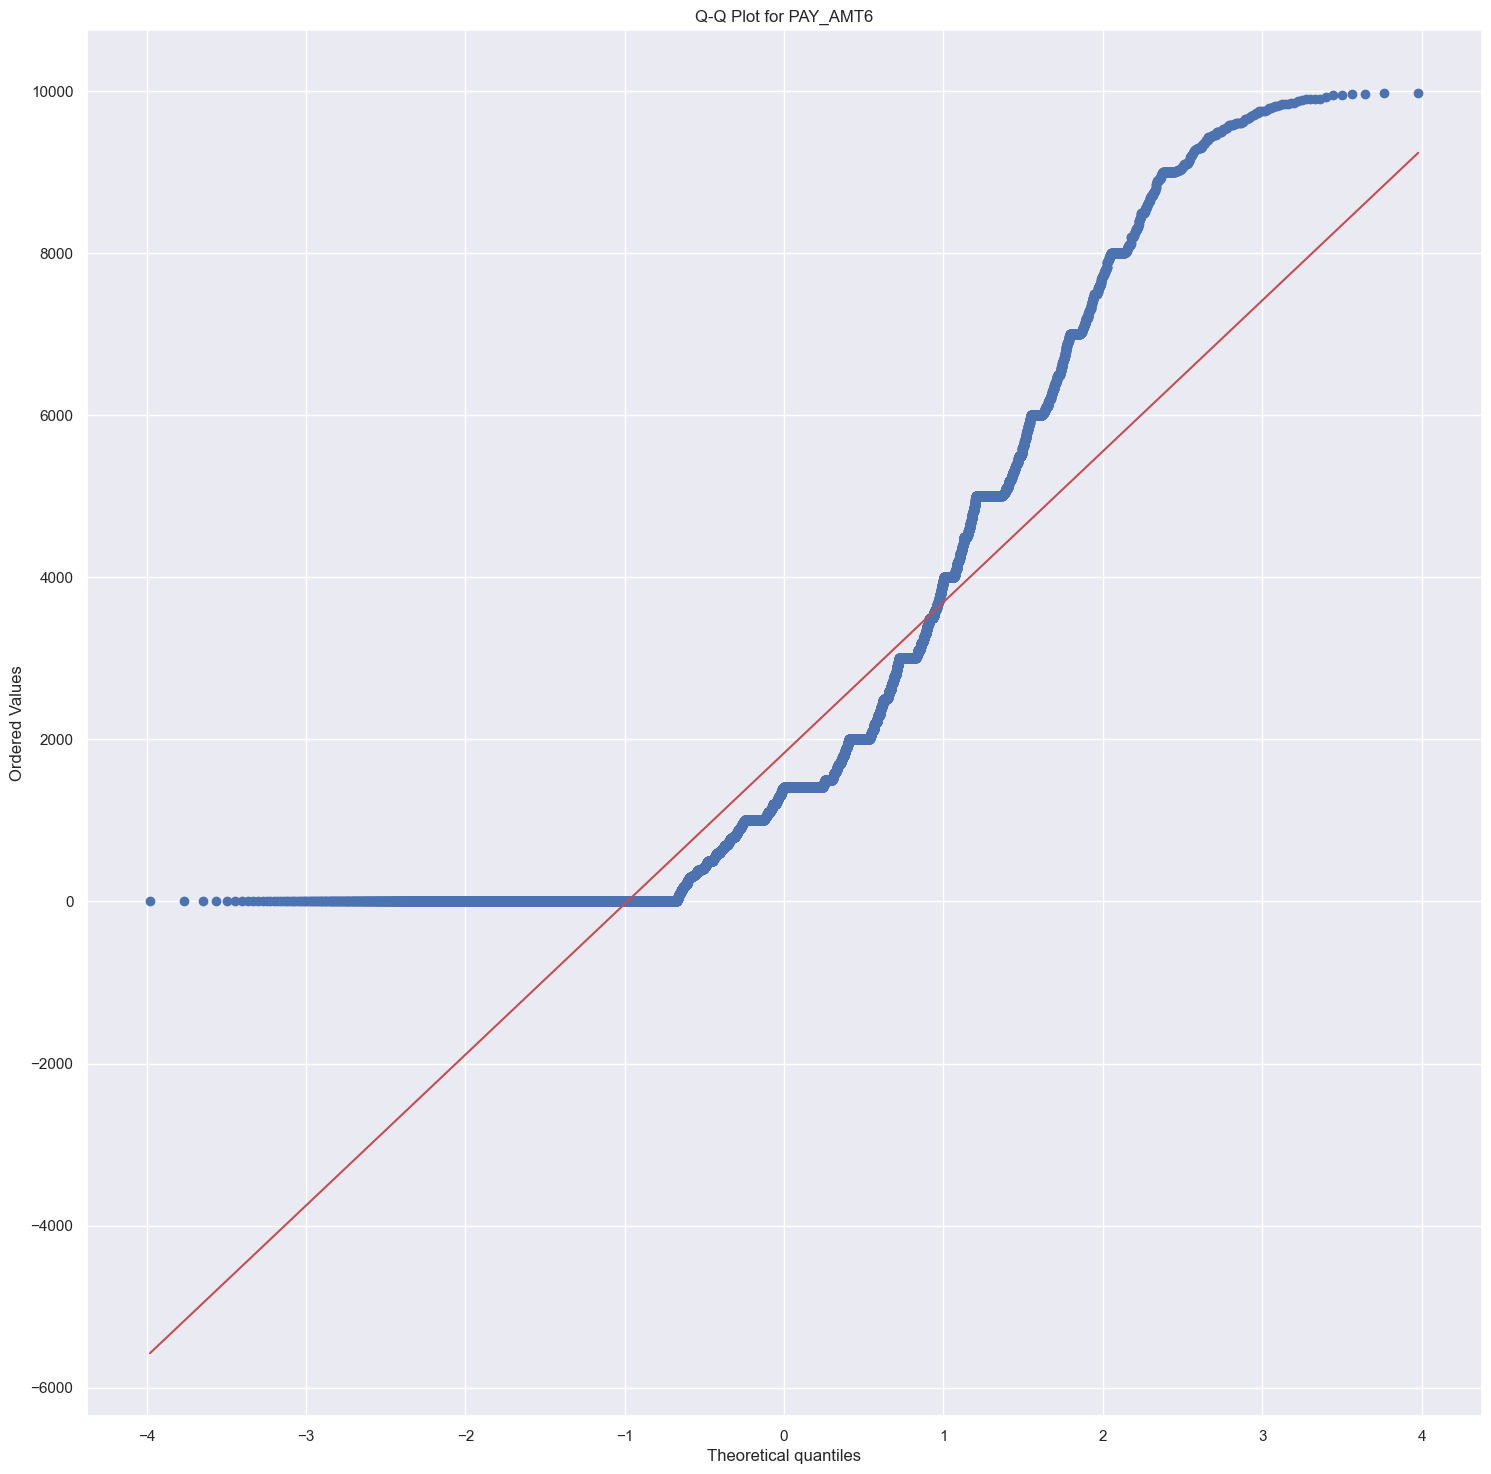

      Feature  KS Test Statistic  p-value
0   LIMIT_BAL           1.000000      0.0
1         AGE           1.000000      0.0
2   BILL_AMT1           0.914500      0.0
3   BILL_AMT2           0.892900      0.0
4   BILL_AMT3           0.880350      0.0
5   BILL_AMT4           0.872400      0.0
6   BILL_AMT5           0.859818      0.0
7   BILL_AMT6           0.839950      0.0
8    PAY_AMT1           0.818818      0.0
9    PAY_AMT2           0.811818      0.0
10   PAY_AMT3           0.791718      0.0
11   PAY_AMT4           0.777618      0.0
12   PAY_AMT5           0.771268      0.0
13   PAY_AMT6           0.751418      0.0


In [103]:
results = []

for feature in Con_feats:
    # Kolmogorov-Smirnov test
    ks_test = stats.kstest(data_training[feature], 'norm')
    
    results.append({
        'Feature': feature,
        'KS Test Statistic': ks_test.statistic,
        'p-value': ks_test.pvalue
    })

    # Histogram
    sns.histplot(data_training[feature], kde=True)
    plt.title(f'Histogram for {feature}')
    plt.show()

    # Q-Q plot
    stats.probplot(data_training[feature], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot for {feature}')
    plt.show()

results_df = pd.DataFrame(results)
print(results_df)

In [66]:
results = []

for feature in Con_feats:
    group1 = data_training[data_training['default payment next month'] == 0][feature]
    group2 = data_training[data_training['default payment next month'] == 1][feature]

    # Perform Mann-Whitney U test
    u_statistic, p_value = mannwhitneyu(group1, group2, alternative='two-sided')

    results.append({
        'Feature': feature,
        'U Statistic': u_statistic,
        'p-value': p_value
    })

results_df = pd.DataFrame(results)

# Sort the features by p-value
results_df.sort_values(by='p-value', ascending=True, inplace=True)


In [67]:
results_df = results_df.reset_index().drop('index', axis=1)

In [68]:
results_df

Feature  U Statistic        p-value
0   LIMIT_BAL   42976289.5  1.200955e-114
1    PAY_AMT1   41467901.5   1.060750e-75
2    PAY_AMT2   41180487.5   2.168642e-69
3    PAY_AMT4   40483615.5   1.816819e-54
4    PAY_AMT3   40211836.5   4.201808e-49
5    PAY_AMT6   39936150.0   2.208628e-44
6    PAY_AMT5   39746897.0   5.870421e-41
7   BILL_AMT1   36169253.0   4.291502e-03
8   BILL_AMT6   34500584.0   4.264453e-02
9   BILL_AMT2   35664941.0   1.673702e-01
10        AGE   35504611.0   3.615685e-01
11  BILL_AMT3   35474033.0   4.100574e-01
12  BILL_AMT4   34935164.5   4.516075e-01
13  BILL_AMT5   34935738.5   4.531409e-01

In [172]:
selected_con_feats = ['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT6',
                      'BILL_AMT3', 'PAY_AMT1',
                      'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

C:\Users\Ighdaro Emwinghare\AppData\Local\Temp\ipykernel_4708\3053747793.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corrmat, dtype=np.bool)


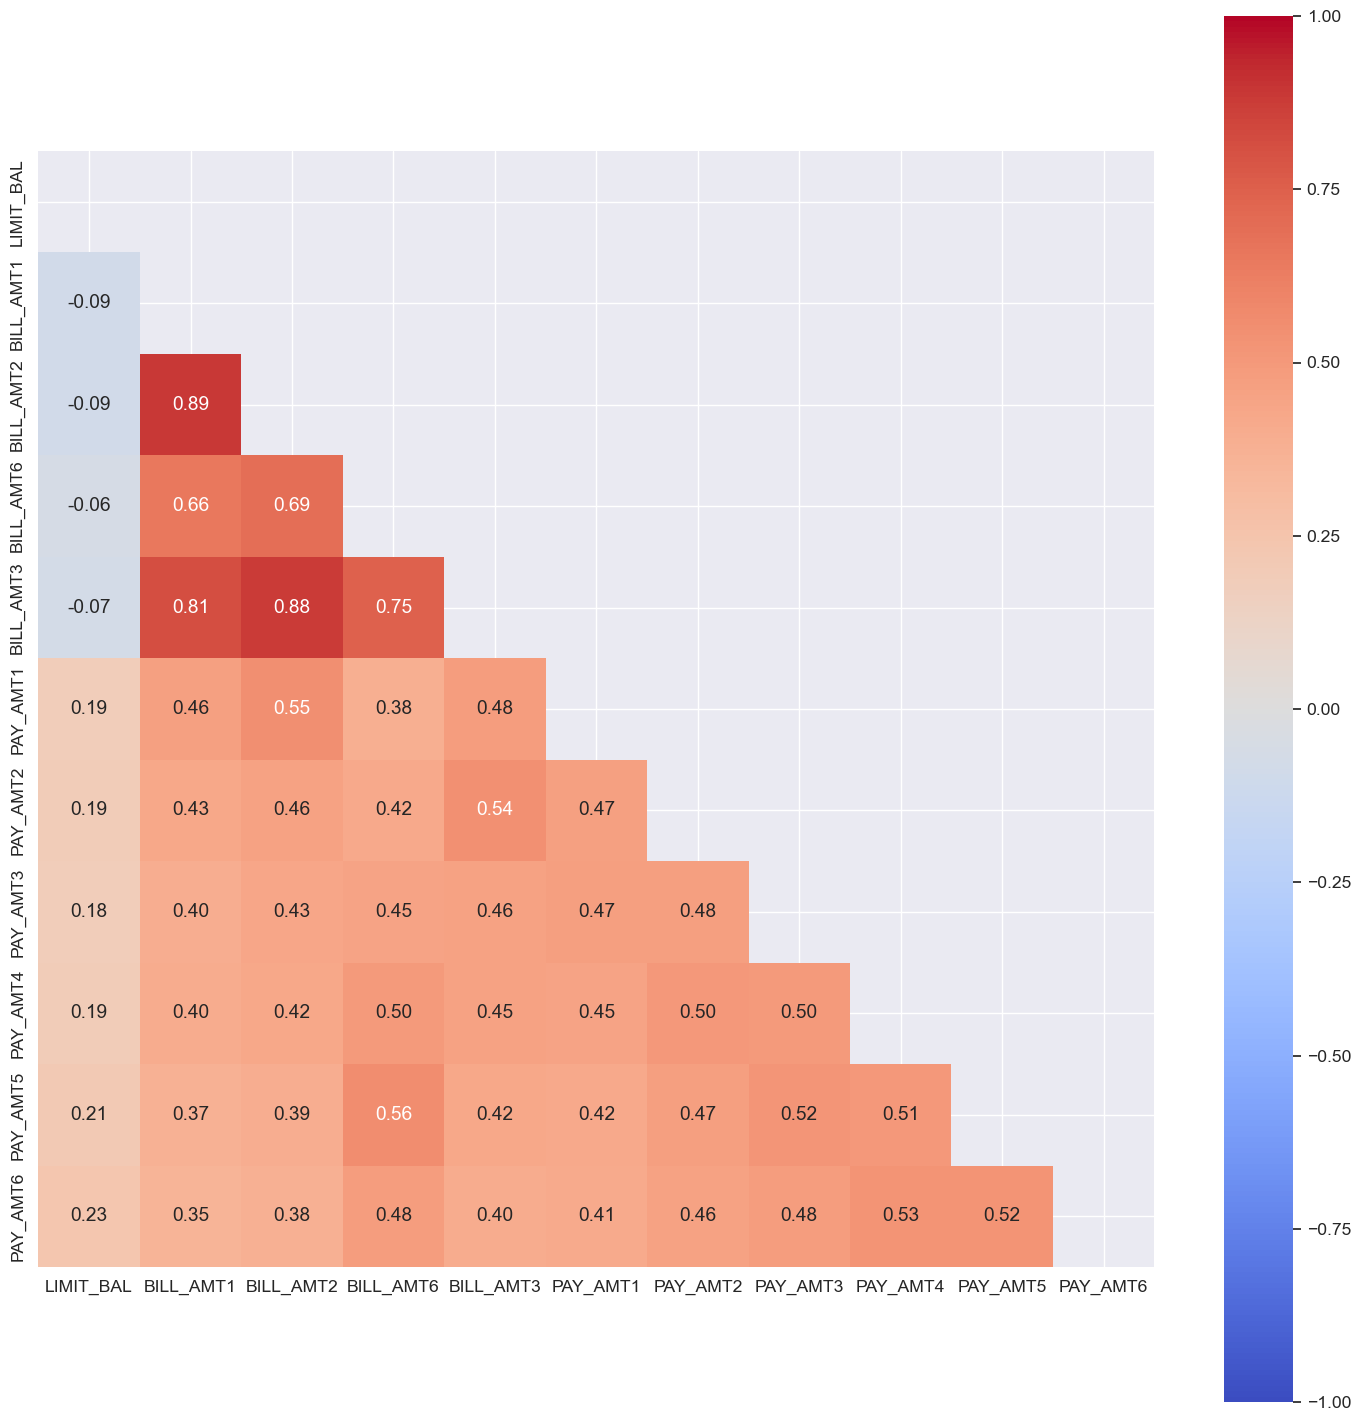

In [173]:
corrmat = data_training[selected_con_feats].corr(method='spearman')

sns.set(rc={'figure.figsize':(18,18)}, font_scale=1.15)
mask = np.zeros_like(corrmat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(
        corrmat, 
        vmin=-1, vmax=1, center=0,
        cmap='coolwarm',
        square=True,
        mask=mask,
        annot=True,
        fmt = '.2f'
    )

In [175]:
corrmat = data_training[selected_con_feats].corr(method='spearman')

# Select upper triangle of correlation matrix
upper = corrmat.where(np.triu(np.ones(corrmat.shape), k=1).astype(bool))

# Find features with correlation greater than 0.7
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# Drop features 
print("Columns to drop:", to_drop)

Columns to drop: ['BILL_AMT2', 'BILL_AMT3']


In [176]:
def calculate_contingency_coefficient(df):
    """
    Calculate the contingency coefficient for all pairs of categorical variables in the DataFrame
    and return the results as a DataFrame sorted by the contingency coefficient.

    :param df: Pandas DataFrame with categorical variables
    :return: DataFrame with pairs of variables and their contingency coefficients
    """
    results = []

    for (var1, var2) in combinations(df.columns, 2):
        # Create a contingency table
        contingency_table = pd.crosstab(df[var1], df[var2])

        # Calculate the Chi-Square test statistic and p-value
        chi2, p, dof, expected = chi2_contingency(contingency_table)

        # Calculate the contingency coefficient
        n = sum(sum(contingency_table.values))
        contingency_coefficient = (chi2 / (chi2 + n)) ** 0.5

        # Append the result
        results.append((var1, var2, contingency_coefficient))

    # Convert to DataFrame and sort
    results_df = pd.DataFrame(results, columns=['Variable1', 'Variable2', 'Contingency_Coefficient'])
    results_df = results_df.sort_values(by='Contingency_Coefficient', ascending=False)

    return results_df

In [73]:
calculate_contingency_coefficient(data_training[Cat_feats])

Variable1  Variable2  Contingency_Coefficient
0      PAY_0      PAY_2                 0.902034
15     PAY_3      PAY_4                 0.896292
21     PAY_4      PAY_5                 0.895323
8      PAY_2      PAY_3                 0.893901
26     PAY_5      PAY_6                 0.887539
22     PAY_4      PAY_6                 0.856536
1      PAY_0      PAY_3                 0.853808
16     PAY_3      PAY_5                 0.851591
9      PAY_2      PAY_4                 0.839275
17     PAY_3      PAY_6                 0.813074
2      PAY_0      PAY_4                 0.798595
10     PAY_2      PAY_5                 0.762971
3      PAY_0      PAY_5                 0.726293
11     PAY_2      PAY_6                 0.705159
4      PAY_0      PAY_6                 0.676877
14     PAY_2  EDUCATION                 0.217209
20     PAY_3  EDUCATION                 0.209064
7      PAY_0  EDUCATION                 0.199465
34  MARRIAGE  EDUCATION                 0.196461
25     PAY_4  EDUCATION                 0.189942
32     PAY_6  EDUCATION                 0.173945
29     PAY_5  EDUCATION                 0.172154
5      PAY_0   MARRIAGE                 0.082810
23     PAY_4   MARRIAGE                 0.073397
27     PAY_5   MARRIAGE                 0.068049
12     PAY_2   MARRIAGE                 0.066595
19     PAY_3        SEX                 0.064198
13     PAY_2        SEX                 0.064034
30     PAY_6   MARRIAGE                 0.062220
24     PAY_4        SEX                 0.059147
18     PAY_3   MARRIAGE                 0.057368
6      PAY_0        SEX                 0.056065
28     PAY_5        SEX                 0.052560
35       SEX  EDUCATION                 0.045915
31     PAY_6        SEX                 0.040308
33  MARRIAGE        SEX                 0.034543

#### After using the Chi2 for categorical variables and  mannwhitneyu for continuous variables, we ended up selecting a total of 13 features, out of 22 initial features (excluding the ID) based on p-value (>0.01) and high contigency score amongst categorical variables.

The features dropped are:
1. BILL_AMT5 
2. BILL_AMT4 
3. AGE	     
4. BILL_AMT2 
5. BILL_AMT3
6. PAY_2 (high contingency coefficient with PAY_0)
7. PAY_3 (high contingency coefficient with PAY_0)
8. PAY_4 (high contingency coefficient with PAY_0)
9. PAY_5 (high contingency coefficient with PAY_0)

In [177]:
data_training_new = data_training.drop(["BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "AGE", "PAY_2", "PAY_3", "PAY_4", "PAY_5"], axis=1)

### Weight of Evidence and Information Value Calculation for Categorical Variables

In [75]:
def calculate_woe_iv_with_significance(df, feature, target):
    """
    Calculate Weight of Evidence (WoE), Information Value (IV) for a categorical variable
    and add the p-value from the Chi-square test to check statistical significance.

    :param df: DataFrame containing the feature and target
    :param feature: The categorical feature for which to calculate WoE, IV, and p-value
    :param target: The binary target variable
    :return: DataFrame with WoE, IV values, and the p-value from the Chi-square test
    """
    # Calculate the number of events and non-events
    events = df[target].sum()
    non_events = len(df) - events

    # Calculate WoE and IV
    woe_iv_df = (df.groupby(feature)[target]
                 .agg(['count', 'sum'])
                 .rename(columns={'count': 'total', 'sum': 'events'}))
    woe_iv_df['non_events'] = woe_iv_df['total'] - woe_iv_df['events']
    woe_iv_df['event_rate'] = woe_iv_df['events'] / events
    woe_iv_df['non_event_rate'] = woe_iv_df['non_events'] / non_events
    woe_iv_df['WoE'] = np.log(woe_iv_df['event_rate'] / woe_iv_df['non_event_rate'])
    woe_iv_df['diff_WoE'] = woe_iv_df['WoE'].diff().abs()
    woe_iv_df['IV'] = (woe_iv_df['event_rate'] - woe_iv_df['non_event_rate']) * woe_iv_df['WoE']
    woe_iv_df['IV'] = woe_iv_df['IV'].replace({np.inf:0, -np.inf:0})
    woe_iv_df = woe_iv_df.reset_index()
    woe_iv_df['IV_total'] = woe_iv_df['IV'].sum()
    return woe_iv_df

In [76]:
# We set the default style of the graphs to the seaborn style. 
sns.set()
# Below we define a function for plotting WoE across categories that takes 2 arguments: a dataframe and a number.
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize=(18, 6))
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)    

In [77]:
#SEX
df_temp = calculate_woe_iv_with_significance(data_training_new, 'SEX', 'default payment next month')
df_temp

SEX  total  events  non_events  event_rate  non_event_rate       WoE  \
0    1   7719    1892        5827    0.415094        0.377347  0.095339   
1    2  12281    2666        9615    0.584906        0.622653 -0.062538   

   diff_WoE        IV  IV_total  
0       NaN  0.003599  0.005959  
1  0.157877  0.002361  0.005959

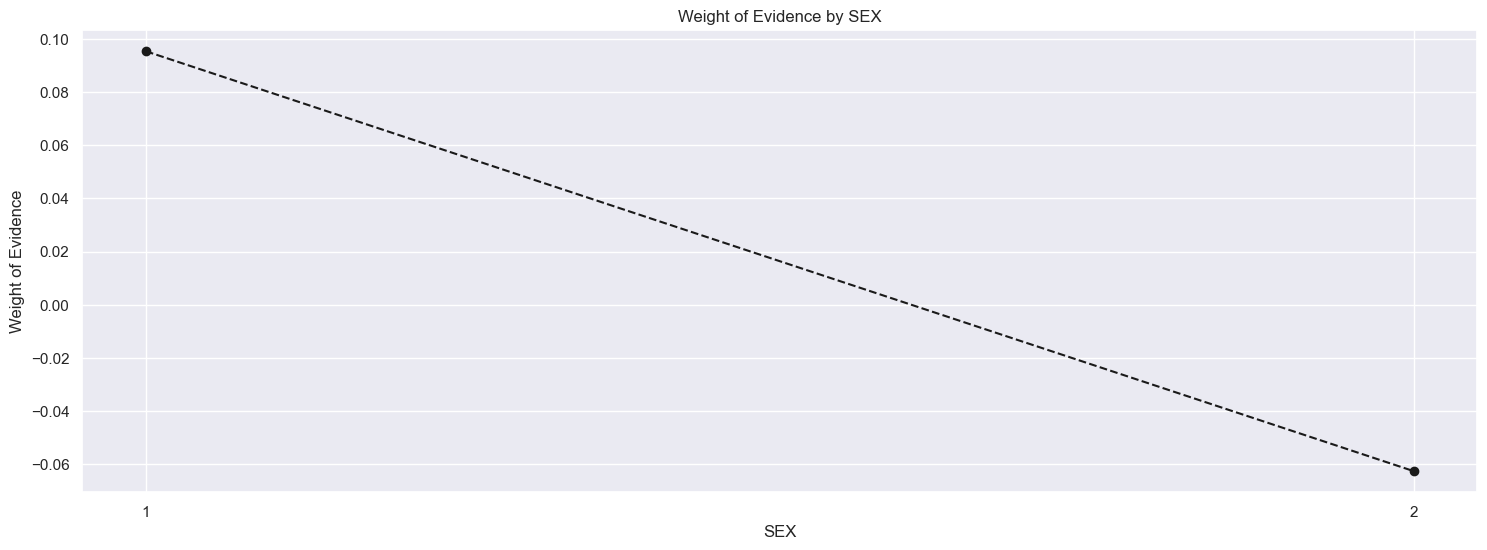

In [78]:
plot_by_woe(df_temp)

In [79]:
#EDUCATION
df_temp = calculate_woe_iv_with_significance(data_training_new, 'EDUCATION', 'default payment next month')
df_temp

C:\Users\Ighdaro Emwinghare\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


EDUCATION  total  events  non_events  event_rate  non_event_rate       WoE  \
0          0      9       0           9    0.000000        0.000583      -inf   
1          1   7113    1441        5672    0.316147        0.367310 -0.149997   
2          2   9451    2274        7177    0.498903        0.464771  0.070866   
3          3   3191     828        2363    0.181659        0.153024  0.171533   
4          4     57       2          55    0.000439        0.003562 -2.093979   
5          5    151      11         140    0.002413        0.009066 -1.323540   
6          6     28       2          26    0.000439        0.001684 -1.344742   

   diff_WoE        IV  IV_total  
0       NaN  0.000000  0.032024  
1       inf  0.007674  0.032024  
2  0.220863  0.002419  0.032024  
3  0.100667  0.004912  0.032024  
4  2.265512  0.006539  0.032024  
5  0.770439  0.008805  0.032024  
6  0.021202  0.001674  0.032024

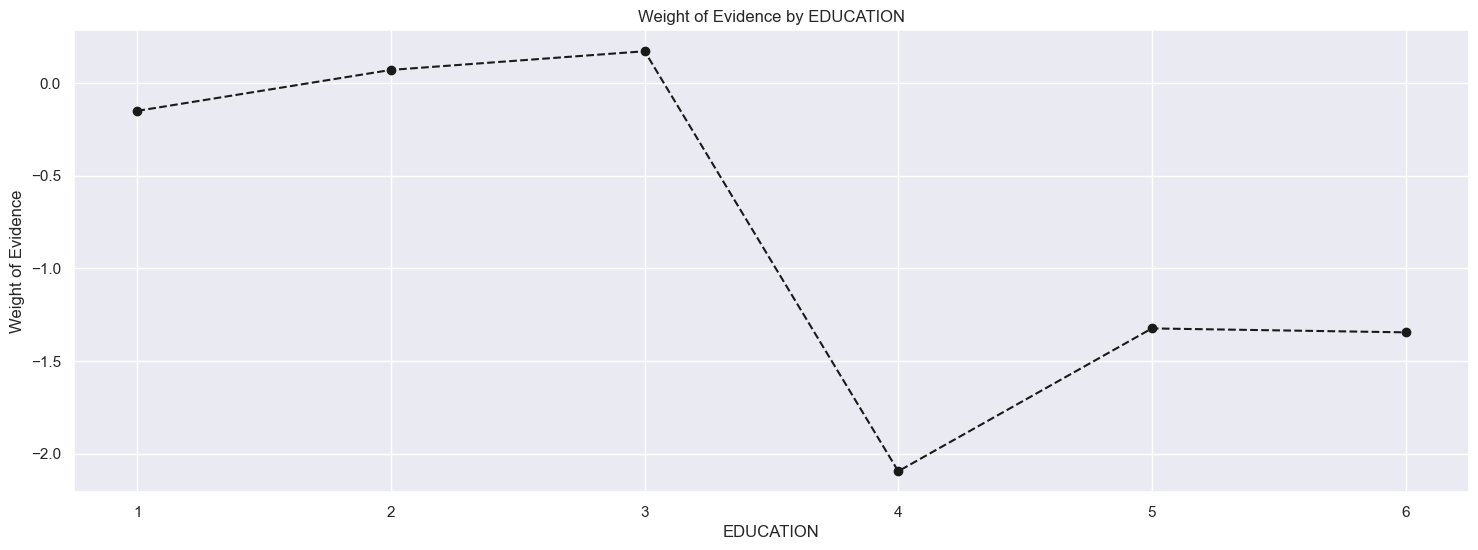

In [80]:
plot_by_woe(df_temp)

In [81]:
#MARRIAGE
df_temp = calculate_woe_iv_with_significance(data_training_new, 'MARRIAGE', 'default payment next month')
df_temp

MARRIAGE  total  events  non_events  event_rate  non_event_rate       WoE  \
0         0     33       1          32    0.000219        0.002072 -2.245529   
1         1   9033    2190        6843    0.480474        0.443142  0.080882   
2         2  10702    2306        8396    0.505924        0.543712 -0.072034   
3         3    232      61         171    0.013383        0.011074  0.189417   

   diff_WoE        IV  IV_total  
0       NaN  0.004161   0.01034  
1  2.326411  0.003019   0.01034  
2  0.152916  0.002722   0.01034  
3  0.261451  0.000437   0.01034

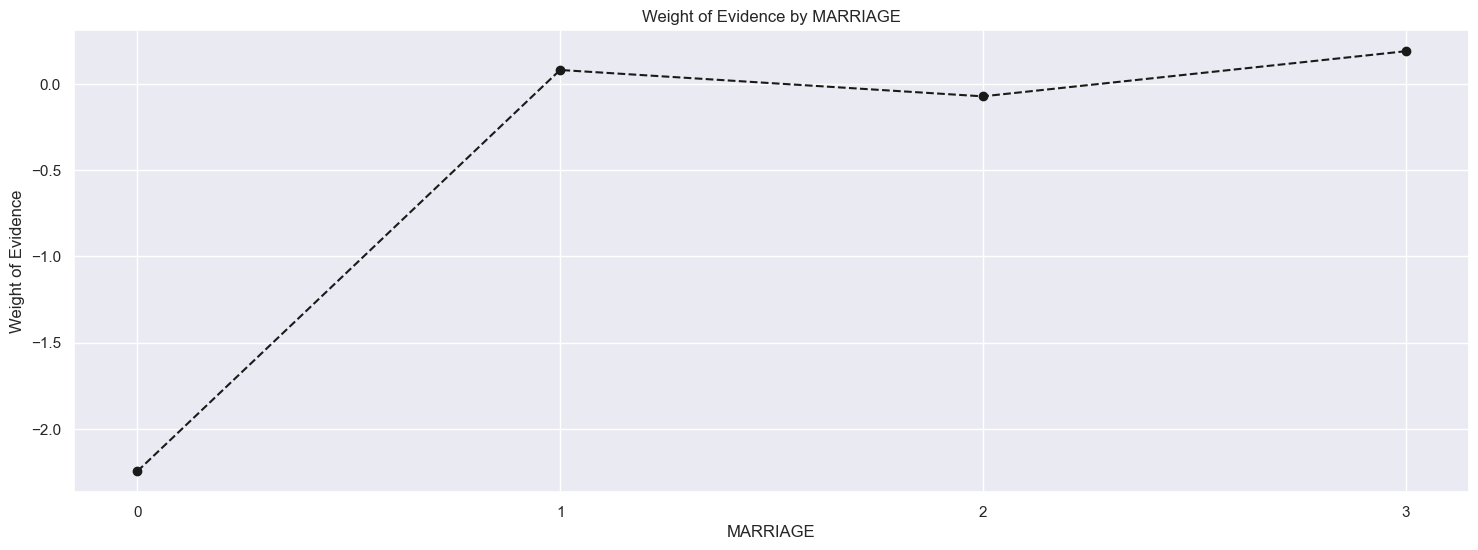

In [82]:
plot_by_woe(df_temp)

In [83]:
#PAY_0
df_temp = calculate_woe_iv_with_significance(data_training_new, 'PAY_0', 'default payment next month')
df_temp

PAY_0  total  events  non_events  event_rate  non_event_rate       WoE  \
0      -2   1585     205        1380    0.044976        0.089367 -0.686622   
1      -1   3886     707        3179    0.155112        0.205867 -0.283084   
2       0   9765    1260        8505    0.276437        0.550771 -0.689335   
3       1   2569     881        1688    0.193287        0.109312  0.569965   
4       2   1890    1292         598    0.283458        0.038726  1.990563   
5       3    202     149          53    0.032690        0.003432  2.253862   
6       4     58      38          20    0.008337        0.001295  1.862061   
7       5     13       7           6    0.001536        0.000389  1.374358   
8       6      8       4           4    0.000878        0.000259  1.220207   
9       7      7       6           1    0.001316        0.000065  3.011967   
10      8     17       9           8    0.001975        0.000518  1.337990   

    diff_WoE        IV  IV_total  
0        NaN  0.030480  0.856077  
1   0.403538  0.014368  0.856077  
2   0.406251  0.189108  0.856077  
3   1.259300  0.047862  0.856077  
4   1.420598  0.487155  0.856077  
5   0.263298  0.065943  0.856077  
6   0.391801  0.013112  0.856077  
7   0.487703  0.001577  0.856077  
8   0.154151  0.000755  0.856077  
9   1.791759  0.003770  0.856077  
10  1.673976  0.001949  0.856077

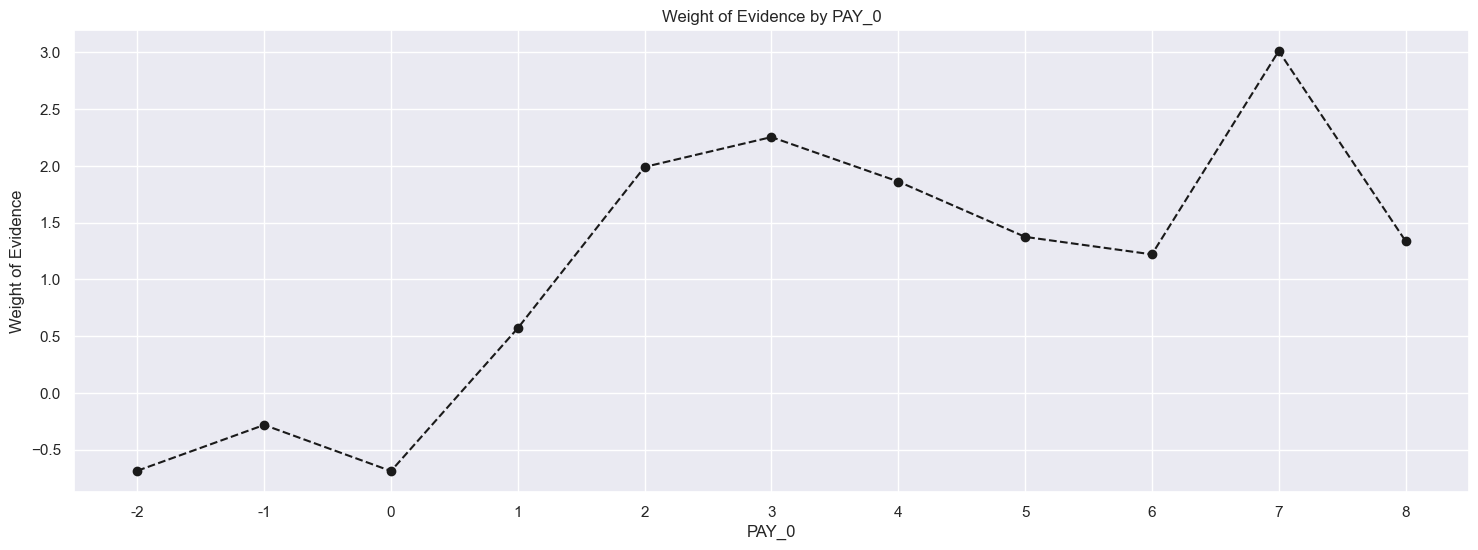

In [84]:
plot_by_woe(df_temp)

In [85]:
#PAY_6
df_temp = calculate_woe_iv_with_significance(data_training_new, 'PAY_6', 'default payment next month')
df_temp

PAY_6  total  events  non_events  event_rate  non_event_rate       WoE  \
0     -2   3069     648        2421    0.142168        0.156780 -0.097838   
1     -1   4041     717        3324    0.157306        0.215257 -0.313641   
2      0  10646    2052        8594    0.450197        0.556534 -0.212042   
3      2   2014     991        1023    0.217420        0.066248  1.188427   
4      3    140      86          54    0.018868        0.003497  1.685570   
5      4     32      20          12    0.004388        0.000777  1.731033   
6      5      9       6           3    0.001316        0.000194  1.913354   
7      6     15      11           4    0.002413        0.000259  2.231808   
8      7     32      25           7    0.005485        0.000453  2.493173   
9      8      2       2           0    0.000439        0.000000       inf   

   diff_WoE        IV  IV_total  
0       NaN  0.001430  0.273469  
1  0.215803  0.018176  0.273469  
2  0.101599  0.022548  0.273469  
3  1.400469  0.179657  0.273469  
4  0.497143  0.025909  0.273469  
5  0.045462  0.006250  0.273469  
6  0.182322  0.002147  0.273469  
7  0.318454  0.004808  0.273469  
8  0.261365  0.012545  0.273469  
9       inf  0.000000  0.273469

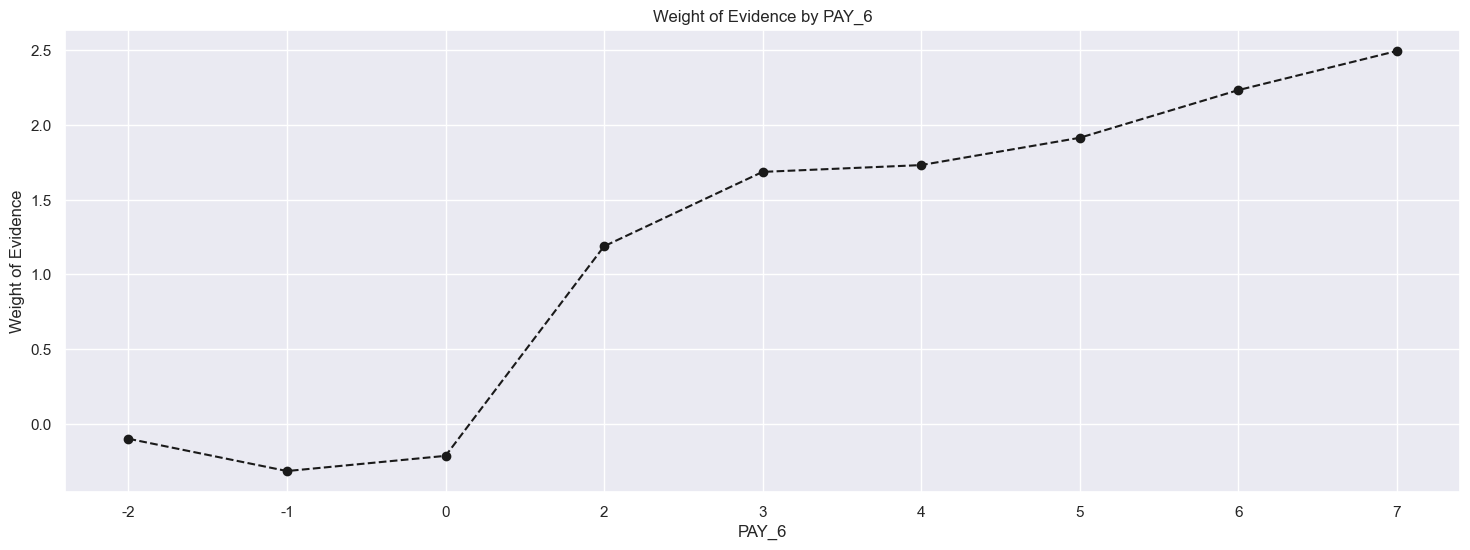

In [86]:
plot_by_woe(df_temp)

### Weight of Evidence and Information Value Calculation for Continuous Variables

In [108]:
def find_optimal_binning(df, continuous_variable, target_variable, max_bins=20):
    """
    Find the optimal number of bins for fine classing a continuous variable
    based on the Akaike Information Criterion (AIC).

    :param df: DataFrame containing the data
    :param continuous_variable: The name of the continuous variable to bin
    :param target_variable: The name of the target variable
    :param max_bins: The maximum number of bins to consider
    :return: Optimal number of bins
    """
    best_aic = np.inf
    best_bins = 0

    for bins in range(2, max_bins + 1):
        # Create a binned version of the continuous variable
        df_binned = df.copy()
        df_binned[continuous_variable] = pd.cut(df_binned[continuous_variable], bins=bins, labels=False)

        # Fit a logistic regression model
        X = sm.add_constant(df_binned[continuous_variable])
        y = df_binned[target_variable]

        model = sm.Logit(y, X).fit(disp=0)
        aic = model.aic

        if aic < best_aic:
            best_aic = aic
            best_bins = bins

    return best_bins

In [109]:
# We define a function to calculate WoE of continuous variables. This is same as the function we defined earlier for discrete variables.
# The only difference are the 2 commented lines of code in the function that results in the df being sorted by continuous variable values
def woe_ordered_continuous(df, continuous_variable, target_variable):
    no_bins = find_optimal_binning(df, continuous_variable, target_variable)
    print("Optimal Number of Bins:", no_bins)
    variable_name = continuous_variable+'_binned'
    df = df.copy()
    df[variable_name] = pd.cut(df[continuous_variable], no_bins)
    df = pd.concat([df[variable_name], df[target_variable]], axis = 1)

    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].replace({np.inf:0, -np.inf:0})
    df['IV_total'] = df['IV'].sum()
    return df

In [110]:
#PAY_AMT1
df_temp = woe_ordered_continuous(data_training_new, 'PAY_AMT1', 'default payment next month')

Optimal Number of Bins: 16


In [111]:
df_temp

PAY_AMT1_binned  n_obs  prop_good  prop_n_obs  n_good   n_bad  \
0     (-11.046, 690.375]   4696   0.328790     0.23480  1544.0  3152.0   
1     (690.375, 1380.75]   1879   0.230442     0.09395   433.0  1446.0   
2    (1380.75, 2071.125]   3402   0.236919     0.17010   806.0  2596.0   
3     (2071.125, 2761.5]   3175   0.171339     0.15875   544.0  2631.0   
4     (2761.5, 3451.875]   1525   0.218361     0.07625   333.0  1192.0   
5    (3451.875, 4142.25]   1103   0.217588     0.05515   240.0   863.0   
6    (4142.25, 4832.625]    540   0.211111     0.02700   114.0   426.0   
7     (4832.625, 5523.0]   1038   0.157996     0.05190   164.0   874.0   
8     (5523.0, 6213.375]    557   0.131059     0.02785    73.0   484.0   
9    (6213.375, 6903.75]    349   0.177650     0.01745    62.0   287.0   
10   (6903.75, 7594.125]    397   0.138539     0.01985    55.0   342.0   
11    (7594.125, 8284.5]    354   0.158192     0.01770    56.0   298.0   
12    (8284.5, 8974.875]    176   0.164773     0.00880    29.0   147.0   
13   (8974.875, 9665.25]    202   0.143564     0.01010    29.0   173.0   
14  (9665.25, 10355.625]    452   0.110619     0.02260    50.0   402.0   
15  (10355.625, 11046.0]    155   0.167742     0.00775    26.0   129.0   

    prop_n_good  prop_n_bad       WoE  diff_prop_good  diff_WoE        IV  \
0      0.338745    0.204119  0.506546             NaN       NaN  0.068195   
1      0.094998    0.093641  0.014388        0.098349  0.492158  0.000020   
2      0.176832    0.168113  0.050564        0.006478  0.036175  0.000441   
3      0.119351    0.170379 -0.355963        0.065581  0.406527  0.018164   
4      0.073058    0.077192 -0.055038        0.047022  0.300925  0.000228   
5      0.052655    0.055887 -0.059569        0.000772  0.004530  0.000193   
6      0.025011    0.027587 -0.098034        0.006477  0.038465  0.000253   
7      0.035981    0.056599 -0.453007        0.053115  0.354973  0.009340   
8      0.016016    0.031343 -0.671418        0.026937  0.218412  0.010291   
9      0.013602    0.018586 -0.312141        0.046591  0.359278  0.001555   
10     0.012067    0.022147 -0.607270        0.039111  0.295130  0.006122   
11     0.012286    0.019298 -0.451535        0.019653  0.155736  0.003166   
12     0.006362    0.009519 -0.402930        0.006581  0.048605  0.001272   
13     0.006362    0.011203 -0.565789        0.021208  0.162859  0.002739   
14     0.010970    0.026033 -0.864222        0.032945  0.298433  0.013018   
15     0.005704    0.008354 -0.381509        0.057122  0.482713  0.001011   

    IV_total  
0   0.136006  
1   0.136006  
2   0.136006  
3   0.136006  
4   0.136006  
5   0.136006  
6   0.136006  
7   0.136006  
8   0.136006  
9   0.136006  
10  0.136006  
11  0.136006  
12  0.136006  
13  0.136006  
14  0.136006  
15  0.136006

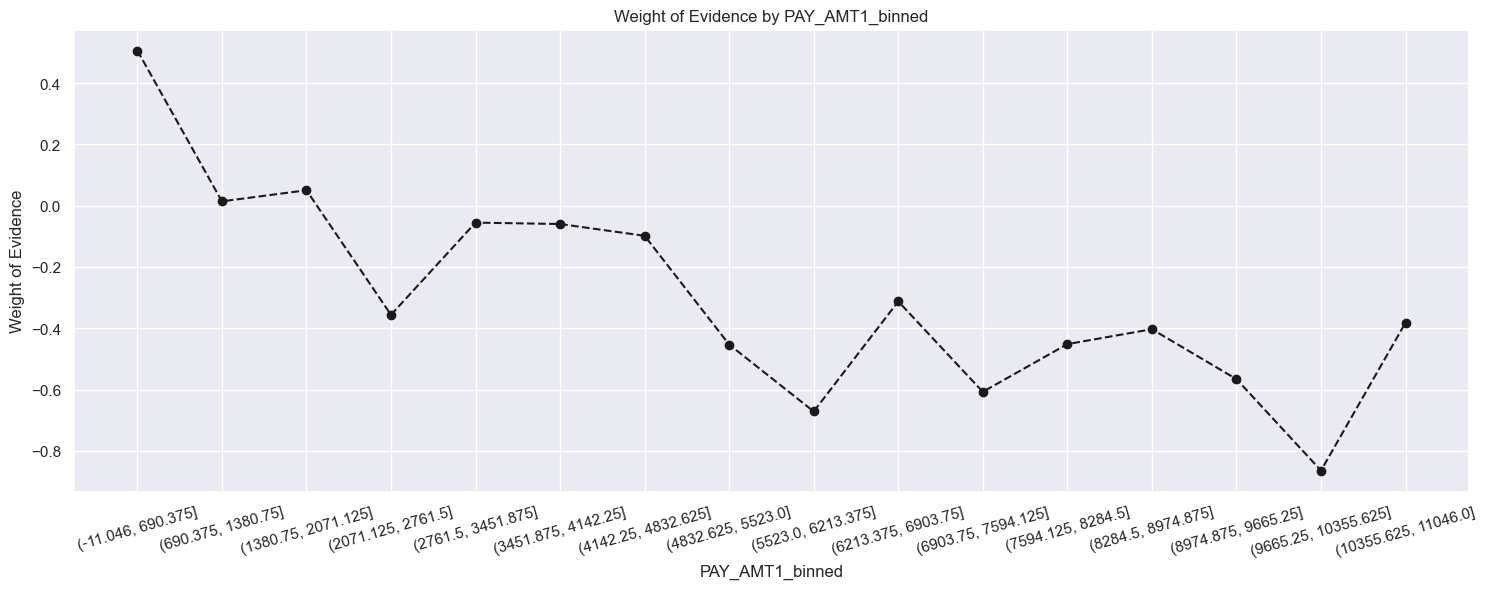

In [112]:
plot_by_woe(df_temp, 16)

In [113]:
df_temp = woe_ordered_continuous(data_training_new, 'PAY_AMT2', 'default payment next month')
df_temp

Optimal Number of Bins: 12


PAY_AMT2_binned  n_obs  prop_good  prop_n_obs  n_good   n_bad  \
0      (-11.365, 947.083]   5248   0.312881     0.26240  1642.0  3606.0   
1     (947.083, 1894.167]   3976   0.245221     0.19880   975.0  3001.0   
2     (1894.167, 2841.25]   4476   0.176497     0.22380   790.0  3686.0   
3     (2841.25, 3788.333]   1787   0.219922     0.08935   393.0  1394.0   
4    (3788.333, 4735.417]   1046   0.198853     0.05230   208.0   838.0   
5      (4735.417, 5682.5]   1139   0.162423     0.05695   185.0   954.0   
6      (5682.5, 6629.583]    657   0.149163     0.03285    98.0   559.0   
7    (6629.583, 7576.667]    458   0.146288     0.02290    67.0   391.0   
8     (7576.667, 8523.75]    356   0.174157     0.01780    62.0   294.0   
9     (8523.75, 9470.833]    225   0.186667     0.01125    42.0   183.0   
10  (9470.833, 10417.917]    443   0.142212     0.02215    63.0   380.0   
11   (10417.917, 11365.0]    189   0.174603     0.00945    33.0   156.0   

    prop_n_good  prop_n_bad       WoE  diff_prop_good  diff_WoE        IV  \
0      0.360246    0.233519  0.433523             NaN       NaN  0.054939   
1      0.213910    0.194340  0.095944        0.067660  0.337579  0.001878   
2      0.173322    0.238700 -0.320057        0.068724  0.416001  0.020925   
3      0.086222    0.090273 -0.045916        0.043425  0.274141  0.000186   
4      0.045634    0.054268 -0.173273        0.021069  0.127357  0.001496   
5      0.040588    0.061780 -0.420101        0.036430  0.246828  0.008903   
6      0.021501    0.036200 -0.520975        0.013260  0.100874  0.007658   
7      0.014699    0.025321 -0.543808        0.002875  0.022833  0.005776   
8      0.013602    0.019039 -0.336238        0.027869  0.207570  0.001828   
9      0.009215    0.011851 -0.251609        0.012509  0.084629  0.000663   
10     0.013822    0.024608 -0.576829        0.044454  0.325220  0.006222   
11     0.007240    0.010102 -0.333141        0.032391  0.243688  0.000954   

    IV_total  
0   0.111426  
1   0.111426  
2   0.111426  
3   0.111426  
4   0.111426  
5   0.111426  
6   0.111426  
7   0.111426  
8   0.111426  
9   0.111426  
10  0.111426  
11  0.111426

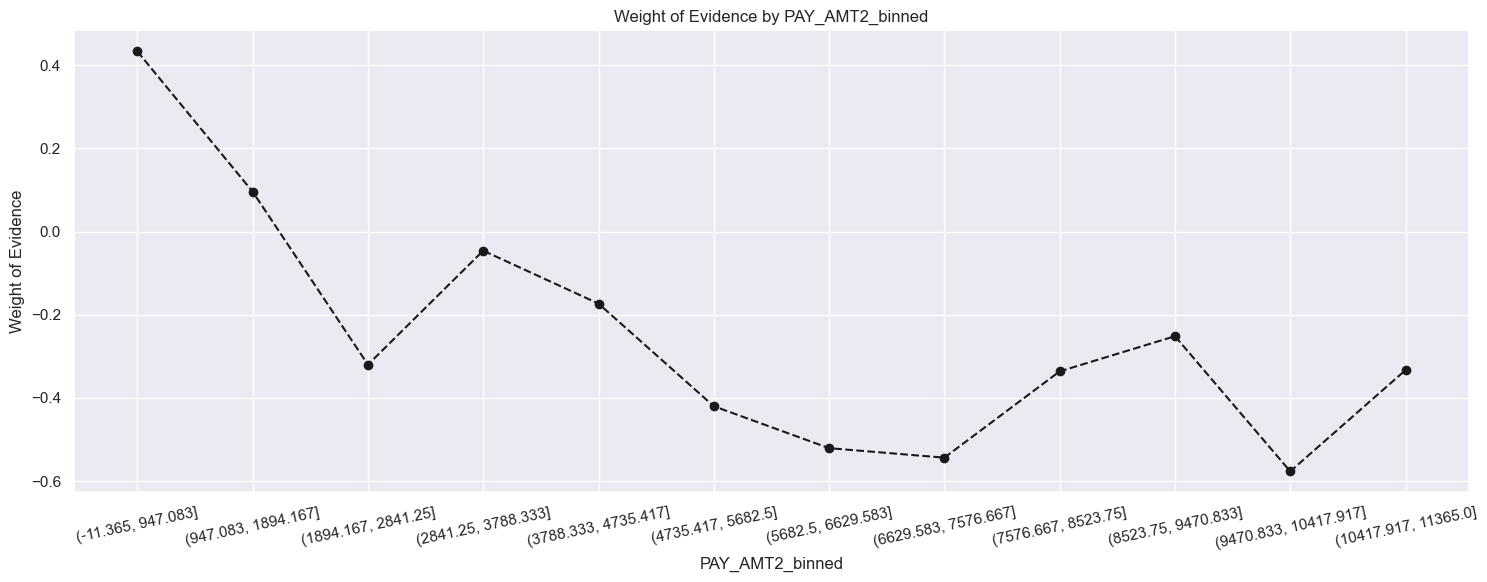

In [114]:
plot_by_woe(df_temp, 12)

In [115]:
df_temp = woe_ordered_continuous(data_training_new, 'PAY_AMT3', 'default payment next month')
df_temp

Optimal Number of Bins: 20


PAY_AMT3_binned  n_obs  prop_good  prop_n_obs  n_good   n_bad  \
0    (-9.636, 481.8]   5569   0.298797     0.27845  1664.0  3905.0   
1     (481.8, 963.6]   1494   0.240964     0.07470   360.0  1134.0   
2    (963.6, 1445.4]   2349   0.225202     0.11745   529.0  1820.0   
3   (1445.4, 1927.2]   3276   0.172161     0.16380   564.0  2712.0   
4   (1927.2, 2409.0]   1622   0.228113     0.08110   370.0  1252.0   
5   (2409.0, 2890.8]    645   0.229457     0.03225   148.0   497.0   
6   (2890.8, 3372.6]   1124   0.181495     0.05620   204.0   920.0   
7   (3372.6, 3854.4]    483   0.225673     0.02415   109.0   374.0   
8   (3854.4, 4336.2]    612   0.200980     0.03060   123.0   489.0   
9   (4336.2, 4818.0]    304   0.220395     0.01520    67.0   237.0   
10  (4818.0, 5299.8]    847   0.128689     0.04235   109.0   738.0   
11  (5299.8, 5781.6]    235   0.191489     0.01175    45.0   190.0   
12  (5781.6, 6263.4]    369   0.189702     0.01845    70.0   299.0   
13  (6263.4, 6745.2]    191   0.172775     0.00955    33.0   158.0   
14  (6745.2, 7227.0]    265   0.249057     0.01325    66.0   199.0   
15  (7227.0, 7708.8]    134   0.164179     0.00670    22.0   112.0   
16  (7708.8, 8190.6]    195   0.148718     0.00975    29.0   166.0   
17  (8190.6, 8672.4]     95   0.157895     0.00475    15.0    80.0   
18  (8672.4, 9154.2]    119   0.184874     0.00595    22.0    97.0   
19  (9154.2, 9636.0]     72   0.125000     0.00360     9.0    63.0   

    prop_n_good  prop_n_bad       WoE  diff_prop_good  diff_WoE            IV  \
0      0.365072    0.252882  0.367174             NaN       NaN  4.119346e-02   
1      0.078982    0.073436  0.072805        0.057833  0.294369  4.037694e-04   
2      0.116060    0.117860 -0.015396        0.015762  0.088201  2.772404e-05   
3      0.123738    0.175625 -0.350180        0.053041  0.334784  1.816961e-02   
4      0.081176    0.081078  0.001213        0.055952  0.351393  1.192873e-07   
5      0.032470    0.032185  0.008829        0.001344  0.007617  2.520186e-06   
6      0.044756    0.059578 -0.286047        0.047963  0.294876  4.239582e-03   
7      0.023914    0.024220 -0.012701        0.044178  0.273346  3.882161e-06   
8      0.026986    0.031667 -0.159971        0.024692  0.147270  7.488822e-04   
9      0.014699    0.015348 -0.043160        0.019414  0.116811  2.798188e-05   
10     0.023914    0.047792 -0.692389        0.091705  0.649228  1.653268e-02   
11     0.009873    0.012304 -0.220154        0.062800  0.472234  5.352735e-04   
12     0.015358    0.019363 -0.231741        0.001787  0.011587  9.281614e-04   
13     0.007240    0.010232 -0.345880        0.016927  0.114139  1.034811e-03   
14     0.014480    0.012887  0.116557        0.076282  0.462437  1.856874e-04   
15     0.004827    0.007253 -0.407249        0.084877  0.523806  9.880960e-04   
16     0.006362    0.010750 -0.524485        0.015461  0.117236  2.301158e-03   
17     0.003291    0.005181 -0.453769        0.009177  0.070716  8.575146e-04   
18     0.004827    0.006282 -0.263461        0.026979  0.190308  3.833077e-04   
19     0.001975    0.004080 -0.725703        0.059874  0.462242  1.527773e-03   

    IV_total  
0   0.090092  
1   0.090092  
2   0.090092  
3   0.090092  
4   0.090092  
5   0.090092  
6   0.090092  
7   0.090092  
8   0.090092  
9   0.090092  
10  0.090092  
11  0.090092  
12  0.090092  
13  0.090092  
14  0.090092  
15  0.090092  
16  0.090092  
17  0.090092  
18  0.090092  
19  0.090092

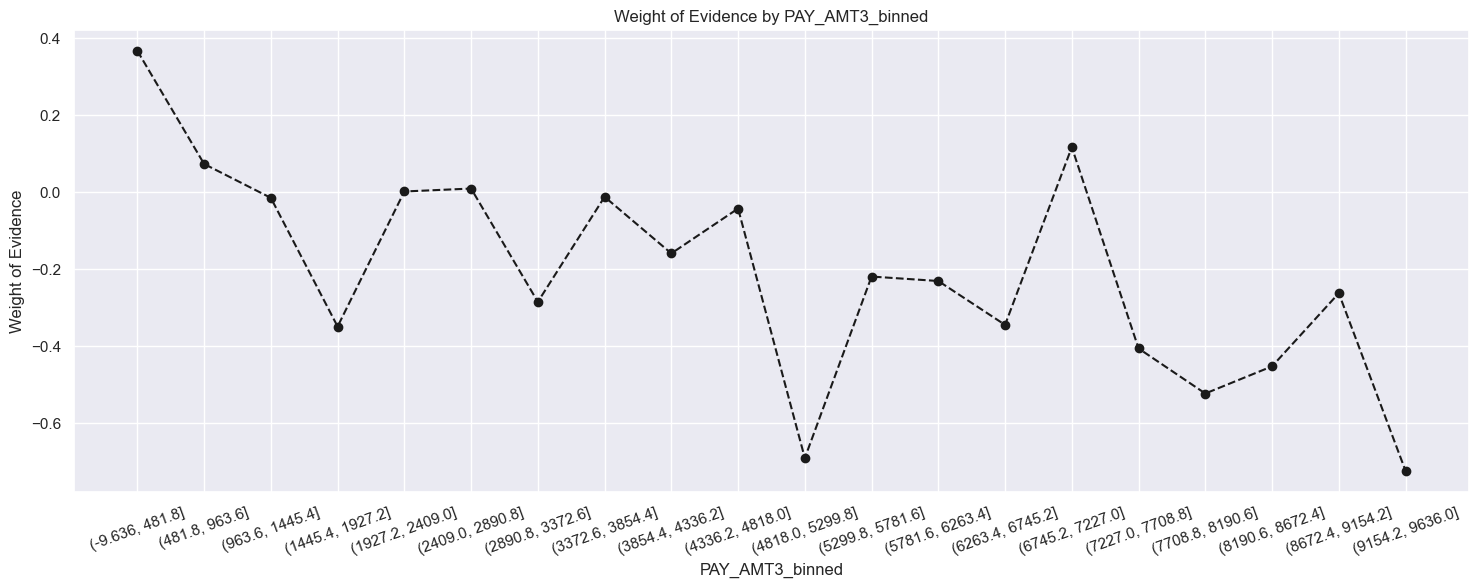

In [116]:
plot_by_woe(df_temp, 20)

In [120]:
df_temp = woe_ordered_continuous(data_training_new, 'PAY_AMT4', 'default payment next month')
df_temp

Optimal Number of Bins: 20


PAY_AMT4_binned  n_obs  prop_good  prop_n_obs  n_good   n_bad  \
0    (-9.634, 481.7]   5949   0.293663     0.29745  1747.0  4202.0   
1     (481.7, 963.4]   1707   0.244288     0.08535   417.0  1290.0   
2    (963.4, 1445.1]   2251   0.235451     0.11255   530.0  1721.0   
3   (1445.1, 1926.8]   3123   0.183477     0.15615   573.0  2550.0   
4   (1926.8, 2408.5]   1509   0.203446     0.07545   307.0  1202.0   
5   (2408.5, 2890.2]    618   0.220065     0.03090   136.0   482.0   
6   (2890.2, 3371.9]   1091   0.181485     0.05455   198.0   893.0   
7   (3371.9, 3853.6]    467   0.220557     0.02335   103.0   364.0   
8   (3853.6, 4335.3]    570   0.191228     0.02850   109.0   461.0   
9   (4335.3, 4817.0]    297   0.151515     0.01485    45.0   252.0   
10  (4817.0, 5298.7]    847   0.144038     0.04235   122.0   725.0   
11  (5298.7, 5780.4]    243   0.193416     0.01215    47.0   196.0   
12  (5780.4, 6262.1]    342   0.175439     0.01710    60.0   282.0   
13  (6262.1, 6743.8]    176   0.176136     0.00880    31.0   145.0   
14  (6743.8, 7225.5]    233   0.171674     0.01165    40.0   193.0   
15  (7225.5, 7707.2]    105   0.238095     0.00525    25.0    80.0   
16  (7707.2, 8188.9]    169   0.118343     0.00845    20.0   149.0   
17  (8188.9, 8670.6]     87   0.149425     0.00435    13.0    74.0   
18  (8670.6, 9152.3]    122   0.139344     0.00610    17.0   105.0   
19  (9152.3, 9634.0]     94   0.191489     0.00470    18.0    76.0   

    prop_n_good  prop_n_bad       WoE  diff_prop_good  diff_WoE        IV  \
0      0.383282    0.272115  0.342547             NaN       NaN  0.038080   
1      0.091487    0.083538  0.090896        0.049375  0.251651  0.000723   
2      0.116279    0.111449  0.042423        0.008837  0.048473  0.000205   
3      0.125713    0.165134 -0.272756        0.051973  0.315179  0.010752   
4      0.067354    0.077840 -0.144687        0.019969  0.128069  0.001517   
5      0.029838    0.031214 -0.045082        0.016619  0.099605  0.000062   
6      0.043440    0.057829 -0.286112        0.038580  0.241030  0.004117   
7      0.022598    0.023572 -0.042218        0.039072  0.243895  0.000041   
8      0.023914    0.029854 -0.221843        0.029329  0.179625  0.001318   
9      0.009873    0.016319 -0.502559        0.039713  0.280716  0.003240   
10     0.026766    0.046950 -0.561943        0.007477  0.059384  0.011342   
11     0.010312    0.012693 -0.207760        0.049378  0.354184  0.000495   
12     0.013164    0.018262 -0.327355        0.017977  0.119595  0.001669   
13     0.006801    0.009390 -0.322539        0.000698  0.004816  0.000835   
14     0.008776    0.012498 -0.353604        0.004463  0.031064  0.001316   
15     0.005485    0.005181  0.057056        0.066421  0.410660  0.000017   
16     0.004388    0.009649 -0.788007        0.119752  0.845063  0.004146   
17     0.002852    0.004792 -0.518909        0.031082  0.269098  0.001007   
18     0.003730    0.006800 -0.600540        0.010081  0.081631  0.001844   
19     0.003949    0.004922 -0.220154        0.052145  0.380385  0.000214   

    IV_total  
0   0.082939  
1   0.082939  
2   0.082939  
3   0.082939  
4   0.082939  
5   0.082939  
6   0.082939  
7   0.082939  
8   0.082939  
9   0.082939  
10  0.082939  
11  0.082939  
12  0.082939  
13  0.082939  
14  0.082939  
15  0.082939  
16  0.082939  
17  0.082939  
18  0.082939  
19  0.082939

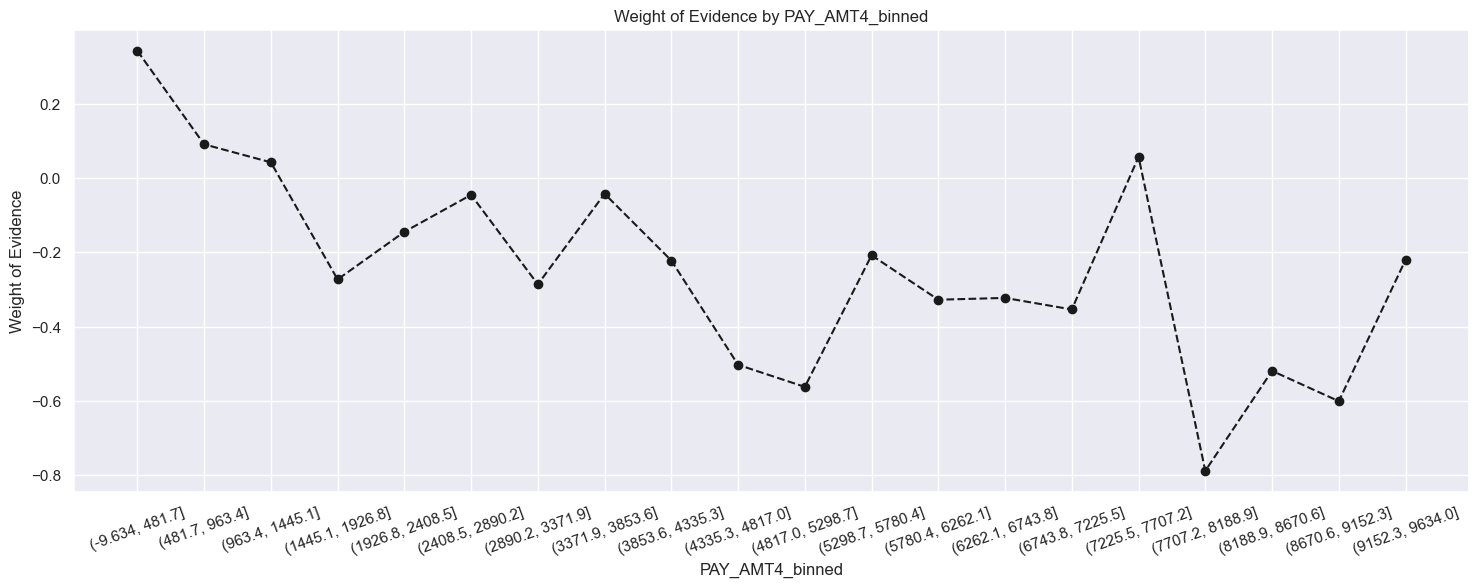

In [118]:
plot_by_woe(df_temp, 20)

In [121]:
df_temp = woe_ordered_continuous(data_training_new, 'PAY_AMT5', 'default payment next month')
df_temp

Optimal Number of Bins: 20


PAY_AMT5_binned  n_obs  prop_good  prop_n_obs  n_good   n_bad  \
0    (-9.672, 483.6]   5928   0.283738     0.29640  1682.0  4246.0   
1     (483.6, 967.2]   1636   0.245721     0.08180   402.0  1234.0   
2    (967.2, 1450.8]   2215   0.242438     0.11075   537.0  1678.0   
3   (1450.8, 1934.4]   3071   0.181374     0.15355   557.0  2514.0   
4   (1934.4, 2418.0]   1597   0.202254     0.07985   323.0  1274.0   
5   (2418.0, 2901.6]    633   0.227488     0.03165   144.0   489.0   
6   (2901.6, 3385.2]   1114   0.190305     0.05570   212.0   902.0   
7   (3385.2, 3868.8]    474   0.219409     0.02370   104.0   370.0   
8   (3868.8, 4352.4]    577   0.183709     0.02885   106.0   471.0   
9   (4352.4, 4836.0]    297   0.191919     0.01485    57.0   240.0   
10  (4836.0, 5319.6]    903   0.152824     0.04515   138.0   765.0   
11  (5319.6, 5803.2]    215   0.167442     0.01075    36.0   179.0   
12  (5803.2, 6286.8]    337   0.166172     0.01685    56.0   281.0   
13  (6286.8, 6770.4]    157   0.191083     0.00785    30.0   127.0   
14  (6770.4, 7254.0]    249   0.192771     0.01245    48.0   201.0   
15  (7254.0, 7737.6]    149   0.187919     0.00745    28.0   121.0   
16  (7737.6, 8221.2]    172   0.238372     0.00860    41.0   131.0   
17  (8221.2, 8704.8]     87   0.264368     0.00435    23.0    64.0   
18  (8704.8, 9188.4]    104   0.211538     0.00520    22.0    82.0   
19  (9188.4, 9672.0]     85   0.141176     0.00425    12.0    73.0   

    prop_n_good  prop_n_bad       WoE  diff_prop_good  diff_WoE            IV  \
0      0.369022    0.274964  0.294213             NaN       NaN  2.767286e-02   
1      0.088197    0.079912  0.098643        0.038017  0.195570  8.172228e-04   
2      0.117815    0.108665  0.080847        0.003283  0.017796  7.397654e-04   
3      0.122203    0.162803 -0.286858        0.061064  0.367705  1.164644e-02   
4      0.070864    0.082502 -0.152057        0.020880  0.134801  1.769621e-03   
5      0.031593    0.031667 -0.002342        0.025234  0.149715  1.734960e-07   
6      0.046512    0.058412 -0.227821        0.037183  0.225479  2.711184e-03   
7      0.022817    0.023961 -0.048905        0.029104  0.178916  5.592781e-05   
8      0.023256    0.030501 -0.271212        0.035700  0.222307  1.965043e-03   
9      0.012505    0.015542 -0.217381        0.008210  0.053831  6.600854e-04   
10     0.030276    0.049540 -0.492415        0.039095  0.275034  9.485773e-03   
11     0.007898    0.011592 -0.383660        0.014618  0.108755  1.417071e-03   
12     0.012286    0.018197 -0.392796        0.001270  0.009136  2.321830e-03   
13     0.006582    0.008224 -0.222783        0.024911  0.170013  3.659179e-04   
14     0.010531    0.013016 -0.211897        0.001688  0.010886  5.266724e-04   
15     0.006143    0.007836 -0.243379        0.004852  0.031482  4.119741e-04   
16     0.008995    0.008483  0.058582        0.050453  0.301961  2.998316e-05   
17     0.005046    0.004145  0.196818        0.025996  0.138236  1.774380e-04   
18     0.004827    0.005310 -0.095470        0.052829  0.292288  4.616097e-05   
19     0.002633    0.004727 -0.585346        0.070362  0.489876  1.226084e-03   

    IV_total  
0   0.064047  
1   0.064047  
2   0.064047  
3   0.064047  
4   0.064047  
5   0.064047  
6   0.064047  
7   0.064047  
8   0.064047  
9   0.064047  
10  0.064047  
11  0.064047  
12  0.064047  
13  0.064047  
14  0.064047  
15  0.064047  
16  0.064047  
17  0.064047  
18  0.064047  
19  0.064047

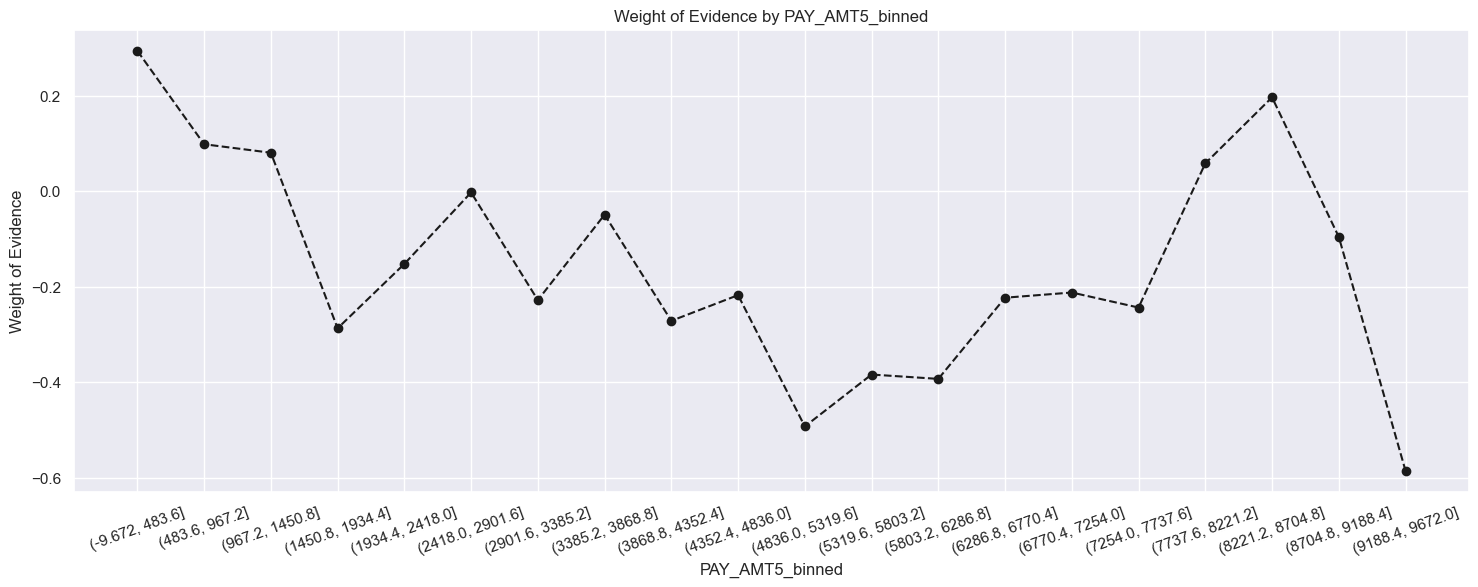

In [122]:
plot_by_woe(df_temp, 20)

In [123]:
df_temp = woe_ordered_continuous(data_training_new, 'PAY_AMT6', 'default payment next month')
df_temp

Optimal Number of Bins: 8


PAY_AMT6_binned  n_obs  prop_good  prop_n_obs  n_good   n_bad  \
0  (-9.974, 1246.75]   9654   0.269733     0.48270  2604.0  7050.0   
1  (1246.75, 2493.5]   5021   0.195379     0.25105   981.0  4040.0   
2  (2493.5, 3740.25]   2025   0.205926     0.10125   417.0  1608.0   
3  (3740.25, 4987.0]   1013   0.173741     0.05065   176.0   837.0   
4  (4987.0, 6233.75]   1346   0.155275     0.06730   209.0  1137.0   
5  (6233.75, 7480.5]    423   0.196217     0.02115    83.0   340.0   
6  (7480.5, 8727.25]    312   0.182692     0.01560    57.0   255.0   
7  (8727.25, 9974.0]    206   0.150485     0.01030    31.0   175.0   

   prop_n_good  prop_n_bad       WoE  diff_prop_good  diff_WoE        IV  \
0     0.571303    0.456547  0.224228             NaN       NaN  0.025732   
1     0.215226    0.261624 -0.195220        0.074353  0.419449  0.009058   
2     0.091487    0.104132 -0.129453        0.010547  0.065767  0.001637   
3     0.038613    0.054203 -0.339133        0.032185  0.209680  0.005287   
4     0.045853    0.073630 -0.473607        0.018466  0.134474  0.013155   
5     0.018210    0.022018 -0.189898        0.040943  0.283709  0.000723   
6     0.012505    0.016513 -0.278005        0.013525  0.088107  0.001114   
7     0.006801    0.011333 -0.510592        0.032207  0.232586  0.002314   

   IV_total  
0   0.05902  
1   0.05902  
2   0.05902  
3   0.05902  
4   0.05902  
5   0.05902  
6   0.05902  
7   0.05902

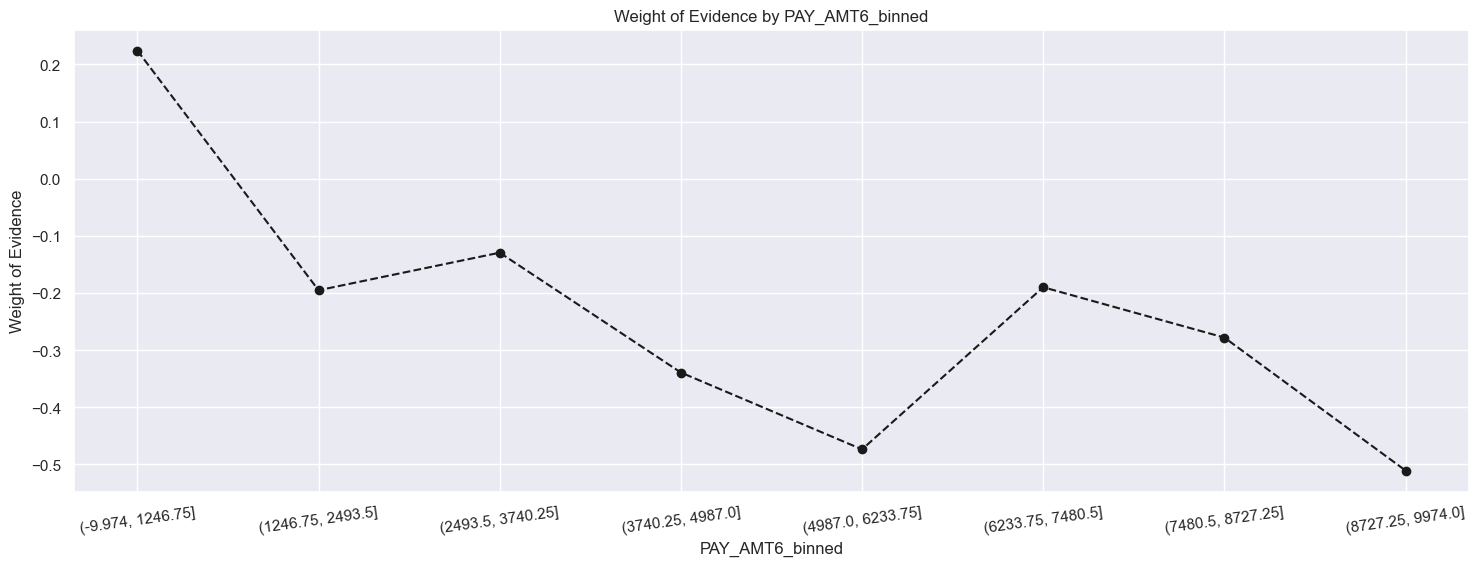

In [124]:
plot_by_woe(df_temp, 8)

In [125]:
df_temp = woe_ordered_continuous(data_training_new, 'LIMIT_BAL', 'default payment next month')
df_temp

Optimal Number of Bins: 15


LIMIT_BAL_binned  n_obs  prop_good  prop_n_obs  n_good   n_bad  \
0        (9510.0, 42666.667]   3024   0.364087     0.15120  1101.0  1923.0   
1     (42666.667, 75333.333]   3423   0.270523     0.17115   926.0  2497.0   
2      (75333.333, 108000.0]   2201   0.248523     0.11005   547.0  1654.0   
3     (108000.0, 140666.667]   2007   0.216243     0.10035   434.0  1573.0   
4   (140666.667, 173333.333]   1519   0.177749     0.07595   270.0  1249.0   
5     (173333.333, 206000.0]   1792   0.189174     0.08960   339.0  1453.0   
6     (206000.0, 238666.667]   1243   0.163315     0.06215   203.0  1040.0   
7   (238666.667, 271333.333]   1126   0.168739     0.05630   190.0   936.0   
8     (271333.333, 304000.0]    867   0.168397     0.04335   146.0   721.0   
9     (304000.0, 336666.667]    473   0.133192     0.02365    63.0   410.0   
10  (336666.667, 369333.333]    856   0.167056     0.04280   143.0   713.0   
11    (369333.333, 402000.0]    444   0.126126     0.02220    56.0   388.0   
12    (402000.0, 434666.667]    193   0.155440     0.00965    30.0   163.0   
13  (434666.667, 467333.333]    212   0.160377     0.01060    34.0   178.0   
14    (467333.333, 500000.0]    620   0.122581     0.03100    76.0   544.0   

    prop_n_good  prop_n_bad       WoE  diff_prop_good  diff_WoE        IV  \
0      0.241553    0.124531  0.662540             NaN       NaN  0.077532   
1      0.203159    0.161702  0.228236        0.093564  0.434303  0.009462   
2      0.120009    0.107110  0.113704        0.022000  0.114532  0.001467   
3      0.095217    0.101865 -0.067488        0.032280  0.181192  0.000449   
4      0.059237    0.080883 -0.311469        0.038495  0.243981  0.006742   
5      0.074375    0.094094 -0.235178        0.011426  0.076291  0.004638   
6      0.044537    0.067349 -0.413563        0.025860  0.178384  0.009434   
7      0.041685    0.060614 -0.374384        0.005424  0.039179  0.007087   
8      0.032032    0.046691 -0.376825        0.000342  0.002441  0.005524   
9      0.013822    0.026551 -0.652815        0.035204  0.275990  0.008310   
10     0.031373    0.046173 -0.386430        0.033864  0.266386  0.005719   
11     0.012286    0.025126 -0.715447        0.040930  0.329017  0.009186   
12     0.006582    0.010556 -0.472346        0.029314  0.243101  0.001877   
13     0.007459    0.011527 -0.435216        0.004937  0.037130  0.001770   
14     0.016674    0.035229 -0.748009        0.037797  0.312793  0.013879   

    IV_total  
0   0.163076  
1   0.163076  
2   0.163076  
3   0.163076  
4   0.163076  
5   0.163076  
6   0.163076  
7   0.163076  
8   0.163076  
9   0.163076  
10  0.163076  
11  0.163076  
12  0.163076  
13  0.163076  
14  0.163076

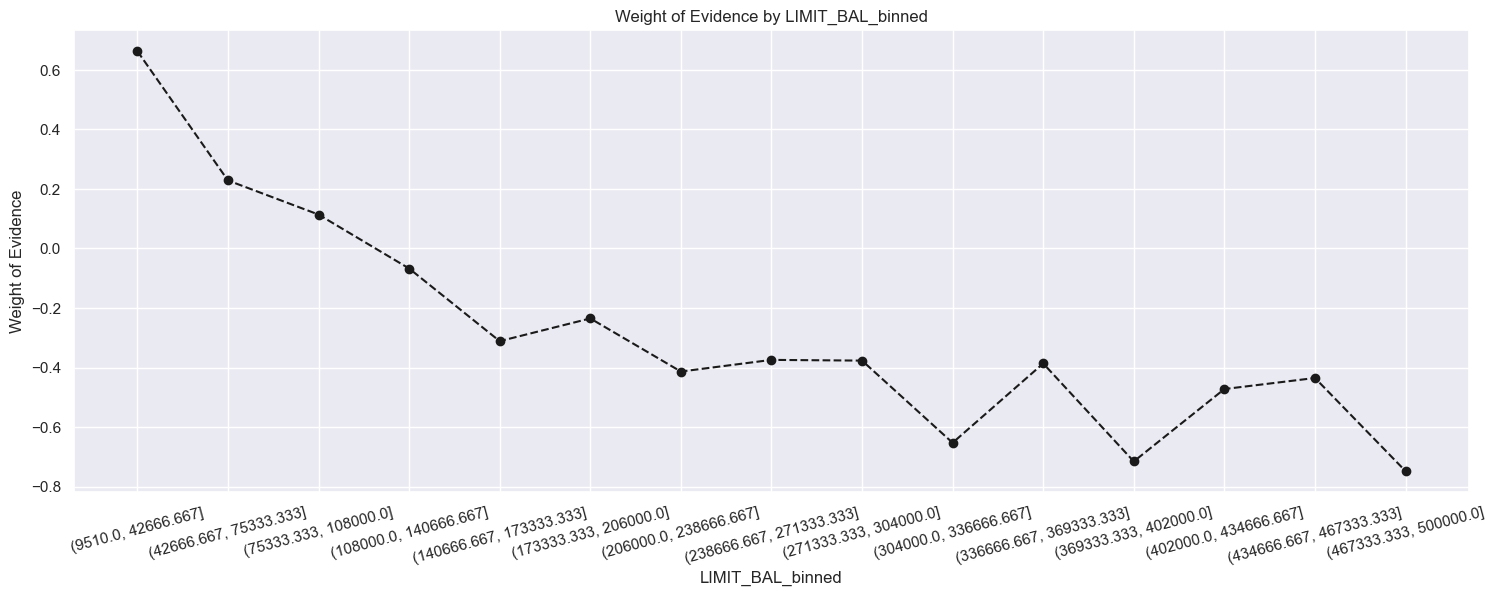

In [126]:
plot_by_woe(df_temp, 15)

In [127]:
df_temp = woe_ordered_continuous(data_training_new, 'BILL_AMT1', 'default payment next month')
df_temp

Optimal Number of Bins: 10


BILL_AMT1_binned  n_obs  prop_good  prop_n_obs  n_good   n_bad  \
0   (-15480.43, 1935.0]   3978   0.239065     0.19890   951.0  3027.0   
1     (1935.0, 19178.0]   5375   0.237767     0.26875  1278.0  4097.0   
2    (19178.0, 36421.0]   4222   0.234486     0.21110   990.0  3232.0   
3    (36421.0, 53664.0]   2230   0.223318     0.11150   498.0  1732.0   
4    (53664.0, 70907.0]   1131   0.207781     0.05655   235.0   896.0   
5    (70907.0, 88150.0]    974   0.220739     0.04870   215.0   759.0   
6   (88150.0, 105393.0]    699   0.187411     0.03495   131.0   568.0   
7  (105393.0, 122636.0]    552   0.186594     0.02760   103.0   449.0   
8  (122636.0, 139879.0]    463   0.203024     0.02315    94.0   369.0   
9  (139879.0, 157122.0]    376   0.167553     0.01880    63.0   313.0   

   prop_n_good  prop_n_bad       WoE  diff_prop_good  diff_WoE        IV  \
0     0.208644    0.196024  0.062394             NaN       NaN  0.000787   
1     0.280386    0.265315  0.055248        0.001297  0.007145  0.000833   
2     0.217201    0.209299  0.037056        0.003281  0.018193  0.000293   
3     0.109258    0.112162 -0.026225        0.011168  0.063281  0.000076   
4     0.051558    0.058024 -0.118148        0.015538  0.091923  0.000764   
5     0.047170    0.049152 -0.041157        0.012958  0.076991  0.000082   
6     0.028741    0.036783 -0.246717        0.033329  0.205560  0.001984   
7     0.022598    0.029077 -0.252087        0.000816  0.005370  0.001633   
8     0.020623    0.023896 -0.147295        0.016430  0.104792  0.000482   
9     0.013822    0.020269 -0.382861        0.035471  0.235567  0.002469   

   IV_total  
0  0.009402  
1  0.009402  
2  0.009402  
3  0.009402  
4  0.009402  
5  0.009402  
6  0.009402  
7  0.009402  
8  0.009402  
9  0.009402

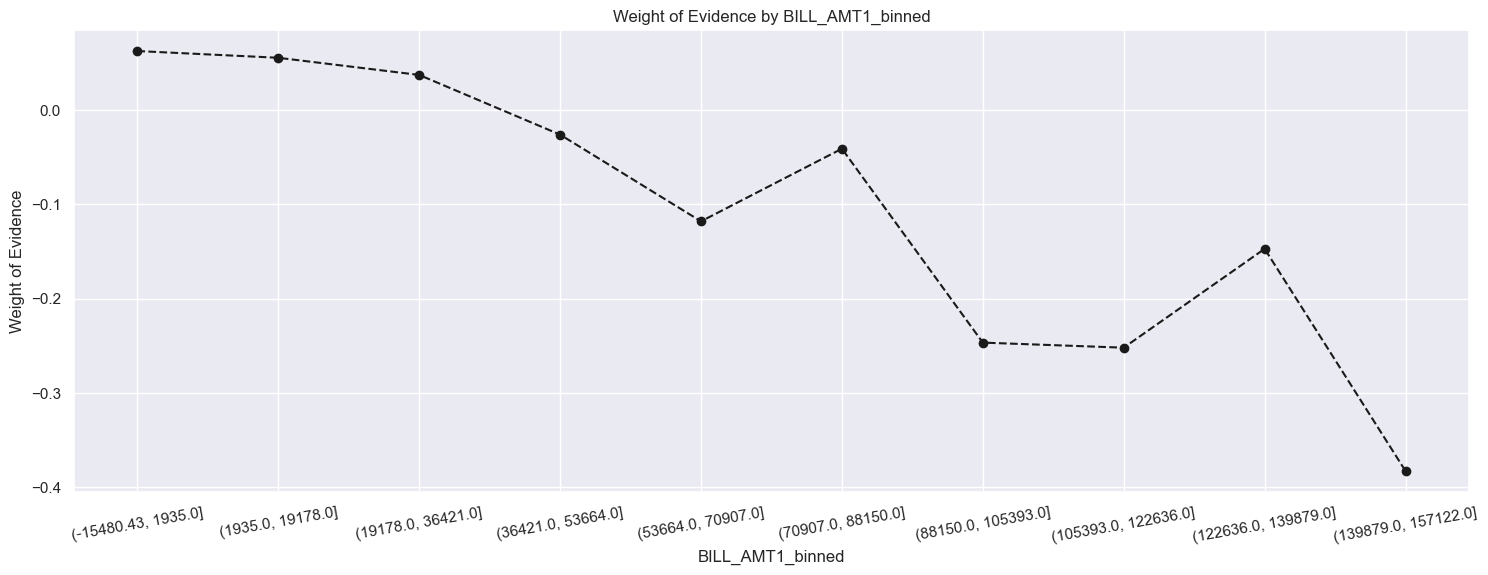

In [128]:
plot_by_woe(df_temp, 10)

#### Based on the Information Value calculated using the WoE, only 6 features were eventually selected, viz:

1. LIMIT_BAL (IV score of 0.16)
2. PAY_AMT1 (IV score of 0.14)
3. PAY_AMT2 (IV score of 0.11)
3. EDUCATION (IV score of 0.03 - It was selected since it was the highest amongst the demographic features)
4. PAY_6 (IV score of 0.27)
5. PAY_0 (IV score of 0.86)

### Creating Binary Features 

Binary features are created using by grouping categories (or range) with similar WoE or small number of samples together. This way, we can create features that are relatively more stable, robust to outlier, and easy to interpret.

In [130]:
def bin_data(X):
    binned_features = pd.DataFrame()

    binned_features["PAY_AMT1: <1008"] = np.where((X['PAY_AMT1'] < 1008), 1, 0)
    binned_features["PAY_AMT1: 1008 - 2016"] = np.where((X['PAY_AMT1'] >= 1008) & (X['PAY_AMT1'] < 2016), 1, 0)
    binned_features["PAY_AMT1: 2016 - 3024"] = np.where((X['PAY_AMT1'] >= 2016) & (X['PAY_AMT1'] < 3024), 1, 0)
    binned_features["PAY_AMT1: 3024 - 4032"] = np.where((X['PAY_AMT1'] >= 3024) & (X['PAY_AMT1'] < 4032), 1, 0)
    binned_features["PAY_AMT1: >=4032"] = np.where((X['PAY_AMT1'] >= 4032), 1, 0)
    
    binned_features["PAY_AMT2: <1008"] = np.where((X['PAY_AMT2'] < 1008), 1, 0)
    binned_features["PAY_AMT2: 1008 - 2016"] = np.where((X['PAY_AMT2'] >= 1008) & (X['PAY_AMT2'] < 2016), 1, 0)
    binned_features["PAY_AMT2: 2016 - 3024"] = np.where((X['PAY_AMT2'] >= 2016) & (X['PAY_AMT2'] < 3024), 1, 0)
    binned_features["PAY_AMT2: 3024 - 4032"] = np.where((X['PAY_AMT2'] >= 3024) & (X['PAY_AMT2'] < 4032), 1, 0)
    binned_features["PAY_AMT2: >=4032"] = np.where((X['PAY_AMT2'] >= 4032), 1, 0)

    binned_features["LIMIT_BAL: <42666.667"] = np.where((X['LIMIT_BAL'] < 42666.667), 1, 0)
    binned_features["LIMIT_BAL: 42666.667 - 140666.667"] = np.where((X['LIMIT_BAL'] >= 42666.667) & (X['LIMIT_BAL'] < 140667.667), 1, 0)
    binned_features["LIMIT_BAL: 140666.667 - 173333.33"] = np.where((X['LIMIT_BAL'] >= 140666.667) & (X['LIMIT_BAL'] < 173333.33), 1, 0)
    binned_features["LIMIT_BAL: 173333.33 - 304000"] = np.where((X['LIMIT_BAL'] >= 173333.33) & (X['LIMIT_BAL'] < 304000), 1, 0)
    binned_features["LIMIT_BAL: >=304000"] = np.where((X['LIMIT_BAL'] >= 304000), 1, 0)

    binned_features["PAY_0: -2"] = np.where((X['PAY_0'] == -2), 1, 0)
    binned_features["PAY_0: -1"] = np.where((X['PAY_0'] == -1), 1, 0)
    binned_features["PAY_0: 0"] = np.where((X['PAY_0'] == 0), 1, 0)
    binned_features["PAY_0: 1"] = np.where((X['PAY_0'] == 1), 1, 0)
    binned_features["PAY_0: 2"] = np.where((X['PAY_0'] == 2), 1, 0)
    binned_features["PAY_0: >2"] = np.where((X['PAY_0'] > 2), 1, 0)

    binned_features["PAY_6: -2"] = np.where((X['PAY_6'] == -2), 1, 0)
    binned_features["PAY_6: -1 - 0"] = np.where((X['PAY_6'] >= -1) & (X['PAY_6'] <= 0), 1, 0)
    binned_features["PAY_6: 1"] = np.where((X['PAY_6'] == 1), 1, 0)
    binned_features["PAY_6: 2"] = np.where((X['PAY_6'] == 2), 1, 0)
    binned_features["PAY_6: >3"] = np.where((X['PAY_6'] >= 3), 1, 0)

    binned_features["EDUCATION: 1"] = np.where((X['EDUCATION'] == 1), 1, 0)
    binned_features["EDUCATION: 2"] = np.where((X['EDUCATION'] == 2), 1, 0)
    binned_features["EDUCATION: 3"] = np.where((X['EDUCATION'] == 3), 1, 0)
    binned_features["EDUCATION: 0; 4 - 6"] = np.where(((X['EDUCATION'] >= 4) & (X['EDUCATION'] <= 6)) | (X['EDUCATION'] == 0), 1, 0)
    
    

    return binned_features

In [131]:
data_training_new_bin = pd.concat([bin_data(data_training_new), data_training_new['default payment next month']], axis=1)

## Modelling

In [132]:
#data with only the binary features
X = data_training_new_bin.drop('default payment next month', axis=1)
y = data_training_new_bin['default payment next month']

In [133]:
#data with the 6 selected features without converting them to binary features
data_without_bin = data_training_new[["LIMIT_BAL", "PAY_AMT1", "PAY_AMT6", "EDUCATION", "PAY_6", "PAY_0", 'default payment next month']]
X_with_6_selected_feats = data_without_bin.drop('default payment next month', axis=1)
y_with_6_selected_feats = data_without_bin['default payment next month']

In [134]:
#data with all the features without feature selection. 
X_with_all_feats = data_training.drop('default payment next month', axis=1)
y_with_all_feats = data_training['default payment next month']

#### Logistic Regression

In [135]:
#setting classs_weight as balanced helps to handle imbalanced dataset. Although m
classifier_1 = LogisticRegression(max_iter=1000, class_weight = 'balanced')
# define cross-validation criteria. RepeatedStratifiedKFold automatially takes care of the class imbalance while splitting.
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# fit and evaluate the logistic regression pipeline with cross-validation as defined in cv
scores = cross_val_score(classifier_1, X, y, scoring = 'roc_auc', cv = cv)
AUROC = np.mean(scores)
GINI = AUROC * 2 - 1

# print the mean AUROC score and Gini
print('Mean AUROC: %.4f' % (AUROC))
print('Gini: %.4f' % (GINI))

Mean AUROC: 0.7563
Gini: 0.5127


In [136]:
classifier_1 = LogisticRegression(max_iter=1000, class_weight = 'balanced')
# define cross-validation criteria. RepeatedStratifiedKFold automatially takes care of the class imbalance while splitting
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# fit and evaluate the logistic regression pipeline with cross-validation as defined in cv
scores = cross_val_score(classifier_1, X_with_6_selected_feats, y_with_6_selected_feats, scoring = 'roc_auc', cv = cv)
AUROC = np.mean(scores)
GINI = AUROC * 2 - 1

# print the mean AUROC score and Gini
print('Mean AUROC: %.4f' % (AUROC))
print('Gini: %.4f' % (GINI))

Mean AUROC: 0.6577
Gini: 0.3154


In [137]:
classifier_1 = LogisticRegression(max_iter=1000, class_weight = 'balanced')
# define cross-validation criteria. RepeatedStratifiedKFold automatially takes care of the class imbalance while splitting
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# fit and evaluate the logistic regression pipeline with cross-validation as defined in cv
scores = cross_val_score(classifier_1, X_with_all_feats, y_with_all_feats, scoring = 'roc_auc', cv = cv)
AUROC = np.mean(scores)
GINI = AUROC * 2 - 1

# print the mean AUROC score and Gini
print('Mean AUROC: %.4f' % (AUROC))
print('Gini: %.4f' % (GINI))

C:\Users\Ighdaro Emwinghare\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Mean AUROC: 0.6422
Gini: 0.2843


##### We see that the model built using the binary features created from the 5 selected variables had the highes AUC of 0.75 and Gini of 0.51

### Random Forest

In [138]:
#we set class_weight to 'balanced_subsample' to help deal with data imbalanced
classifier_2 = RandomForestClassifier(n_estimators=100, random_state = 0, class_weight = 'balanced_subsample')
# define cross-validation criteria. RepeatedStratifiedKFold automatially takes care of the class imbalance while splitting
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# fit and evaluate the logistic regression pipeline with cross-validation as defined in cv
scores = cross_val_score(classifier_2, X, y, scoring = 'roc_auc', cv = cv)
AUROC = np.mean(scores)
GINI = AUROC * 2 - 1

# print the mean AUROC score and Gini
print('Mean AUROC: %.4f' % (AUROC))
print('Gini: %.4f' % (GINI))

Mean AUROC: 0.7134
Gini: 0.4268


In [139]:
classifier_2 = RandomForestClassifier(n_estimators=100, random_state = 0, class_weight = 'balanced_subsample')
# define cross-validation criteria. RepeatedStratifiedKFold automatially takes care of the class imbalance while splitting
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# fit and evaluate the logistic regression pipeline with cross-validation as defined in cv
scores = cross_val_score(classifier_2, X_with_6_selected_feats, y_with_6_selected_feats, scoring = 'roc_auc', cv = cv)
AUROC = np.mean(scores)
GINI = AUROC * 2 - 1

# print the mean AUROC score and Gini
print('Mean AUROC: %.4f' % (AUROC))
print('Gini: %.4f' % (GINI))

Mean AUROC: 0.7123
Gini: 0.4246


In [140]:
classifier_2 = RandomForestClassifier(n_estimators=100, random_state = 0, class_weight = 'balanced_subsample')
# define cross-validation criteria. RepeatedStratifiedKFold automatially takes care of the class imbalance while splitting
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# fit and evaluate the logistic regression pipeline with cross-validation as defined in cv
scores = cross_val_score(classifier_2, X_with_all_feats, y_with_all_feats, scoring = 'roc_auc', cv = cv)
AUROC = np.mean(scores)
GINI = AUROC * 2 - 1

# print the mean AUROC score and Gini
print('Mean AUROC: %.4f' % (AUROC))
print('Gini: %.4f' % (GINI))

Mean AUROC: 0.7535
Gini: 0.5071


Among the six models developed, the Random Forest Classifier, trained without feature selection, and the Logisitc model trained on binary features emerged as the top performer with an AUC of 0.75 and a Gini coefficient of 0.51. Given the simplicity and the ease of interpreting coefficients for credit score estimation, the Logistic Regression model was chosen for further evaluation.

In [144]:
#Training the Logistic Regression model on all the dataset of binary variables
classifier = LogisticRegression(max_iter=1000, class_weight = 'balanced')

classifier.fit(X, y)

feature_name = X.columns.values
# Create a summary table of our logistic regression model
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
# Create a new column in the dataframe, called 'Coefficients', with row values the transposed coefficients from the 'LogisticRegression' model
summary_table['Coefficients'] = np.transpose(classifier.coef_)
# Increase the index of every row of the dataframe with 1 to store our model intercept in 1st row
summary_table.index = summary_table.index + 1
# Assign our model intercept to this new row
summary_table.loc[0] = ['Intercept', classifier.intercept_[0]]
# Sort the dataframe by index
summary_table.sort_index(inplace = True)
summary_table

Feature name  Coefficients
0                           Intercept      0.098190
1                     PAY_AMT1: <1008      0.188341
2               PAY_AMT1: 1008 - 2016      0.077521
3               PAY_AMT1: 2016 - 3024     -0.035139
4               PAY_AMT1: 3024 - 4032      0.045446
5                    PAY_AMT1: >=4032     -0.188531
6                     PAY_AMT2: <1008      0.276432
7               PAY_AMT2: 1008 - 2016     -0.042902
8               PAY_AMT2: 2016 - 3024     -0.083601
9               PAY_AMT2: 3024 - 4032     -0.056848
10                   PAY_AMT2: >=4032     -0.005444
11              LIMIT_BAL: <42666.667      0.476177
12  LIMIT_BAL: 42666.667 - 140666.667      0.156264
13  LIMIT_BAL: 140666.667 - 173333.33     -0.155393
14      LIMIT_BAL: 173333.33 - 304000     -0.132790
15                LIMIT_BAL: >=304000     -0.256621
16                          PAY_0: -2     -0.948916
17                          PAY_0: -1     -0.579856
18                           PAY_0: 0     -0.933075
19                           PAY_0: 1     -0.021045
20                           PAY_0: 2      1.432305
21                          PAY_0: >2      1.138225
22                          PAY_6: -2     -0.260518
23                      PAY_6: -1 - 0     -0.332149
24                           PAY_6: 1      0.000000
25                           PAY_6: 2      0.340763
26                          PAY_6: >3      0.339541
27                       EDUCATION: 1      0.309297
28                       EDUCATION: 2      0.349994
29                       EDUCATION: 3      0.343403
30                EDUCATION: 0; 4 - 6     -0.915056

## Model Evaluation and Validation

In [145]:
#we will be using the data_os to evaluate the model. 
X_test = bin_data(data_os) #transform the data to binary variables
y_test = data_os['default payment next month']

In [146]:
X_test.head(10)

PAY_AMT1: <1008  PAY_AMT1: 1008 - 2016  PAY_AMT1: 2016 - 3024  \
0                0                      1                      0   
1                1                      0                      0   
2                0                      0                      1   
3                0                      0                      0   
4                1                      0                      0   
5                1                      0                      0   
6                0                      0                      1   
7                1                      0                      0   
8                0                      0                      1   
9                0                      0                      0   

   PAY_AMT1: 3024 - 4032  PAY_AMT1: >=4032  PAY_AMT2: <1008  \
0                      0                 0                0   
1                      0                 0                0   
2                      0                 0                1   
3                      0                 1                0   
4                      0                 0                0   
5                      0                 0                1   
6                      0                 0                0   
7                      0                 0                1   
8                      0                 0                0   
9                      0                 1                0   

   PAY_AMT2: 1008 - 2016  PAY_AMT2: 2016 - 3024  PAY_AMT2: 3024 - 4032  \
0                      0                      0                      0   
1                      1                      0                      0   
2                      0                      0                      0   
3                      0                      0                      0   
4                      1                      0                      0   
5                      0                      0                      0   
6                      1                      0                      0   
7                      0                      0                      0   
8                      0                      0                      0   
9                      0                      0                      0   

   PAY_AMT2: >=4032  ...  PAY_0: >2  PAY_6: -2  PAY_6: -1 - 0  PAY_6: 1  \
0                 1  ...          0          0              1         0   
1                 0  ...          1          0              1         0   
2                 0  ...          0          1              0         0   
3                 1  ...          0          0              1         0   
4                 0  ...          0          1              0         0   
5                 0  ...          0          0              1         0   
6                 0  ...          0          0              1         0   
7                 0  ...          0          0              1         0   
8                 1  ...          0          0              1         0   
9                 1  ...          0          1              0         0   

   PAY_6: 2  PAY_6: >3  EDUCATION: 1  EDUCATION: 2  EDUCATION: 3  \
0         0          0             1             0             0   
1         0          0             1             0             0   
2         0          0             1             0             0   
3         0          0             1             0             0   
4         0          0             1             0             0   
5         0          0             1             0             0   
6         0          0             0             1             0   
7         0          0             0             1             0   
8         0          0             1             0             0   
9         0          0             1             0             0   

   EDUCATION: 0; 4 - 6  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  
5                   

In [147]:
y_test_predict = classifier.predict(X_test)
y_test_predict_proba = classifier.predict_proba(X_test)[:][: , 1]

In [148]:
y_test_temp = y_test.copy()
y_test_temp.reset_index(drop = True, inplace = True)
y_test_proba_df = pd.concat([y_test_temp, pd.DataFrame(y_test_predict_proba)], axis = 1)
y_test_proba_df.shape

(10000, 2)

In [149]:
y_test_proba_df.columns = ['y_test_class_actual', 'y_test_predict_proba']
# Makes the index of one dataframe equal to the index of another dataframe.
y_test_proba_df.index = X_test.index
y_test_proba_df.head()

y_test_class_actual  y_test_predict_proba
0                    1              0.362338
1                    0              0.819840
2                    0              0.333267
3                    0              0.277858
4                    0              0.286360

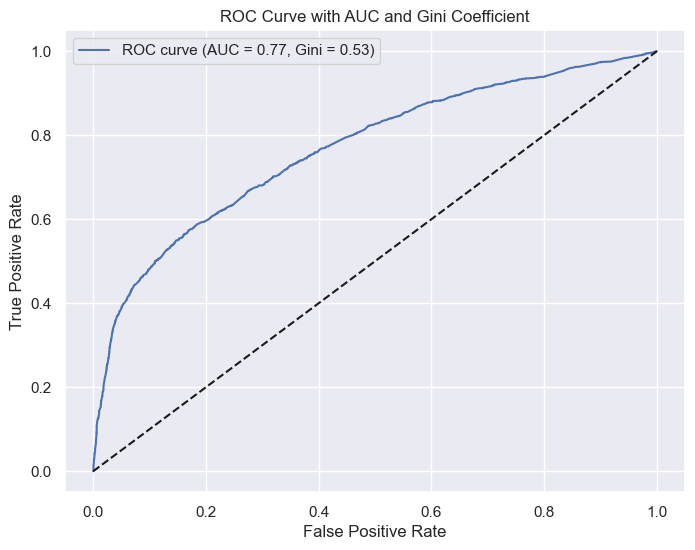

In [150]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_proba_df['y_test_class_actual'], y_test_proba_df['y_test_predict_proba'])

# Calculate AUC
auc = roc_auc_score(y_test_proba_df['y_test_class_actual'], y_test_proba_df['y_test_predict_proba'])

# Calculate Gini Coefficient
gini = 2 * auc - 1

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f}, Gini = {gini:.2f})')
plt.plot(fpr, fpr, linestyle='--', color='k')

# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with AUC and Gini Coefficient')
plt.legend(loc='best')

plt.show()

In [151]:
# Calculate Youden's J-Statistic to identify the best threshhold
J = tpr - fpr
# locate the index of the largest J
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold: %f' % (best_thresh))

Best Threshold: 0.478403


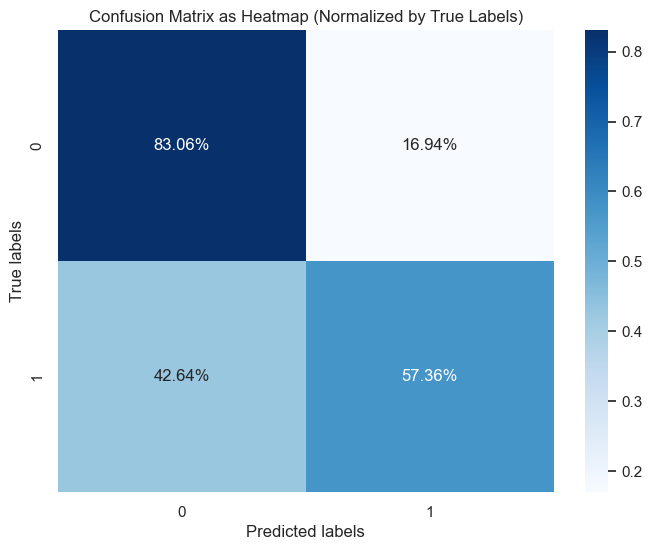

In [152]:
tr = 0.478403

# Create a new column for the predicted class based on predicted probabilities and threshold
y_test_proba_df['y_test_class_predicted'] = np.where(y_test_proba_df['y_test_predict_proba'] > tr, 1, 0)

# Create the confusion matrix, normalized by row (true labels)
cm = confusion_matrix(y_test_proba_df['y_test_class_actual'], y_test_proba_df['y_test_class_predicted'], normalize='true')

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues')

# Adding labels and title for clarity
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix as Heatmap (Normalized by True Labels)')

plt.show()


In [153]:
bin_labels =['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
#data_hold_out['dist'] = pd.qcut(data_hold_out['Prediction'], q=10, labels=bin_labels)
y_test_proba_df['dist'] =  pd.qcut(y_test_proba_df['y_test_predict_proba'], q=10, labels=bin_labels)

In [154]:
y_test_proba_df.groupby('dist')[['y_test_class_actual','y_test_predict_proba']].mean().reset_index()

dist  y_test_class_actual  y_test_predict_proba
0    1             0.065476              0.205480
1    2             0.071429              0.244503
2    3             0.081162              0.279749
3    4             0.107722              0.308807
4    5             0.133668              0.340434
5    6             0.163180              0.368211
6    7             0.186255              0.419025
7    8             0.216783              0.490588
8    9             0.345274              0.638326
9   10             0.715152              0.866252

Based on the data_os, we see that the AUC and Gini Norm were 0.76 and 0.53, respectively, which is consistent with we got with our 5-fold stratified cross validation. This shows that we the model is not over-fitting the training data. More so, we see from the table above, that as the probability of default increases across the bin, the default rate increases as well, which is another measure of how well our model discriminates across different risk buckets.

#### Scorecard Development and Calibration

In [155]:
df_scorecard = pd.concat([summary_table, summary_table['Feature name'].str.split(':').str[0]], axis=1)

In [156]:
df_scorecard.columns = ['Feature Name', 'Coefficients', 'Original Feature Name']

In [157]:
df_scorecard

Feature Name  Coefficients Original Feature Name
0                           Intercept      0.098190             Intercept
1                     PAY_AMT1: <1008      0.188341              PAY_AMT1
2               PAY_AMT1: 1008 - 2016      0.077521              PAY_AMT1
3               PAY_AMT1: 2016 - 3024     -0.035139              PAY_AMT1
4               PAY_AMT1: 3024 - 4032      0.045446              PAY_AMT1
5                    PAY_AMT1: >=4032     -0.188531              PAY_AMT1
6                     PAY_AMT2: <1008      0.276432              PAY_AMT2
7               PAY_AMT2: 1008 - 2016     -0.042902              PAY_AMT2
8               PAY_AMT2: 2016 - 3024     -0.083601              PAY_AMT2
9               PAY_AMT2: 3024 - 4032     -0.056848              PAY_AMT2
10                   PAY_AMT2: >=4032     -0.005444              PAY_AMT2
11              LIMIT_BAL: <42666.667      0.476177             LIMIT_BAL
12  LIMIT_BAL: 42666.667 - 140666.667      0.156264             LIMIT_BAL
13  LIMIT_BAL: 140666.667 - 173333.33     -0.155393             LIMIT_BAL
14      LIMIT_BAL: 173333.33 - 304000     -0.132790             LIMIT_BAL
15                LIMIT_BAL: >=304000     -0.256621             LIMIT_BAL
16                          PAY_0: -2     -0.948916                 PAY_0
17                          PAY_0: -1     -0.579856                 PAY_0
18                           PAY_0: 0     -0.933075                 PAY_0
19                           PAY_0: 1     -0.021045                 PAY_0
20                           PAY_0: 2      1.432305                 PAY_0
21                          PAY_0: >2      1.138225                 PAY_0
22                          PAY_6: -2     -0.260518                 PAY_6
23                      PAY_6: -1 - 0     -0.332149                 PAY_6
24                           PAY_6: 1      0.000000                 PAY_6
25                           PAY_6: 2      0.340763                 PAY_6
26                          PAY_6: >3      0.339541                 PAY_6
27                       EDUCATION: 1      0.309297             EDUCATION
28                       EDUCATION: 2      0.349994             EDUCATION
29                       EDUCATION: 3      0.343403             EDUCATION
30                EDUCATION: 0; 4 - 6     -0.915056             EDUCATION

In [158]:
# Define the min and max thresholds for our scorecard
min_score = 300
max_score = 900

# Calculate the sum of the minimum coefficients of each category within the original feature name
min_sum_coef = df_scorecard.groupby('Original Feature Name')['Coefficients'].min().sum()

# Calculate the sum of the maximum coefficients of each category within the original feature name
max_sum_coef = df_scorecard.groupby('Original Feature Name')['Coefficients'].max().sum()

# Adjust the coefficients to reflect lower risk with higher scores
df_scorecard['Adjusted Coefficients'] = -df_scorecard['Coefficients']

# Calculate the sum of the adjusted minimum and maximum coefficients
adjusted_min_sum_coef = df_scorecard.groupby('Original Feature Name')['Adjusted Coefficients'].min().sum()
adjusted_max_sum_coef = df_scorecard.groupby('Original Feature Name')['Adjusted Coefficients'].max().sum()

# Create a new column that has the imputed calculated Score based on the adjusted coefficients
df_scorecard['Score - Calculation'] = df_scorecard['Adjusted Coefficients'] * (max_score - min_score) / (adjusted_max_sum_coef - adjusted_min_sum_coef)

# Update the calculated score of the Intercept
df_scorecard.loc[0, 'Score - Calculation'] = ((df_scorecard.loc[0,'Adjusted Coefficients'] - adjusted_min_sum_coef) / (adjusted_max_sum_coef - adjusted_min_sum_coef)) * (max_score - min_score) + min_score

# Round the values of the 'Score - Calculation' column and store them in a new column
df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()

df_scorecard

Feature Name  Coefficients Original Feature Name  \
0                           Intercept      0.098190             Intercept   
1                     PAY_AMT1: <1008      0.188341              PAY_AMT1   
2               PAY_AMT1: 1008 - 2016      0.077521              PAY_AMT1   
3               PAY_AMT1: 2016 - 3024     -0.035139              PAY_AMT1   
4               PAY_AMT1: 3024 - 4032      0.045446              PAY_AMT1   
5                    PAY_AMT1: >=4032     -0.188531              PAY_AMT1   
6                     PAY_AMT2: <1008      0.276432              PAY_AMT2   
7               PAY_AMT2: 1008 - 2016     -0.042902              PAY_AMT2   
8               PAY_AMT2: 2016 - 3024     -0.083601              PAY_AMT2   
9               PAY_AMT2: 3024 - 4032     -0.056848              PAY_AMT2   
10                   PAY_AMT2: >=4032     -0.005444              PAY_AMT2   
11              LIMIT_BAL: <42666.667      0.476177             LIMIT_BAL   
12  LIMIT_BAL: 42666.667 - 140666.667      0.156264             LIMIT_BAL   
13  LIMIT_BAL: 140666.667 - 173333.33     -0.155393             LIMIT_BAL   
14      LIMIT_BAL: 173333.33 - 304000     -0.132790             LIMIT_BAL   
15                LIMIT_BAL: >=304000     -0.256621             LIMIT_BAL   
16                          PAY_0: -2     -0.948916                 PAY_0   
17                          PAY_0: -1     -0.579856                 PAY_0   
18                           PAY_0: 0     -0.933075                 PAY_0   
19                           PAY_0: 1     -0.021045                 PAY_0   
20                           PAY_0: 2      1.432305                 PAY_0   
21                          PAY_0: >2      1.138225                 PAY_0   
22                          PAY_6: -2     -0.260518                 PAY_6   
23                      PAY_6: -1 - 0     -0.332149                 PAY_6   
24                           PAY_6: 1      0.000000                 PAY_6   
25                           PAY_6: 2      0.340763                 PAY_6   
26                          PAY_6: >3      0.339541                 PAY_6   
27                       EDUCATION: 1      0.309297             EDUCATION   
28                       EDUCATION: 2      0.349994             EDUCATION   
29                       EDUCATION: 3      0.343403             EDUCATION   
30                EDUCATION: 0; 4 - 6     -0.915056             EDUCATION   

    Adjusted Coefficients  Score - Calculation  Score - Preliminary  
0               -0.098190           617.575330                618.0  
1               -0.188341           -19.520961                -20.0  
2               -0.077521            -8.034770                 -8.0  
3                0.035139             3.642013                  4.0  
4               -0.045446            -4.710354                 -5.0  
5                0.188531            19.540668                 20.0  
6               -0.276432           -28.651285                -29.0  
7                0.042902             4.446622                  4.0  
8                0.083601             8.664963                  9.0  
9                0.056848             5.892085                  6.0  
10               0.005444             0.564212                  1.0  
11              -0.476177           -49.354286                -49.0  
12              -0.156264           -16.196294                -16.0  
13               0.155393            16.105959                 16.0  
14               0.132790            13.763279                 14.0  
15               0.256621            26.597937                 27.0  
16               0.948916            98.352206                 98.0  
17               0.579856            60.100280                 60.0  
18               0.933075            96.710320                 97.0  
19               0.021045             2.181217                  2.0  
20              -1.432305          -148.453946               -148.0  
21              -1.1

In [159]:
# check the min and max possible scores of our scorecard
min_sum_score_prel = df_scorecard.groupby('Original Feature Name')['Score - Preliminary'].min().sum()
max_sum_score_prel = df_scorecard.groupby('Original Feature Name')['Score - Preliminary'].max().sum()
print(min_sum_score_prel)
print(max_sum_score_prel)

301.0
901.0


In [161]:
# Remove 1 to the Intercept so that our min and max score would be actual 300 and 900
df_scorecard['Score - Final'] = df_scorecard['Score - Preliminary']
df_scorecard.loc[0, 'Score - Final'] = 617
print(df_scorecard.groupby('Original Feature Name')['Score - Final'].min().sum())
print(df_scorecard.groupby('Original Feature Name')['Score - Final'].max().sum())

300.0
900.0


In [163]:
# matrix dot multiplication of test set with scorecard scores
scorecard_scores = df_scorecard['Score - Final']
scorecard_scores = scorecard_scores.values.reshape(31, 1)
X_test.insert(0, 'Intercept', 1)
y_scores = X_test.dot(scorecard_scores)

In [164]:
X_test['Credit Score'] = y_scores

In [165]:
X_test_combined = pd.concat([X_test, y_test.reset_index().drop('index', axis=1)], axis=1)

In [166]:
bin_labels =[10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
#data_hold_out['dist'] = pd.qcut(data_hold_out['Prediction'], q=10, labels=bin_labels)
X_test_combined['dist'] =  pd.qcut(X_test['Credit Score'], q=10, labels=bin_labels)

In [167]:
X_test_combined.T

0      1      2      3      4      5     \
Intercept                            1.0    1.0    1.0    1.0    1.0    1.0   
PAY_AMT1: <1008                      0.0    1.0    0.0    0.0    1.0    1.0   
PAY_AMT1: 1008 - 2016                1.0    0.0    0.0    0.0    0.0    0.0   
PAY_AMT1: 2016 - 3024                0.0    0.0    1.0    0.0    0.0    0.0   
PAY_AMT1: 3024 - 4032                0.0    0.0    0.0    0.0    0.0    0.0   
PAY_AMT1: >=4032                     0.0    0.0    0.0    1.0    0.0    0.0   
PAY_AMT2: <1008                      0.0    0.0    1.0    0.0    0.0    1.0   
PAY_AMT2: 1008 - 2016                0.0    1.0    0.0    0.0    1.0    0.0   
PAY_AMT2: 2016 - 3024                0.0    0.0    0.0    0.0    0.0    0.0   
PAY_AMT2: 3024 - 4032                0.0    0.0    0.0    0.0    0.0    0.0   
PAY_AMT2: >=4032                     1.0    0.0    0.0    1.0    0.0    0.0   
LIMIT_BAL: <42666.667                0.0    0.0    0.0    0.0    0.0    0.0   
LIMIT_BAL: 42666.667 - 140666.667    0.0    1.0    0.0    0.0    0.0    0.0   
LIMIT_BAL: 140666.667 - 173333.33    0.0    0.0    0.0    0.0    0.0    0.0   
LIMIT_BAL: 173333.33 - 304000        1.0    0.0    1.0    0.0    0.0    1.0   
LIMIT_BAL: >=304000                  0.0    0.0    0.0    1.0    1.0    0.0   
PAY_0: -2                            0.0    0.0    1.0    0.0    1.0    0.0   
PAY_0: -1                            1.0    0.0    0.0    1.0    0.0    1.0   
PAY_0: 0                             0.0    0.0    0.0    0.0    0.0    0.0   
PAY_0: 1                             0.0    0.0    0.0    0.0    0.0    0.0   
PAY_0: 2                             0.0    0.0    0.0    0.0    0.0    0.0   
PAY_0: >2                            0.0    1.0    0.0    0.0    0.0    0.0   
PAY_6: -2                            0.0    0.0    1.0    0.0    1.0    0.0   
PAY_6: -1 - 0                        1.0    1.0    0.0    1.0    0.0    1.0   
PAY_6: 1                             0.0    0.0    0.0    0.0    0.0    0.0   
PAY_6: 2                             0.0    0.0    0.0    0.0    0.0    0.0   
PAY_6: >3                            0.0    0.0    0.0    0.0    0.0    0.0   
EDUCATION: 1                         1.0    1.0    1.0    1.0    1.0    1.0   
EDUCATION: 2                         0.0    0.0    0.0    0.0    0.0    0.0   
EDUCATION: 3                         0.0    0.0    0.0    0.0    0.0    0.0   
EDUCATION: 0; 4 - 6                  0.0    0.0    0.0    0.0    0.0    0.0   
Credit Score                       686.0  469.0  699.0  727.0  721.0  644.0   
default payment next month           1.0    0.0    0.0    0.0    0.0    1.0   
dist                                 6.0   10.0    5.0    3.0    3.0    8.0   

                                    6      7      8      9     ...   9990  \
Intercept                            1.0    1.0    1.0    1.0  ...    1.0   
PAY_AMT1: <1008                      0.0    1.0    0.0    0.0  ...    0.0   
PAY_AMT1: 1008 - 2016                0.0    0.0    0.0    0.0  ...    0.0   
PAY_AMT1: 2016 - 3024                1.0    0.0    1.0    0.0  ...    0.0   
PAY_AMT1: 3024 - 4032                0.0    0.0    0.0    0.0  ...    0.0   
PAY_AMT1: >=4032                     0.0    0.0    0.0    1.0  ...    1.0   
PAY_AMT2: <1008                      0.0    1.0    0.0    0.0  ...    0.0   
PAY_AMT2: 1008 - 2016                1.0    0.0    0.0    0.0  ...    0.0   
PAY_AMT2: 2016 - 3024                0.0    0.0    0.0    0.0  ...    0.0   
PAY_AMT2: 3024 - 4032                0.0    0.0    0.0    0.0  ...    0.0   
PAY_AMT2: >=4032                     0.0    0.0    1.0    1.0  ...    1.0   
LIMIT_BAL: <42666.667                0.0    0.0    0.0    0.0  ...    0.0   
LIMIT_BAL: 42666.667 - 140666.667    1.0    0.0    0.0    0.0  ...    1.0   
LIMIT_BAL: 140666.667 - 173333.33    0.0    0.0    0.0    0.0  ...    0.0   
LIMIT_BAL: 173333.33 - 304000        0.0    1.0    1.0    1.0  ...    0.0   
LIMIT_BAL: >=304000                  0

In [168]:
# Group by 'dist' and aggregate
grouped = X_test_combined.groupby('dist').agg({
    'default payment next month': ['mean', 'sum', 'count'],
    'Credit Score': ['min', 'max']
}).reset_index()

# Flatten the MultiIndex in columns
grouped.columns = ['dist', 'Default Rate', 'Defaults Sum', 'Accounts Count', 'Credit Score Min', 'Credit Score Max']

grouped.sort_values(by='dist', inplace=True, ascending = False)
# Calculate cumulative defaults and accounts
grouped['Total Defaults'] = grouped['Defaults Sum'].cumsum()
grouped['Total Accounts'] = grouped['Accounts Count'].cumsum()

# Calculate cumulative default rate
grouped['Cumulative Default Rate'] = grouped['Total Defaults'] / grouped['Total Accounts']

# Drop the intermediate sum and count columns
grouped.drop(columns=['Defaults Sum', 'Accounts Count','Total Defaults', 'Total Accounts'], inplace=True)

new_index = 3

# Pop the column from the DataFrame
col_to_move = grouped.pop('Default Rate')

# Insert the column at the new index
grouped.insert(new_index, 'Default Rate', col_to_move)


In [169]:
grouped

dist  Credit Score Min  Credit Score Max  Default Rate  \
9    1             752.0             891.0      0.065285   
8    2             736.0             751.0      0.070175   
7    3             720.0             735.0      0.080082   
6    4             705.0             719.0      0.109533   
5    5             693.0             704.0      0.128342   
4    6             674.0             692.0      0.156495   
3    7             650.0             673.0      0.184236   
2    8             608.0             649.0      0.215492   
1    9             513.0             607.0      0.343782   
0   10             300.0             512.0      0.708498   

   Cumulative Default Rate  
9                 0.065285  
8                 0.067805  
7                 0.071838  
6                 0.081245  
5                 0.088742  
4                 0.103229  
3                 0.114989  
2                 0.127641  
1                 0.151424  
0                 0.207800

Finally, we see that the default rate and the cummulative default rate increases as the credit score range decreases. Moreover, with the help of the table above, we can decide the differen risk bucket - Low, Medium, High, and Decline, based on acceptable default rate and loan volume. 